## Convolutional Neural Networks
Classify galaxy interactions into isolated, pair and post-merger. 

Load modules.

In [1]:
import keras,os,sys,json
from keras import backend as K
import numpy as np
from sklearn import preprocessing
from sklearn import model_selection as md
from keras.models import load_model
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras.utils import plot_model
from keras.models import Model 
from keras.layers import Input
from keras.layers import Dense,Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import regularizers
def save_model_history(model,history_filename):
    with open(history_filename,'w') as f:
        json.dump(model.history.history, f)

Using TensorFlow backend.


## CNN

The number of input channels is equal to the full amount of available input channels for the data. For example, there are 3 channels for Photometry and all derivatives and 1 channel for StellarMaps. These networks cannot be used for off-diagonal tests such as testing Photometry netorks on StellarMaps. For this, we need to retrain the Photometry network with a single input channel. Preferably the $i$-band.

In [2]:
import keras,os,sys,json
from keras import backend as K
import numpy as np
from sklearn import preprocessing
from sklearn import model_selection as md
from keras.models import load_model
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense,Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import regularizers
def save_model_history(model,history_filename):
    with open(history_filename,'w') as f:
        json.dump(model.history.history, f)
        
# host directory
datadir = '/home/bottrell/scratch/RealCNN/MultiClass/Data/'
# careful of ordering here
tags = ['Iso','Pair','Post']
# data type from which to generate model 
# options are:
# 'StellarMap','StellarMap_SemiReal','StellarMap_FullReal'
# 'Photometry','Photometry_semiReal','Photometry_FullReal'
label = 'Photometry_FullReal'
##> choose the batch_size, number of epochs and the image size
batch_size = 32
epochs=30
dx = 139
dy = 139
nChannels = (1 if 'StellarMap' in label else 3)
train_valid_split = 0.3
valid_test_split = 0.5

update = 0
version = 0 # do not change
modelFile = '/home/bottrell/scratch/RealCNN/MultiClass/Models/{}_MultiClass_RS-{}_v{}_{}.h5'
historyFile = '/home/bottrell/scratch/RealCNN/MultiClass/Models/{}_MultiClass_RS-{}_v{}_{}_history.json'

# data files
filenames = ['{}{}-{}-InpAugNorm.npy'.format(datadir,tag,label) for tag in tags]
# concatenate all data into one large object
inp = np.concatenate([np.load(filename) for filename in filenames],axis=0)
# create target array
tar = np.array([])
for ii,filename in enumerate(filenames):
    tar = np.append(tar,np.ones(np.load(filename).shape[0])*ii)
tar = tar.astype(int)


# One-Hot fromatting
tar_OH= keras.utils.to_categorical(tar) 
# Number of target classes
num_classes = 3
# reshape data from dx*dy to (dx,dy)
inp = inp.reshape(-1,dx,dy,nChannels)
randomStates = [1,2,3,4,5,6,7,8,9,42]

for randomState in randomStates:
    
    modelFile = '/home/bottrell/scratch/RealCNN/MultiClass/Models/{}_MultiClass_RS-{}_v{}_{}.h5'
    historyFile = '/home/bottrell/scratch/RealCNN/MultiClass/Models/{}_MultiClass_RS-{}_v{}_{}_history.json'
    if os.access(modelFile.format(label,randomState,update,version),0): continue
        
    modelFile = modelFile.format(label,randomState,update,version)
    print('Model will save as: {}'.format(modelFile))
    historyFile = historyFile.format(label,randomState,update,version)
    print('History will save as: {}'.format(historyFile))

    # Split training and validation data
    inp_train, inp_valid, tar_train, tar_valid = md.train_test_split(inp, tar_OH, test_size=train_valid_split, random_state=randomState)
    # Reserve some validation data as test data
    inp_valid, inp_test, tar_valid, tar_test = md.train_test_split(inp_valid, tar_valid, test_size=valid_test_split, random_state=randomState)

    # convolution model
    inputs = Input(shape=(dx,dy,nChannels), name='main_input')
    # first conv layer
    x = Conv2D(32, kernel_size=(6,6),activation='relu',
               padding='same',strides=(1, 1),name='Conv_1')(inputs)
    x = MaxPooling2D(pool_size=(2,2),name='MP_C1')(x)
    #x = Dropout(0.5,name='Drop_C1')(x)
    # second conv layer
    x = Conv2D(64, kernel_size=(5,5),activation='relu',
               padding='same',strides=(1, 1),name='Conv_2')(x)
    x = MaxPooling2D(pool_size=(2,2),name='MP_C2')(x)
    #x = Dropout(0.25,name='Drop_C2')(x)
    # third conv layer
    x = Conv2D(128, kernel_size=(2,2),activation='relu',
               padding='same',strides=(1, 1),name='Conv_3')(x)
    x = MaxPooling2D(pool_size=(2,2),name='MP_C3')(x)
    #x = Dropout(0.25,name='Drop_C3')(x)
    # fourth conv layer
    x = Conv2D(128, kernel_size=(3,3),activation='relu',
               padding='same',strides=(1, 1),name='Conv_4')(x)
    # x = Dropout(0.25,name='Drop_C4')(x)
    # flatten for fully connected layers
    x = Flatten(name='Flatten')(x)

    # Fully Connected Layer
    x = Dense(512,activation='relu',name='Dense_1')(x)
    x = Dropout(0.25,name='DropFCL_1')(x)
    x = Dense(128,activation='relu',name='Dense_2')(x)
    x = Dropout(0.25,name='DropFCL_2')(x)
    x = Dense(num_classes,activation='softmax',name='Dense_3')(x)

    model = Model(inputs=inputs,outputs=x)
    print(model.summary())

    model.compile(optimizer=keras.optimizers.Adadelta(), 
                  loss='categorical_crossentropy',metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss',patience=2,verbose=0,mode='auto')

    model.fit(inp_train,tar_train,shuffle=True,epochs=epochs,
              batch_size=batch_size,validation_data=[inp_valid,tar_valid],
              callbacks=[early_stopping])  ##> fitting

    out_train= np.array(model.predict([inp_train]))
    out_valid= np.array(model.predict([inp_valid]))  
    out_test=np.array(model.predict([inp_test]))

    out_train_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_train])
    out_valid_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_valid])
    out_test_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_test])

    model.save(modelFile)
    save_model_history(model=model,history_filename=historyFile)

Model will save as: /home/bottrell/scratch/RealCNN/MultiClass/Models/Photometry_FullReal_MultiClass_RS-7_v0_0.h5
History will save as: /home/bottrell/scratch/RealCNN/MultiClass/Models/Photometry_FullReal_MultiClass_RS-7_v0_0_history.json
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 139, 139, 3)       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 139, 139, 32)      3488      
_________________________________________________________________
MP_C1 (MaxPooling2D)         (None, 69, 69, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 69, 69, 64)        51264     
_________________________________________________________________
MP_C2 (MaxPooling2D)         (None, 34, 34, 64)        0         
____________________________________

Train on 22456 samples, validate on 4812 samples
Epoch 1/30
22456/22456 [==============================] - 40s 2ms/step - loss: 0.8022 - acc: 0.6272 - val_loss: 0.4549 - val_acc: 0.7953
Epoch 2/30
22456/22456 [==============================] - 34s 2ms/step - loss: 0.5016 - acc: 0.7808 - val_loss: 0.4019 - val_acc: 0.8313
Epoch 3/30
22456/22456 [==============================] - 32s 1ms/step - loss: 0.4207 - acc: 0.8227 - val_loss: 0.3299 - val_acc: 0.8599
Epoch 4/30
22456/22456 [==============================] - 32s 1ms/step - loss: 0.3677 - acc: 0.8447 - val_loss: 0.3316 - val_acc: 0.8589
Epoch 5/30
22456/22456 [==============================] - 34s 2ms/step - loss: 0.3185 - acc: 0.8693 - val_loss: 0.2899 - val_acc: 0.8811
Epoch 6/30
22456/22456 [==============================] - 32s 1ms/step - loss: 0.2731 - acc: 0.8922 - val_loss: 0.3435 - val_acc: 0.8701
Epoch 7/30
22456/22456 [==============================] - 33s 1ms/step - loss: 0.2315 - acc: 0.9088 - val_loss: 0.4955 - val_acc:

## Channel reduction

We now train new models with the Photometry networks using only a single input channel to (1) prevent the network from exploiting colour information and (2) make the network testable on single-channel input data.

In [5]:
import keras,os,sys,json
from keras import backend as K
import numpy as np
from sklearn import preprocessing
from sklearn import model_selection as md
from keras.models import load_model
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense,Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import regularizers
def save_model_history(model,history_filename):
    with open(history_filename,'w') as f:
        json.dump(model.history.history, f)
        

# host directory
datadir = '/home/bottrell/scratch/RealCNN/MultiClass/Data/'
# careful of ordering here
tags = ['Iso','Pair','Post']
# data type from which to generate model 
# options are:
# 'Photometry','Photometry_semiReal','Photometry_FullReal'
label = 'Photometry_SemiReal'
##> choose the batch_size, number of epochs and the image size
batch_size = 32
epochs=30
dx = 139
dy = 139
nChannels = 1
train_valid_split = 0.3
valid_test_split = 0.5

update = 0
version = 0 # do not change

# data files
filenames = ['{}{}-{}-InpAugNorm.npy'.format(datadir,tag,label) for tag in tags]
# concatenate all data into one large object
inp = np.concatenate([np.load(filename) for filename in filenames],axis=0)
# !!! use only the i-band
inp = inp[:,2,:,:]
# create target array
tar = np.array([])
for ii,filename in enumerate(filenames):
    tar = np.append(tar,np.ones(np.load(filename).shape[0])*ii)
tar = tar.astype(int)


# One-Hot fromatting
tar_OH= keras.utils.to_categorical(tar) 
# Number of target classes
num_classes = 3
# reshape data from dx*dy to (dx,dy)
inp = inp.reshape(-1,dx,dy,nChannels)
randomStates = [1,2,3,4,5,6,7,8,9,42]

for randomState in randomStates:
    
    modelFile = '/home/bottrell/scratch/RealCNN/MultiClass/Models/{}-NC1-i_MultiClass_RS-{}_v{}_{}.h5'
    historyFile = '/home/bottrell/scratch/RealCNN/MultiClass/Models/{}-NC1-i_MultiClass_RS-{}_v{}_{}_history.json'
    if os.access(modelFile.format(label,randomState,update,version),0): continue
        
    modelFile = modelFile.format(label,randomState,update,version)
    print('Model will save as: {}'.format(modelFile))
    historyFile = historyFile.format(label,randomState,update,version)
    print('History will save as: {}'.format(historyFile))

    # Split training and validation data
    inp_train, inp_valid, tar_train, tar_valid = md.train_test_split(inp, tar_OH, test_size=train_valid_split, random_state=randomState)
    # Reserve some validation data as test data
    inp_valid, inp_test, tar_valid, tar_test = md.train_test_split(inp_valid, tar_valid, test_size=valid_test_split, random_state=randomState)

    # convolution model
    inputs = Input(shape=(dx,dy,nChannels), name='main_input')
    # first conv layer
    x = Conv2D(32, kernel_size=(6,6),activation='relu',
               padding='same',strides=(1, 1),name='Conv_1')(inputs)
    x = MaxPooling2D(pool_size=(2,2),name='MP_C1')(x)
    #x = Dropout(0.5,name='Drop_C1')(x)
    # second conv layer
    x = Conv2D(64, kernel_size=(5,5),activation='relu',
               padding='same',strides=(1, 1),name='Conv_2')(x)
    x = MaxPooling2D(pool_size=(2,2),name='MP_C2')(x)
    #x = Dropout(0.25,name='Drop_C2')(x)
    # third conv layer
    x = Conv2D(128, kernel_size=(2,2),activation='relu',
               padding='same',strides=(1, 1),name='Conv_3')(x)
    x = MaxPooling2D(pool_size=(2,2),name='MP_C3')(x)
    #x = Dropout(0.25,name='Drop_C3')(x)
    # fourth conv layer
    x = Conv2D(128, kernel_size=(3,3),activation='relu',
               padding='same',strides=(1, 1),name='Conv_4')(x)
    # x = Dropout(0.25,name='Drop_C4')(x)
    # flatten for fully connected layers
    x = Flatten(name='Flatten')(x)

    # Fully Connected Layer
    x = Dense(512,activation='relu',name='Dense_1')(x)
    x = Dropout(0.25,name='DropFCL_1')(x)
    x = Dense(128,activation='relu',name='Dense_2')(x)
    x = Dropout(0.25,name='DropFCL_2')(x)
    x = Dense(num_classes,activation='softmax',name='Dense_3')(x)

    model = Model(inputs=inputs,outputs=x)
    print(model.summary())

    model.compile(optimizer=keras.optimizers.Adadelta(), 
                  loss='categorical_crossentropy',metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss',patience=2,verbose=0,mode='auto')

    model.fit(inp_train,tar_train,shuffle=True,epochs=epochs,
              batch_size=batch_size,validation_data=[inp_valid,tar_valid],
              callbacks=[early_stopping])  ##> fitting

    out_train= np.array(model.predict([inp_train]))
    out_valid= np.array(model.predict([inp_valid]))  
    out_test=np.array(model.predict([inp_test]))

    out_train_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_train])
    out_valid_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_valid])
    out_test_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_test])

    model.save(modelFile)
    save_model_history(model=model,history_filename=historyFile)

Model will save as: /home/bottrell/scratch/RealCNN/MultiClass/Models/Photometry_SemiReal-NC1-i_MultiClass_RS-1_v0_0.h5
History will save as: /home/bottrell/scratch/RealCNN/MultiClass/Models/Photometry_SemiReal-NC1-i_MultiClass_RS-1_v0_0_history.json
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 139, 139, 1)       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 139, 139, 32)      1184      
_________________________________________________________________
MP_C1 (MaxPooling2D)         (None, 69, 69, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 69, 69, 64)        51264     
_________________________________________________________________
MP_C2 (MaxPooling2D)         (None, 34, 34, 64)        0         
________________________

Train on 22456 samples, validate on 4812 samples
Epoch 1/30
22456/22456 [==============================] - 29s 1ms/step - loss: 0.7929 - acc: 0.6278 - val_loss: 0.5141 - val_acc: 0.7685
Epoch 2/30
22456/22456 [==============================] - 25s 1ms/step - loss: 0.4622 - acc: 0.8011 - val_loss: 0.3528 - val_acc: 0.8439
Epoch 3/30
22456/22456 [==============================] - 25s 1ms/step - loss: 0.3614 - acc: 0.8475 - val_loss: 0.3109 - val_acc: 0.8718
Epoch 4/30
22456/22456 [==============================] - 25s 1ms/step - loss: 0.3115 - acc: 0.8725 - val_loss: 0.2899 - val_acc: 0.8807
Epoch 5/30
22456/22456 [==============================] - 25s 1ms/step - loss: 0.2630 - acc: 0.8938 - val_loss: 0.2544 - val_acc: 0.8957
Epoch 6/30
22456/22456 [==============================] - 25s 1ms/step - loss: 0.2262 - acc: 0.9123 - val_loss: 0.2238 - val_acc: 0.9144
Epoch 7/30
22456/22456 [==============================] - 25s 1ms/step - loss: 0.1893 - acc: 0.9273 - val_loss: 0.3693 - val_acc:

Train on 22456 samples, validate on 4812 samples
Epoch 1/30
22456/22456 [==============================] - 29s 1ms/step - loss: 0.7844 - acc: 0.6323 - val_loss: 0.4308 - val_acc: 0.8128
Epoch 2/30
22456/22456 [==============================] - 25s 1ms/step - loss: 0.4415 - acc: 0.8090 - val_loss: 0.3488 - val_acc: 0.8597
Epoch 3/30
22456/22456 [==============================] - 25s 1ms/step - loss: 0.3519 - acc: 0.8482 - val_loss: 0.5619 - val_acc: 0.7839
Epoch 4/30
22456/22456 [==============================] - 26s 1ms/step - loss: 0.3134 - acc: 0.8683 - val_loss: 0.3198 - val_acc: 0.8768
Epoch 5/30
22456/22456 [==============================] - 26s 1ms/step - loss: 0.2789 - acc: 0.8863 - val_loss: 0.2814 - val_acc: 0.8869
Epoch 6/30
22456/22456 [==============================] - 25s 1ms/step - loss: 0.2495 - acc: 0.8996 - val_loss: 0.3332 - val_acc: 0.8838
Epoch 7/30
22456/22456 [==============================] - 25s 1ms/step - loss: 0.2255 - acc: 0.9083 - val_loss: 0.2466 - val_acc:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 139, 139, 1)       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 139, 139, 32)      1184      
_________________________________________________________________
MP_C1 (MaxPooling2D)         (None, 69, 69, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 69, 69, 64)        51264     
_________________________________________________________________
MP_C2 (MaxPooling2D)         (None, 34, 34, 64)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 34, 34, 128)       32896     
_________________________________________________________________
MP_C3 (MaxPooling2D)         (None, 17, 17, 128)       0         
__________

## Case 1 Comparisons

Case 1 is where the test data is from the same image type as the training data. In this case, the 15% test data that was held back during training is used as the test set. These are most of the diagonal tests, excluding Photometry models trained on only 1 channel of their input data.

Confusion matrix, without normalization
[[1381  268   24]
 [ 128 1169  153]
 [   0  277 1412]]
[[1509]
 [1714]
 [1589]]
[1509 1714 1589]
Normalized confusion matrix
[[0.915 0.156 0.015]
 [0.085 0.682 0.096]
 [0.    0.162 0.889]]
[[1.]
 [1.]
 [1.]]
[1. 1. 1.]
Confusion matrix, without normalization
[[1328  211    8]
 [ 191 1065   73]
 [  20  370 1546]]
[[1539]
 [1646]
 [1627]]
[1539 1646 1627]
Normalized confusion matrix
[[0.863 0.128 0.005]
 [0.124 0.647 0.045]
 [0.013 0.225 0.95 ]]
[[1.]
 [1.]
 [1.]]
[1. 1. 1.]
Confusion matrix, without normalization
[[1176  165    3]
 [ 219  856   24]
 [ 100  641 1628]]
[[1495]
 [1662]
 [1655]]
[1495 1662 1655]
Normalized confusion matrix
[[0.787 0.099 0.002]
 [0.146 0.515 0.015]
 [0.067 0.386 0.984]]
[[1.]
 [1.]
 [1.]]
[1. 1. 1.]
Confusion matrix, without normalization
[[1360  384   21]
 [ 128  962  116]
 [  11  359 1471]]
[[1499]
 [1705]
 [1608]]
[1499 1705 1608]
Normalized confusion matrix
[[0.907 0.225 0.013]
 [0.085 0.564 0.072]
 [0.007 0.211 0.

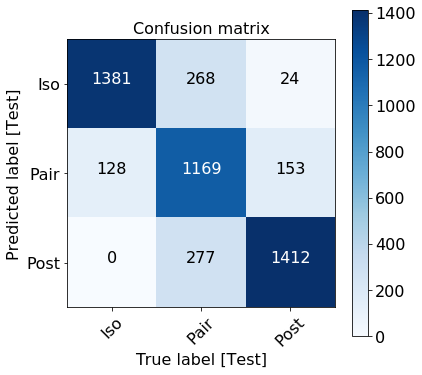

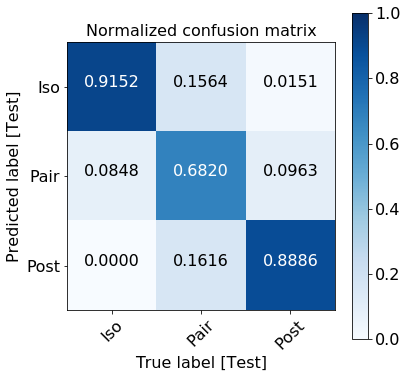

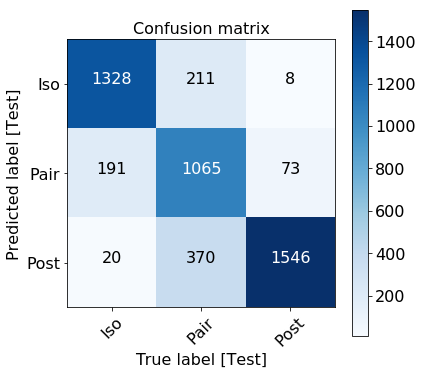

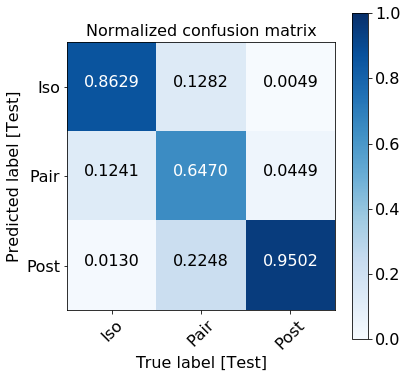

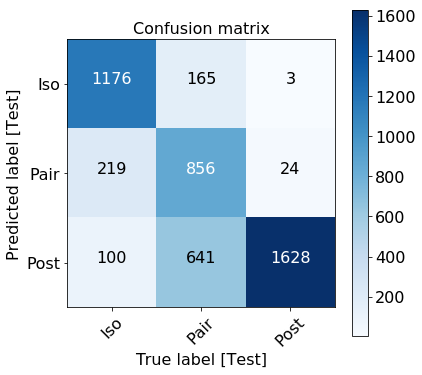

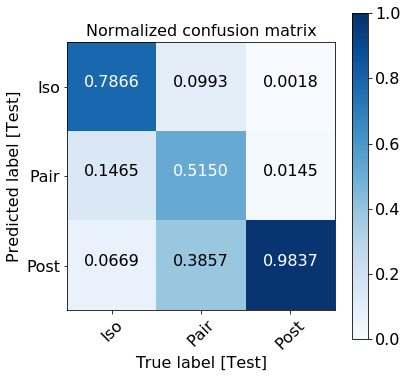

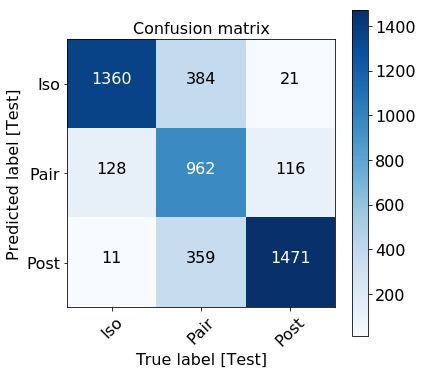

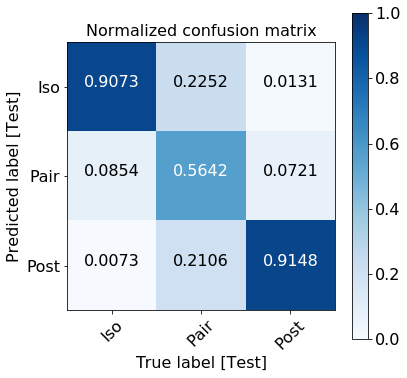

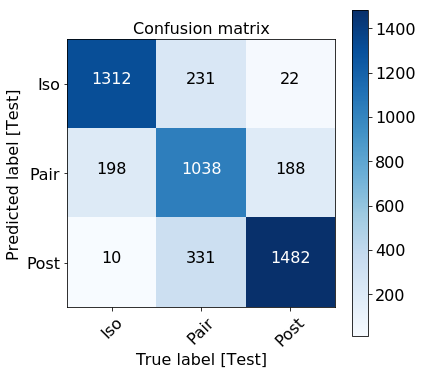

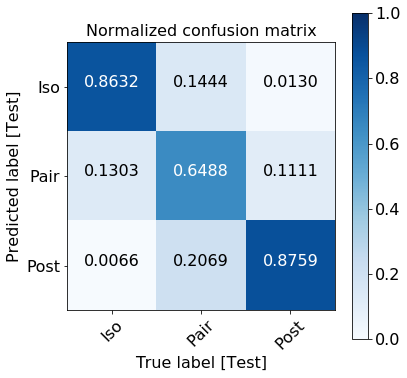

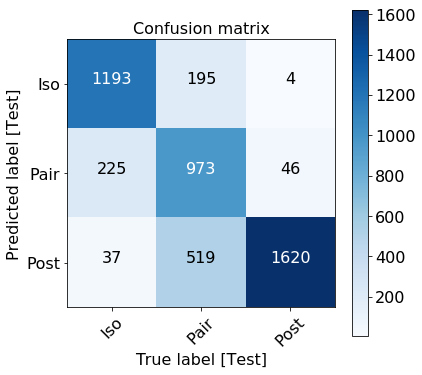

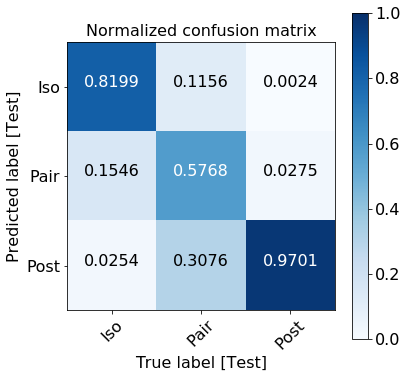

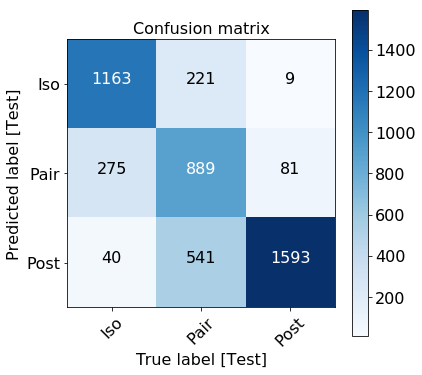

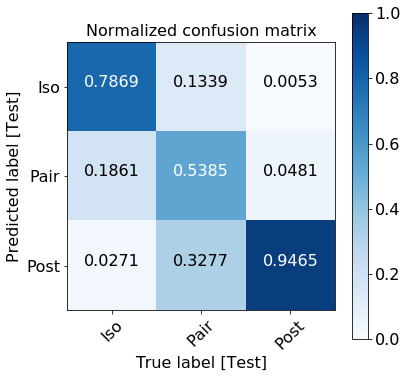

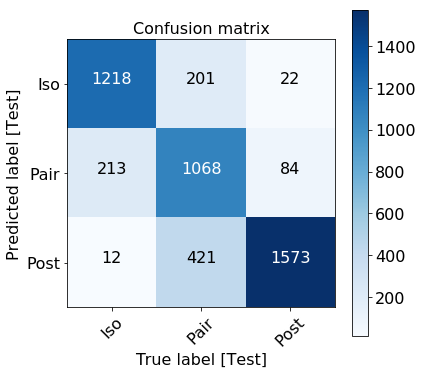

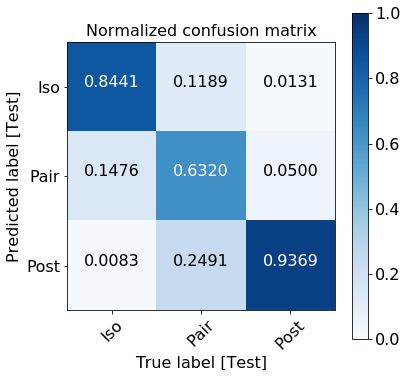

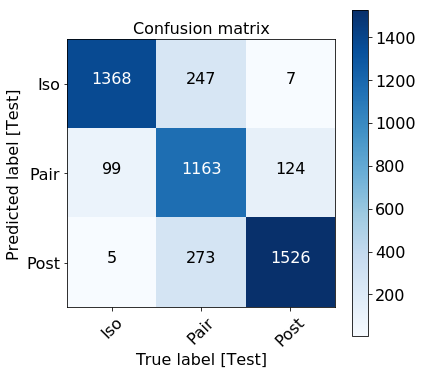

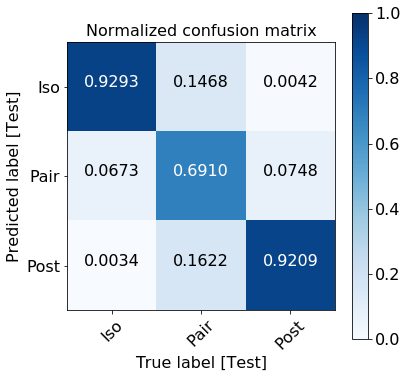

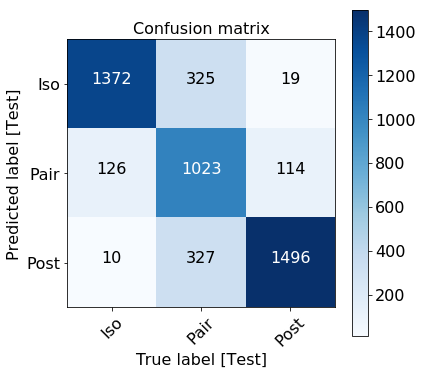

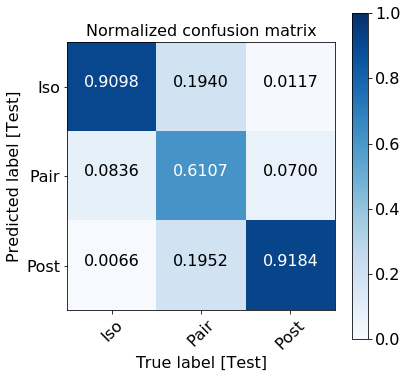

In [5]:
import keras,os,sys,json
from keras import backend as K
import os
import numpy as np
from sklearn import preprocessing
from sklearn import model_selection as md
from keras.models import load_model
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense,Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import regularizers
def save_model_history(model,history_filename):
    with open(history_filename,'w') as f:
        json.dump(model.history.history, f)
        

# host directory
datadir = '/home/bottrell/scratch/RealCNN/MultiClass/Data/'
modeldir = '/home/bottrell/scratch/RealCNN/MultiClass/Models/'
# careful of ordering here
tags = ['Iso','Pair','Post']
# data type from which to generate model 
model_label = 'StellarMap_FullReal'
test_label = 'StellarMap_SemiReal'
##> choose the batch_size, number of epochs and the image size
batch_size = 32
dx = 139
dy = 139
train_valid_split = 0.3
valid_test_split = 0.5
nChannels = (1 if 'StellarMap' in model_label else 3)

# data files
filenames = ['{}{}-{}-InpAugNorm.npy'.format(datadir,tag,test_label) for tag in tags]
# concatenate all data into one large object
inp = np.concatenate([np.load(filename) for filename in filenames],axis=0)
# create target array
tar = np.array([])
for ii,filename in enumerate(filenames):
    tar = np.append(tar,np.ones(np.load(filename).shape[0])*ii)
tar = tar.astype(int)

# One-Hot fromatting
tar_OH= keras.utils.to_categorical(tar) 
# Number of target classes
num_classes = 3

# reshape data from dx*dy to (dx,dy)
inp = inp.reshape(-1,dx,dy,nChannels)

update = 0
version = 0 
randomStates = [1,2,3,4,5,6,7,8,9,42]

for randomState in randomStates:

    modelFile = modeldir+'{}_MultiClass_RS-{}_v{}_{}.h5'.format(model_label,randomState,update,version)
    historyFile = modeldir+'{}_MultiClass_RS-{}_v{}_{}_history.json'.format(model_label,randomState,update,version)
    if not os.access(modelFile,0):
        print('File not found: '+modelFile+'\n')
        continue

    model = load_model(modelFile)
    with open(historyFile) as f:
        history = json.load(f)

    # Split training and validation data
    inp_train, inp_valid, tar_train, tar_valid = md.train_test_split(inp, tar_OH, test_size=train_valid_split, random_state=randomState)
    # Reserve some validation data as test data
    inp_valid, inp_test, tar_valid, tar_test = md.train_test_split(inp_valid, tar_valid, test_size=valid_test_split, random_state=randomState)

    out_train= np.array(model.predict([inp_train]))
    out_valid= np.array(model.predict([inp_valid]))  
    out_test=np.array(model.predict([inp_test]))

    out_train_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_train])
    out_valid_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_valid])
    out_test_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_test])

    tar_train = np.asarray([np.argmax(y, axis=None, out=None) for y in tar_train])
    tar_valid = np.asarray([np.argmax(y, axis=None, out=None) for y in tar_valid])
    tar_test = np.asarray([np.argmax(y, axis=None, out=None) for y in tar_test])

    print_confusion_matrix(out_test_class,tar_test,test_label,model_label,randomState,update,version)

## Case 1.5 Comparisons

Single-channel Photometry models are applied to their test data.

These models have been generated from the r-band and i-band Photometry_{} channels.

Confusion matrix, without normalization
[[1390  160    5]
 [ 119 1442  190]
 [   0  112 1394]]
[[1509]
 [1714]
 [1589]]
[1509 1714 1589]


/project/6020225/bottrell/virtualenvs/tensorflow/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


Normalized confusion matrix
[[0.921 0.093 0.003]
 [0.079 0.841 0.12 ]
 [0.    0.065 0.877]]
[[1.]
 [1.]
 [1.]]
[1. 1. 1.]
Confusion matrix, without normalization
[[1352  118    0]
 [ 175 1099   22]
 [  12  429 1605]]
[[1539]
 [1646]
 [1627]]
[1539 1646 1627]
Normalized confusion matrix
[[0.878 0.072 0.   ]
 [0.114 0.668 0.014]
 [0.008 0.261 0.986]]
[[1.]
 [1.]
 [1.]]
[1. 1. 1.]
Confusion matrix, without normalization
[[1167   79    0]
 [ 318 1321  102]
 [  10  262 1553]]
[[1495]
 [1662]
 [1655]]
[1495 1662 1655]
Normalized confusion matrix
[[0.781 0.048 0.   ]
 [0.213 0.795 0.062]
 [0.007 0.158 0.938]]
[[1.]
 [1.]
 [1.]]
[1. 1. 1.]
Confusion matrix, without normalization
[[1365  161    1]
 [ 132 1310   86]
 [   2  234 1521]]
[[1499]
 [1705]
 [1608]]
[1499 1705 1608]
Normalized confusion matrix
[[9.106e-01 9.443e-02 6.219e-04]
 [8.806e-02 7.683e-01 5.348e-02]
 [1.334e-03 1.372e-01 9.459e-01]]
[[1.]
 [1.]
 [1.]]
[1. 1. 1.]
Confusion matrix, without normalization
[[1295  108    0]
 [ 223 

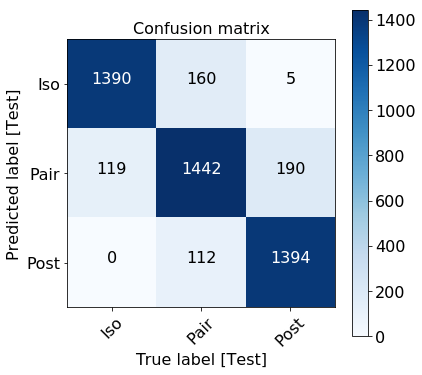

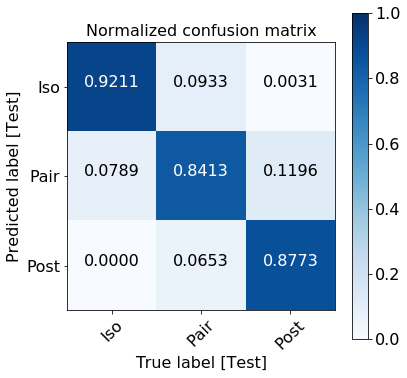

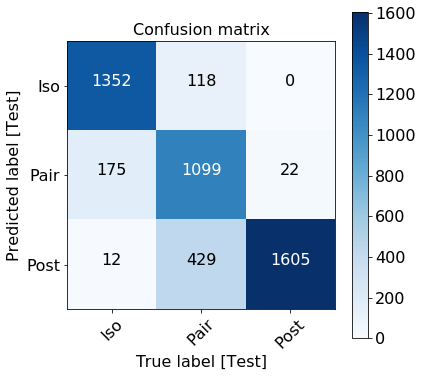

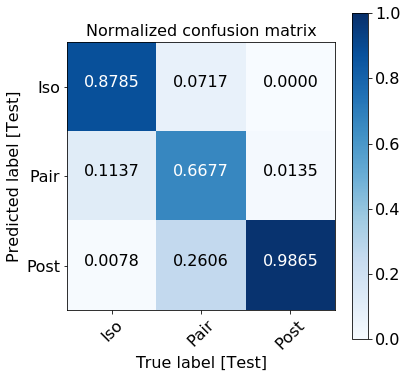

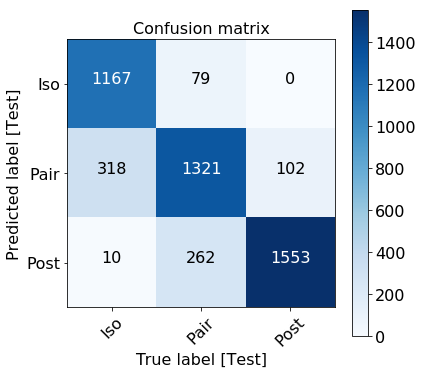

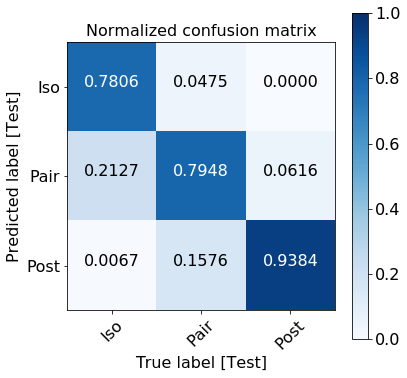

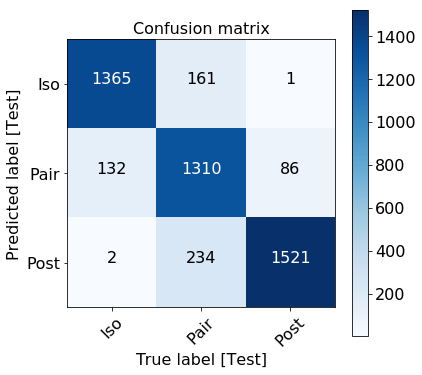

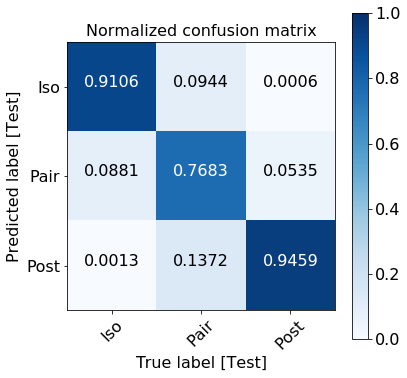

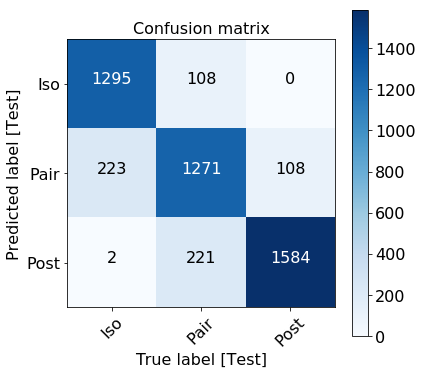

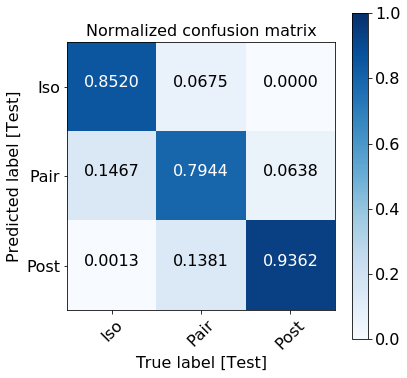

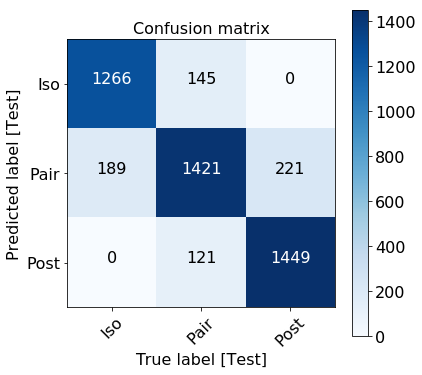

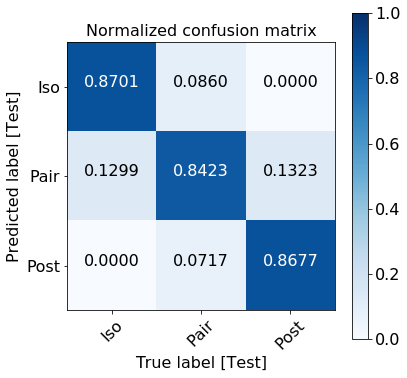

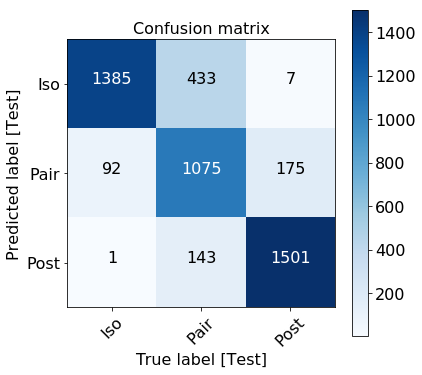

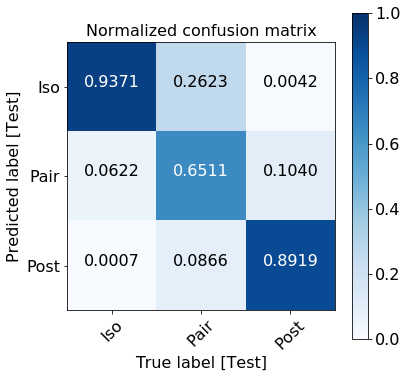

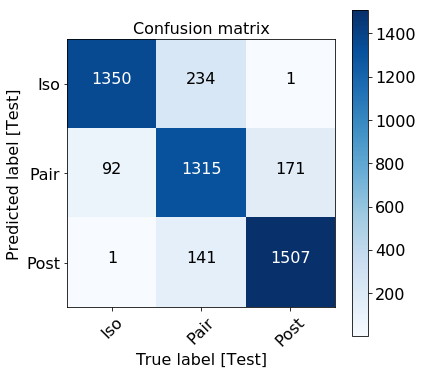

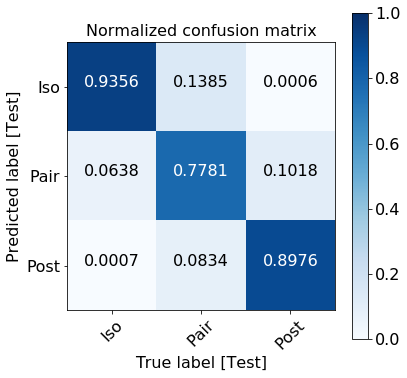

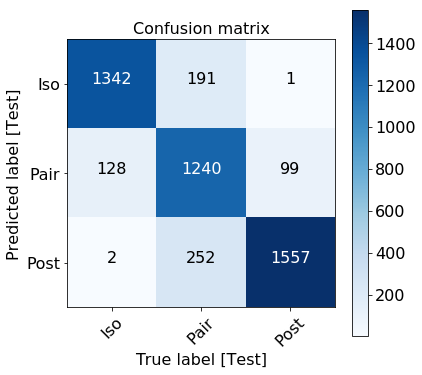

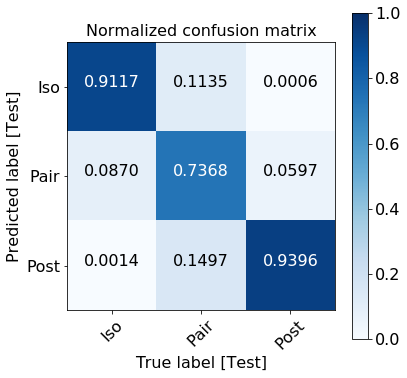

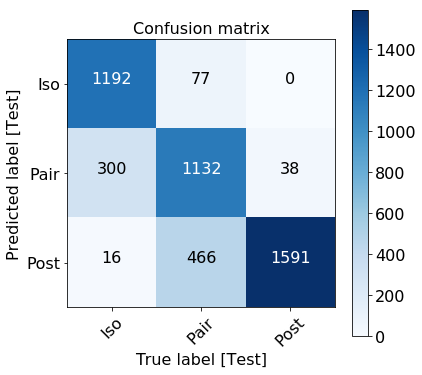

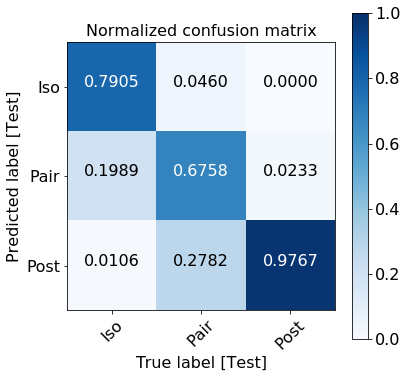

In [3]:
import keras,os,sys,json
from keras import backend as K
import numpy as np
from sklearn import preprocessing
from sklearn import model_selection as md
from keras.models import load_model
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense,Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import regularizers
def save_model_history(model,history_filename):
    with open(history_filename,'w') as f:
        json.dump(model.history.history, f)
        
bands = {'g':0,'r':1,'i':2}

# host directory
datadir = '/home/bottrell/scratch/RealCNN/MultiClass/Data/'
# careful of ordering here
tags = ['Iso','Pair','Post']
# data type from which to generate model 
band = 'r'
model_label = 'Photometry_FullReal-NC1-{}'.format(band)
test_label = 'Photometry_FullReal-NC1-{}'.format(band)
##> choose the batch_size, number of epochs and the image size
batch_size = 32
dx = 139
dy = 139
train_valid_split = 0.3
valid_test_split = 0.5
nChannels = 1

# data files
filenames = ['{}{}-{}-InpAugNorm.npy'.format(datadir,tag,test_label.split('-')[0]) for tag in tags]
# concatenate all data into one large object
inp = np.concatenate([np.load(filename) for filename in filenames],axis=0)
# !!! use only the {band}-band
inp = inp[:,bands[band],:,:]
# create target array
tar = np.array([])
for ii,filename in enumerate(filenames):
    tar = np.append(tar,np.ones(np.load(filename).shape[0])*ii)
tar = tar.astype(int)

# One-Hot fromatting
tar_OH= keras.utils.to_categorical(tar) 
# Number of target classes
num_classes = 3

# reshape data from dx*dy to (dx,dy)
inp = inp.reshape(-1,dx,dy,nChannels)

update = 0
version = 0 
randomStates = [1,2,3,4,5,6,7,8,9,42]

for randomState in randomStates:

    modelFile = '/home/bottrell/scratch/RealCNN/MultiClass/Models/{}_MultiClass_RS-{}_v{}_{}.h5'.format(model_label,randomState,update,version)
    historyFile = '/home/bottrell/scratch/RealCNN/MultiClass/Models/{}_MultiClass_RS-{}_v{}_{}_history.json'.format(model_label,randomState,update,version)
    if not os.access(modelFile,0):
        print('File not found: '+modelFile+'\n')
        continue

    model = load_model(modelFile)
    with open(historyFile) as f:
        history = json.load(f)

    # Split training and validation data
    inp_train, inp_valid, tar_train, tar_valid = md.train_test_split(inp, tar_OH, test_size=train_valid_split, random_state=randomState)
    # Reserve some validation data as test data
    inp_valid, inp_test, tar_valid, tar_test = md.train_test_split(inp_valid, tar_valid, test_size=valid_test_split, random_state=randomState)

    out_train= np.array(model.predict([inp_train]))
    out_valid= np.array(model.predict([inp_valid]))  
    out_test=np.array(model.predict([inp_test]))

    out_train_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_train])
    out_valid_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_valid])
    out_test_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_test])

    tar_train = np.asarray([np.argmax(y, axis=None, out=None) for y in tar_train])
    tar_valid = np.asarray([np.argmax(y, axis=None, out=None) for y in tar_valid])
    tar_test = np.asarray([np.argmax(y, axis=None, out=None) for y in tar_test])

    print_confusion_matrix(out_test_class,tar_test,test_label,model_label,randomState,update,version)

## Case 2 Comparisons

Case two is where either a Photometry-based model is applied to the StellarMap test data or vice-versa. This is a distinct case because single-channel Photometry models must be used in place of their full 3-channel counterparts. Similarly, only a single channel of the Photometry test data are to be used as inputs when applying the StellarMap models.

Confusion matrix, without normalization
[[8458 2301  105]
 [1536 7943 2319]
 [   6  796 8616]]
[[10000]
 [11040]
 [11040]]
[10000 11040 11040]


/project/6020225/bottrell/virtualenvs/tensorflow/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


Normalized confusion matrix
[[8.458e-01 2.084e-01 9.511e-03]
 [1.536e-01 7.195e-01 2.101e-01]
 [6.000e-04 7.210e-02 7.804e-01]]
[[1.]
 [1.]
 [1.]]
[1. 1. 1.]
Confusion matrix, without normalization
[[8676 1506   40]
 [1249 7851 1305]
 [  75 1683 9695]]
[[10000]
 [11040]
 [11040]]
[10000 11040 11040]
Normalized confusion matrix
[[0.868 0.136 0.004]
 [0.125 0.711 0.118]
 [0.007 0.152 0.878]]
[[1.]
 [1.]
 [1.]]
[1. 1. 1.]
Confusion matrix, without normalization
[[ 8277  1239    53]
 [ 1527  7309   826]
 [  196  2492 10161]]
[[10000]
 [11040]
 [11040]]
[10000 11040 11040]
Normalized confusion matrix
[[0.828 0.112 0.005]
 [0.153 0.662 0.075]
 [0.02  0.226 0.92 ]]
[[1.]
 [1.]
 [1.]]
[1. 1. 1.]
Confusion matrix, without normalization
[[8767 2192  126]
 [1119 7398 2043]
 [ 114 1450 8871]]
[[10000]
 [11040]
 [11040]]
[10000 11040 11040]
Normalized confusion matrix
[[0.877 0.199 0.011]
 [0.112 0.67  0.185]
 [0.011 0.131 0.804]]
[[1.]
 [1.]
 [1.]]
[1. 1. 1.]
Confusion matrix, without normalizatio

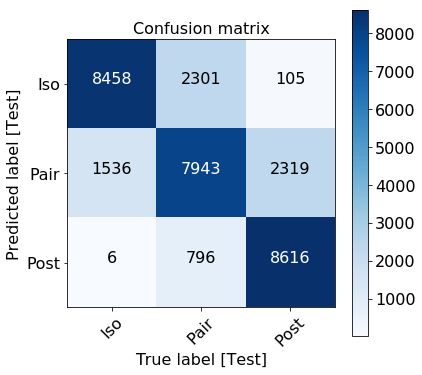

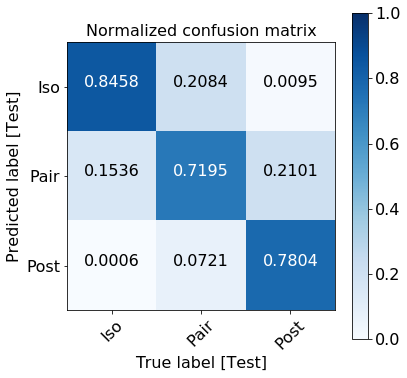

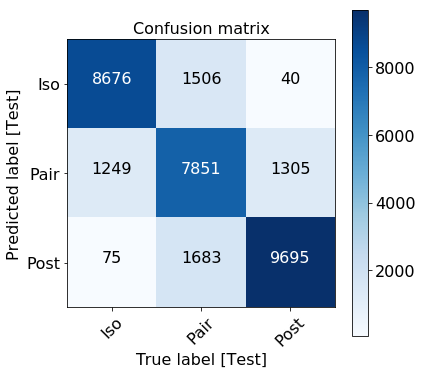

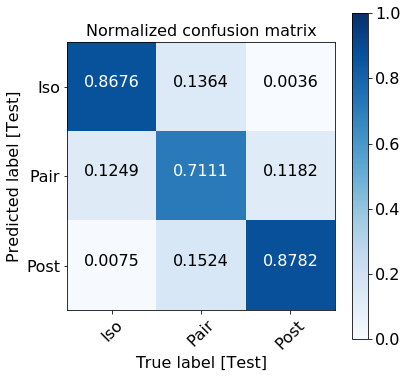

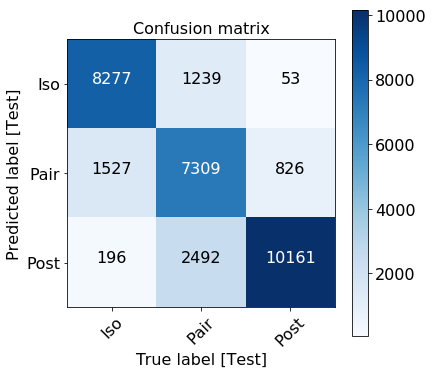

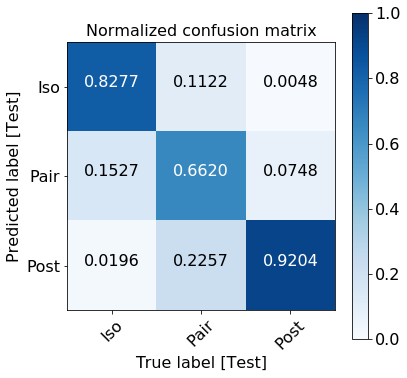

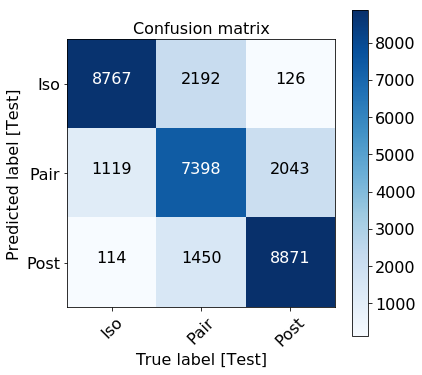

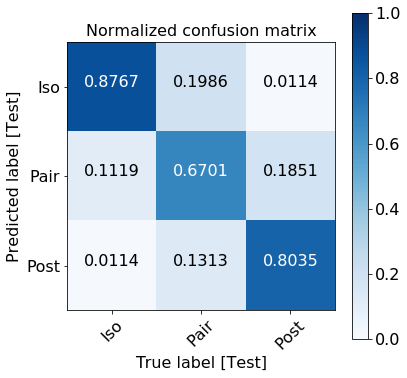

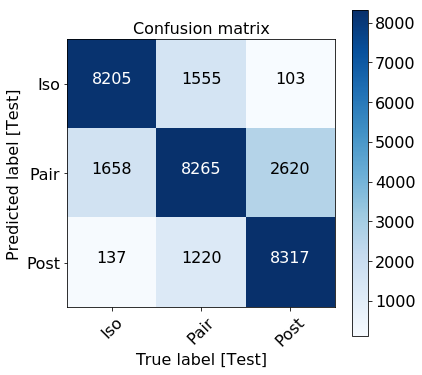

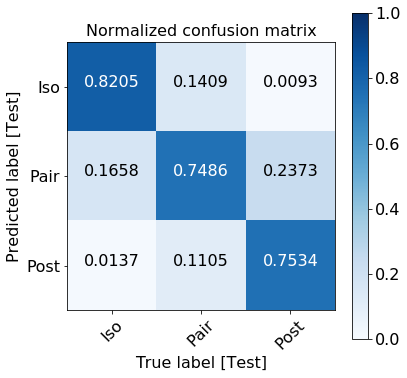

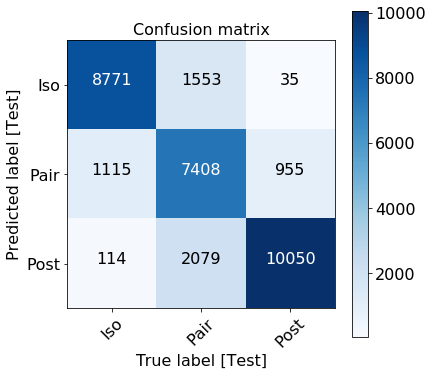

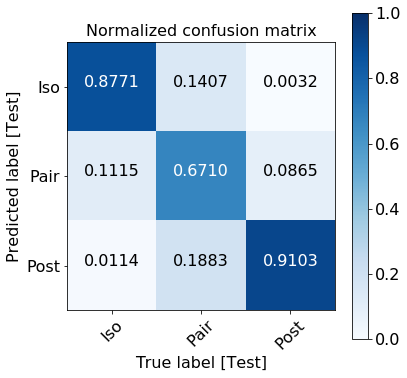

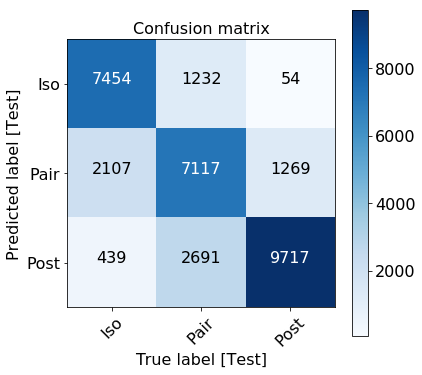

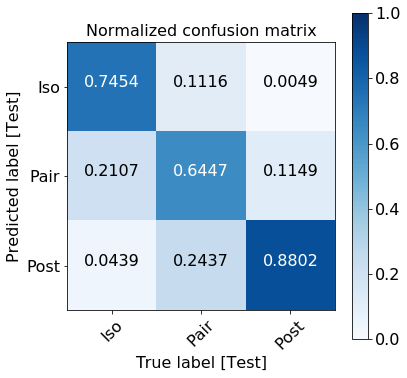

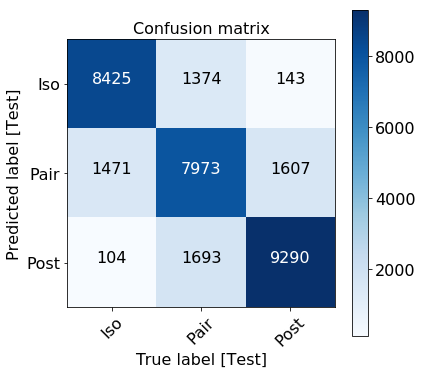

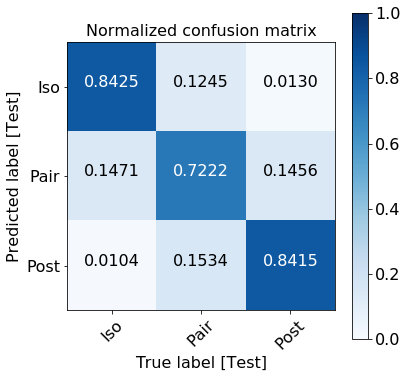

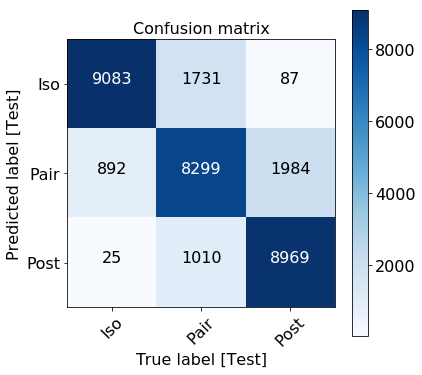

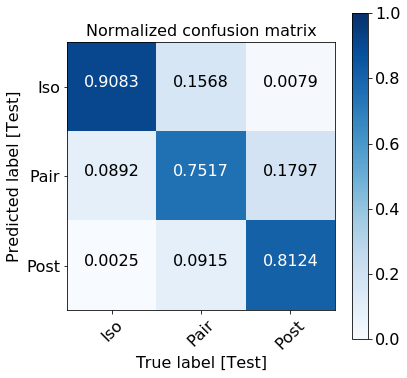

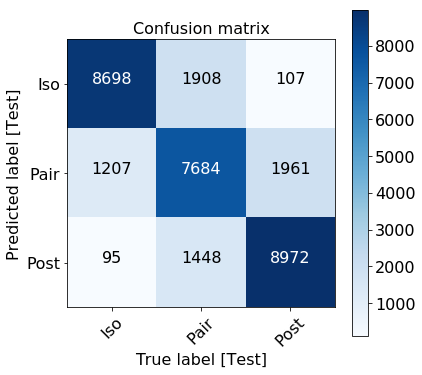

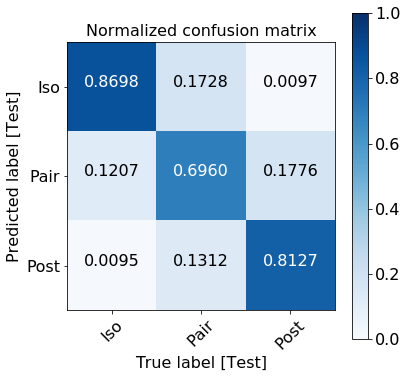

In [3]:
import keras,os,sys,json
from keras import backend as K
import numpy as np
from sklearn import preprocessing
from sklearn import model_selection as md
from keras.models import load_model
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense,Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import regularizers

def save_model_history(model,history_filename):
    with open(history_filename,'w') as f:
        json.dump(model.history.history, f)

# host directory
datadir = '/home/bottrell/scratch/RealCNN/MultiClass/Data/'
modeldir = '/home/bottrell/scratch/RealCNN/MultiClass/Models/'
# careful of ordering here
tags = ['Iso','Pair','Post']
# data type from which to generate model 
model_label = 'StellarMap_FullReal'
test_label = 'Photometry_FullReal-NC1-i'
##> choose the batch_size, number of epochs and the image size
batch_size = 32
dx = 139
dy = 139
train_valid_split = 0.3
valid_test_split = 0.5
nChannels = 1

# data files
filenames = ['{}{}-{}-InpAugNorm.npy'.format(datadir,tag,test_label.split('-NC1')[0]) for tag in tags]
# concatenate all data into one large object
inp = np.concatenate([np.load(filename) for filename in filenames],axis=0)
if 'Photometry' in test_label:
    # !!! use only the i-band
    inp = inp[:,2,:,:]

# create target array
tar = np.array([])
for ii,filename in enumerate(filenames):
    tar = np.append(tar,np.ones(np.load(filename).shape[0])*ii)
tar = tar.astype(int)

# One-Hot fromatting
tar_OH= keras.utils.to_categorical(tar) 
# Number of target classes
num_classes = 3

# reshape data from dx*dy to (dx,dy)
inp = inp.reshape(-1,dx,dy,nChannels)

update = 0
version = 0 
randomStates = [1,2,3,4,5,6,7,8,9,42]

for randomState in randomStates:
    
    modelFile = '{}{}_MultiClass_RS-{}_v{}_{}.h5'
    model = load_model(modelFile.format(modeldir,model_label,randomState,update,version))

    # # Split training and validation data
    # inp_train, inp_valid, tar_train, tar_valid = md.train_test_split(inp, tar_OH, test_size=train_valid_split, random_state=randomState)
    # # Reserve some validation data as test data
    # inp_valid, inp_test, tar_valid, tar_test = md.train_test_split(inp_valid, tar_valid, test_size=valid_test_split, random_state=randomState)

    # out_train= np.array(model.predict([inp_train]))
    # out_valid= np.array(model.predict([inp_valid]))  
    out_test=np.array(model.predict([inp]))

    # out_train_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_train])
    # out_valid_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_valid])
    out_test_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_test])

    # tar_train = np.asarray([np.argmax(y, axis=None, out=None) for y in tar_train])
    # tar_valid = np.asarray([np.argmax(y, axis=None, out=None) for y in tar_valid])
    tar_test = np.asarray([np.argmax(y, axis=None, out=None) for y in tar_OH])

    print_confusion_matrix(out_test_class,tar_test,test_label,model_label,randomState,update,version)

## Load model and apply to a given test set

In [ ]:
import keras,os,sys,json
from keras import backend as K
import numpy as np
from sklearn import preprocessing
from sklearn import model_selection as md
from keras.models import load_model
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense,Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import regularizers
def save_model_history(model,history_filename):
    with open(history_filename,'w') as f:
        json.dump(model.history.history, f)
        

# host directory
datadir = '/home/bottrell/scratch/RealCNN/MultiClass/Data/'
# careful of ordering here
tags = ['Iso','Pair','Post']
# data type from which to generate model ['StellarMap','Photometry','ObsRealism']
model_label = 'Photometry'
# data type on which to apply model
test_label = 'ObsRealism'
##> choose the batch_size, number of epochs and the image size
batch_size = 32
dx = 139
dy = 139
randomState=1
nChannels = (1 if model_label is 'StellarMap' else 3)
update = 0
version = 0
modelFile = '/home/bottrell/scratch/RealCNN/MultiClass/Models/{}_MultiClass_RS-{}_v{}_{}.h5'.format(model_label,randomState,update,version)
historyFile = '/home/bottrell/scratch/RealCNN/MultiClass/Models/{}_MultiClass_RS{}_v{}_{}_history.json'.format(model_label,randomState,update,version)

model = load_model(modelFile)
with open(historyFile) as f:
    history = json.load(f)

# data files
filenames = ['{}{}-{}-InpAugNorm.npy'.format(datadir,tag,test_label) for tag in tags]
# concatenate all data into one large object
inp = np.concatenate([np.load(filename) for filename in filenames],axis=0)
# create target array
tar = np.array([])
for ii,filename in enumerate(filenames):
    tar = np.append(tar,np.ones(np.load(filename).shape[0])*ii)
tar = tar.astype(int)

# One-Hot fromatting
tar_OH= keras.utils.to_categorical(tar) 
# Number of target classes
num_classes = 3

if model_label is 'StellarMap' and test_label in ['Photometry','ObsRealism']:
    inp = inp[:,1] # r-band only

# reshape data from dx*dy to (dx,dy)
inp = inp.reshape(-1,dx,dy,nChannels)


# inp_imt, inp_imv, tart, tarv = md.train_test_split(inp, 
#                                                    tar_OH, 
#                                                    test_size=0.25, 
#                                                    random_state=42)

out_test= np.array(model.predict([inp]))
 

#out_train_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_train])
out_test_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_test])

## Confusion matrix for test data

In [2]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(ax, cm, classes, update, version,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=0)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    print(np.sum(cm,axis=0)[:, np.newaxis])
    print(np.sum(cm,axis=0))
    
    if normalize:
        im1 = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    else :
        im1 = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title,fontsize=16)
    cb = plt.colorbar(im1)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    #ax.text(0.5,0.05,'model_v{}_{}'.format(update,version),ha='center',va='bottom',
    #        transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
    #ax.tight_layout()
    ax.set_ylabel('Predicted label [Test]')
    ax.set_xlabel('True label [Test]')

def print_confusion_matrix(out_test_class,tar_test,
                           test_label,model_label,
                           randomState,update,version):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(tar_test, out_test_class).T
    np.set_printoptions(precision=3)


    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 16

    # Plot non-normalized confusion matrix
    fig,ax = plt.subplots(figsize=(6,6))
    plot_confusion_matrix(ax,cnf_matrix, classes=['Iso','Pair','Post'], update=update, version=version,
                          title='Confusion matrix')
    fig.savefig('/home/bottrell/scratch/RealCNN/MultiClass/Models/{}_ConfMatrix_{}_RS-{}_v{}_{}.pdf'.format(test_label,model_label,randomState,update,version),bbox_inches='tight')

    ## Plot normalized confusion matrix
    fig,ax = plt.subplots(figsize=(6,6))
    plot_confusion_matrix(ax,cnf_matrix, classes=['Iso','Pair','Post'], update = update, version=version,
                          normalize=True, title='Normalized confusion matrix')

    fig.savefig('/home/bottrell/scratch/RealCNN/MultiClass/Models/{}_ConfMatrixNorm_{}_RS-{}_v{}_{}.pdf'.format(test_label,model_label,randomState,update,version),bbox_inches='tight')

#print(len(tar_test[tar_test==0]))
#print_confusion_matrix(out_test_class,tar_test,test_label,model_label,randomState,update,version)

## Plotting function
Make grid plot for image thumbnails.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

nrows = ncols = 5
nsamples = nrows**2

imgs = np.zeros(shape=(nsamples,nrows,ncols))

fig,axarr = plt.subplots(ncols,nrows,figsize=(ncols*2,ncols*2))

# adjust width and height between boxes
# fig.subplots_adjust(wspace=0,hspace=0)
# a little bit of spacing wrt figsize
fig.subplots_adjust(wspace=0.1,hspace=0.1)

# In this format, with imshow's aspect='auto', 
# the panels will reformat to rectangular shapes
# if you set wspace!=hspace. I recommend using
# aspect = 'auto' in imshow and keeping wspace
# the same as hspace if you want perfectly square
# panels and alignment.

# You can adjust the wspace and hspace parameters
# when imshow's aspect='equal' (which forces the 
# panel aspect to be equal) but it might require 
# more care in choosing wspace and hspace. 



# loop over axes and images
for ax,img in zip(axarr.flatten(),imgs):
    # remove ticks and labels x
    ax.tick_params(axis='x',which='both',bottom=False,
                   top=False,labelbottom=False)
    # remove ticks and labels y
    ax.tick_params(axis='y',which='both',left=False,
                   right=False,labelleft=False)
    # plot
    ax.imshow(img,cmap='Greys',vmin=0,vmax=1,aspect='auto')
    # can also force aspect to be 'equal' but you will have 
    # to play with wspace and hspace
    # ax.imshow(img,cmap='Greys',vmin=0,vmax=1,aspect='equal')

fig.savefig('test.pdf',bbox_inches='tight')

## Testing Image and Catalog Continuity

Testing sorting of image arrays according to catalogs. Catalogs are separately sorted alphanumerically then the sorting indices are passed to the main image arrays. Testing shows matching of arrays is accomplished.

(11040, 3, 139, 139)
(11040, 3, 139, 139)


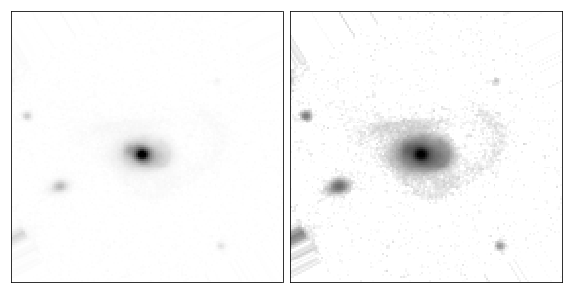

In [5]:
import numpy as np
import matplotlib.pyplot as plt

label_p = 'Photometry_FullReal'
label_s = 'Photometry_FullReal'

filename_p = '/home/bottrell/scratch/RealCNN/MultiClass/Data/Norm/Pair-{}-InpAugNorm.npy'.format(label_p)
filename_s = '/home/bottrell/scratch/RealCNN/MultiClass/Data/Pair-{}-InpAugNorm.npy'.format(label_s)

# load files and catalogs
inp_p = np.load(filename_p)
inp_s = np.load(filename_s)
cat_p = np.load('/home/bottrell/scratch/RealCNN/MultiClass/Data/Pair-{}_catAug.npy'.format(label_p))
cat_s = np.load('/home/bottrell/scratch/RealCNN/MultiClass/Data/Pair-{}_catAug.npy'.format(label_s))
# silly convention in catalog creation (should fix at source)
cat_p[:,2] = np.array(['{:03}'.format(x) for x in cat_p[:,2].astype(int)])
cat_s[:,2] = np.array(['{:03}'.format(x) for x in cat_s[:,2].astype(int)])

# join catalogs elements
cat_pn = ['_'.join(list(cat_p[ii])) for ii in range(len(cat_p))]
cat_sn = ['_'.join(list(cat_s[ii])) for ii in range(len(cat_s))]

# sorting
index_p = np.argsort(cat_pn)
index_s = np.argsort(cat_sn)

# sorted
inp_p = inp_p[index_p]
inp_s = inp_s[index_s]

print(inp_p.shape)
print(inp_s.shape)

index = 191
fig,axarr = plt.subplots(1,2,figsize=(10,5))
fig.subplots_adjust(hspace=0,wspace=0)

for ax in axarr.flatten():
    # remove ticks and labels x
    ax.tick_params(axis='x',which='both',bottom=False,
                   top=False,labelbottom=False)
    # remove ticks and labels y
    ax.tick_params(axis='y',which='both',left=False,
                   right=False,labelleft=False)

axarr[0].imshow(inp_p[index,0],vmin=0.,vmax=1,cmap='Greys')
axarr[1].imshow(inp_s[index,0],vmin=0.,vmax=1,cmap='Greys')

#fig.savefig('test.pdf',bbox_inches='tight')

## Test different normalization methods

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def NormY(x,window=20,is_sky=False):
    # if sky noise is present, subtract sky level
    if is_sky:
        x = x-np.nanmedian(x)
    # take log of skyless image
    x = np.log10(x)
    # get rid of pesky nan values
    x[x<-5]=np.nan
    xc = yc = int(x.shape[-1]/2)
    # compute median
    a_min = np.nanmedian(x)
    dwinx = dwiny = int(window/2)
    # compute upper limit in central window
    a_max = np.nanpercentile(x[xc-dwinx:xc+dwinx,yc-dwiny:yc+dwiny],99)
    # clip/normalize linear image
    x = np.clip(x,a_min=a_min,a_max=a_max)
    x[np.isnan(x)]=a_min
    x = (x - a_min)/(a_max-a_min)
    return x

def NormX(x,window=20):
    xc = yc = int(x.shape[-1]/2)
    # compute median
    a_min = np.nanmedian(x)
    dwinx = dwiny = int(window/2)
    # compute upper limit in central window
    a_max = np.nanpercentile(x[xc-dwinx:xc+dwinx,yc-dwiny:yc+dwiny],99)
    # clip/normalize linear image
    x = np.clip(x,a_min=a_min,a_max=a_max)
    x = x - a_min
    x = x/(a_max-a_min)
    # take log
    x = np.log10(x)
    a_min = -5
    a_max = 0
    # clip/normalize log image
    x = np.clip(x,a_min=a_min,a_max=a_max)
    x[np.isnan(x)]=a_min
    x = (x-a_min)/(a_max-a_min)
    return x

def NormZ(x,window=20):
    xc = yc = int(x.shape[-1]/2)
    dwinx = dwiny = int(window/2)
    x = np.log10(x)
    x[x<-5]=np.nan
    a_min = np.nanmedian(x)
    # compute upper limit in central window
    a_max = np.nanpercentile(x[xc-dwinx:xc+dwinx,yc-dwiny:yc+dwiny],99)
    # clip/normalize linear image
    x = np.clip(x,a_min=a_min,a_max=a_max)
    x[np.isnan(x)]=a_min
    x = x - a_min
    x = x/(a_max-a_min)
    return x

def Norm(x,window=20):
    xc = yc = int(x.shape[-1]/2)
    dwinx = dwiny = int(window/2)
    x = np.log10(x)
    #x[x<-5]=np.nan
    a_min = np.nanmedian(x)
    # compute upper limit in central window
    a_max = np.nanpercentile(x[xc-dwinx:xc+dwinx,yc-dwiny:yc+dwiny],99)
    # clip/normalize linear image
    x = np.clip(x,a_min=a_min,a_max=a_max)
    x[np.isnan(x)]=a_min
    x = x - a_min
    x = x/(a_max-a_min)
    return x


imageTypes = ['StellarMap','StellarMap_SemiReal','StellarMap_FullReal',
              'Photometry','Photometry_SemiReal','Photometry_FullReal']
fig,axarr = plt.subplots(2,3,figsize=(15,10))
axarr = axarr.flatten()
label = 'Pair'
dx = dy = 139
index = 893

for ax in axarr.flatten():
    # remove ticks and labels x
    ax.tick_params(axis='x',which='both',bottom=False,
                   top=False,labelbottom=False)
    # remove ticks and labels y
    ax.tick_params(axis='y',which='both',left=False,
                   right=False,labelleft=False)


for imageType,ax in zip(imageTypes,axarr):
    
    filename = '/home/bottrell/scratch/RealCNN/MultiClass/Data/{}-{}-InpAug.npy'.format(label,imageType)
    inp = np.load(filename)
    filecat = '/home/bottrell/scratch/RealCNN/MultiClass/Data/{}-{}_catAug.npy'.format(label,imageType)
    cat = np.load(filecat)
    # silly convention in catalog creation (should fix at source)
    cat[:,2] = np.array(['{:03}'.format(x) for x in cat[:,2].astype(int)])
    # join catalogs elements
    cat_n = ['_'.join(list(cat[ii])) for ii in range(len(cat))]
    # sorting
    indices = np.argsort(cat_n)
    # sorted
    inp = inp[indices]
    # get number of channels
    nChannels = (1 if 'StellarMap' in imageType else 3)
    # reshape
    inp = inp.reshape(-1,nChannels,dx,dy)
    # get number of records
    nRecords = inp.shape[0]
    # plot
    data = NormY(inp[index,0],is_sky=(True if 'Real' in imageType else False))
    ax.imshow(data,vmin=0.0,vmax=1,cmap='Greys')
    ax.text(0.5,0.1,imageType,ha='center',va='bottom',transform=ax.transAxes)
    print(np.array(cat_n)[indices][index])
   

    



G2G3_e_orbit_2_495_i3


/project/6020225/bottrell/virtualenvs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/project/6020225/bottrell/virtualenvs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/project/6020225/bottrell/virtualenvs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


G2G3_e_orbit_2_495_i3
G2G3_e_orbit_2_495_i3


## Examine output

G2G3_e_orbit_3_282_i3
G2G3_e_orbit_3_282_i3
G2G3_e_orbit_3_282_i3
G2G3_e_orbit_3_282_i3
G2G3_e_orbit_3_282_i3
G2G3_e_orbit_3_282_i3


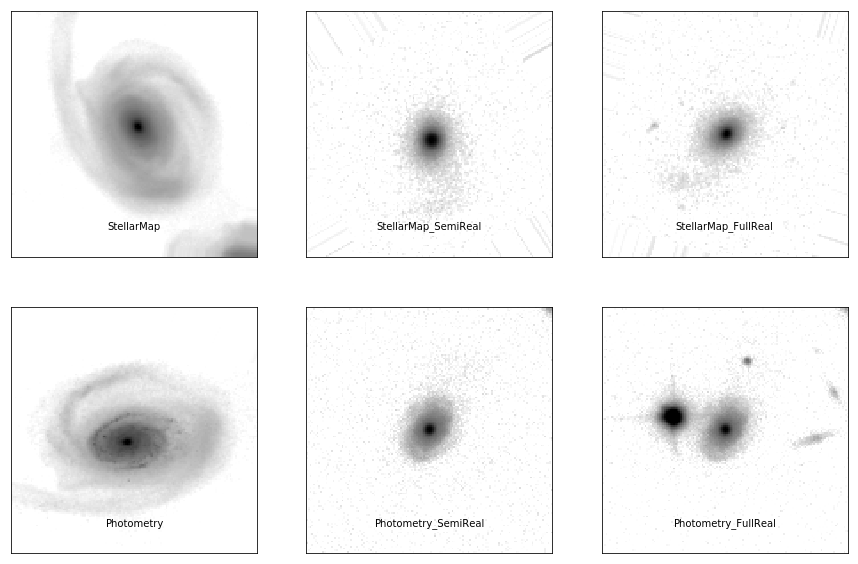

In [9]:
import numpy as np
import matplotlib.pyplot as plt

imageTypes = ['StellarMap','StellarMap_SemiReal','StellarMap_FullReal',
              'Photometry','Photometry_SemiReal','Photometry_FullReal']
fig,axarr = plt.subplots(2,3,figsize=(15,10))
axarr = axarr.flatten()
label = 'Pair'
dx = dy = 139
index = 1293

for ax in axarr.flatten():
    # remove ticks and labels x
    ax.tick_params(axis='x',which='both',bottom=False,
                   top=False,labelbottom=False)
    # remove ticks and labels y
    ax.tick_params(axis='y',which='both',left=False,
                   right=False,labelleft=False)


for imageType,ax in zip(imageTypes,axarr):
    
    filename = '/home/bottrell/scratch/RealCNN/MultiClass/Data/{}-{}-InpAugNorm.npy'.format(label,imageType)
    inp = np.load(filename)
    filecat = '/home/bottrell/scratch/RealCNN/MultiClass/Data/{}-{}_catAug.npy'.format(label,imageType)
    cat = np.load(filecat)
    # silly convention in catalog creation (should fix at source)
    cat[:,2] = np.array(['{:03}'.format(x) for x in cat[:,2].astype(int)])
    # join catalogs elements
    cat_n = ['_'.join(list(cat[ii])) for ii in range(len(cat))]
    # sorting
    indices = np.argsort(cat_n)
    # sorted
    inp = inp[indices]
    # get number of channels
    nChannels = (1 if 'StellarMap' in imageType else 3)
    # reshape
    inp = inp.reshape(-1,nChannels,dx,dy)
    # get number of records
    nRecords = inp.shape[0]
    # plot
    data = inp[index,0] 
    ax.imshow(data,vmin=0.0,vmax=1,cmap='Greys')
    ax.text(0.5,0.1,imageType,ha='center',va='bottom',transform=ax.transAxes)
    print(np.array(cat_n)[indices][index])
   


## Produce CNN models
Make 10 of each model. Also found in the Produce_Models.py file.

In [ ]:
import keras,os,sys,json
from keras import backend as K
import numpy as np
from sklearn import preprocessing
from sklearn import model_selection as md
from keras.models import load_model
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense,Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import regularizers
def save_model_history(model,history_filename):
    with open(history_filename,'w') as f:
        json.dump(model.history.history, f)
        

# host directory
datadir = '/home/bottrell/scratch/RealCNN/MultiClass/Data/'
modeldir = '/home/bottrell/scratch/RealCNN/MultiClass/Models/'
# careful of ordering here
tags = ['Iso','Pair','Post']
# data type from which to generate model 
# options are:
# 'StellarMap','StellarMap_SemiReal','StellarMap_FullReal'
# 'Photometry','Photometry_semiReal','Photometry_FullReal'
labels = ['StellarMap','StellarMap_SemiReal','StellarMap_FullReal',
          'Photometry','Photometry_semiReal','Photometry_FullReal']

batch_size = 32
epochs=30
dx = 139
dy = 139
train_valid_split = 0.3
valid_test_split = 0.5
update = 0
version = 0 
          
for label in labels:

    # number of channels
    nChannels = (1 if 'StellarMap' in label else 3)

    # data files
    filenames = ['{}{}-{}-InpAugNorm.npy'.format(datadir,tag,label) for tag in tags]
    # concatenate all data into one large object
    inp = np.concatenate([np.load(filename) for filename in filenames],axis=0)
    # create target array
    tar = np.array([])
    for ii,filename in enumerate(filenames):
        tar = np.append(tar,np.ones(np.load(filename).shape[0])*ii)
    tar = tar.astype(int)

    # One-Hot fromatting
    tar_OH= keras.utils.to_categorical(tar) 
    # Number of target classes
    num_classes = 3
    # reshape data from dx*dy to (dx,dy)
    inp = inp.reshape(-1,dx,dy,nChannels)
    randomStates = [1,2,3,4,5,6,7,8,9,42]

    for randomState in randomStates:

        modelFile = modeldir+'{}_MultiClass_RS-{}_v{}_{}.h5'
        historyFile = modeldir+'{}_MultiClass_RS-{}_v{}_{}_history.json'
        if os.access(modelFile.format(label,randomState,update,version),0): continue
            
        modelFile = modelFile.format(label,randomState,update,version)
        print('Model will save as: {}'.format(modelFile))
        historyFile = historyFile.format(label,randomState,update,version)
        print('History will save as: {}'.format(historyFile))

        # Split training and validation data
        inp_train, inp_valid, tar_train, tar_valid = md.train_test_split(inp, tar_OH, test_size=train_valid_split, random_state=randomState)
        # Reserve some validation data as test data
        inp_valid, inp_test, tar_valid, tar_test = md.train_test_split(inp_valid, tar_valid, test_size=valid_test_split, random_state=randomState)

        # convolution model
        inputs = Input(shape=(dx,dy,nChannels), name='main_input')
        # first conv layer
        x = Conv2D(32, kernel_size=(6,6),activation='relu',
                   padding='same',strides=(1, 1),name='Conv_1')(inputs)
        x = MaxPooling2D(pool_size=(2,2),name='MP_C1')(x)
        #x = Dropout(0.5,name='Drop_C1')(x)
        # second conv layer
        x = Conv2D(64, kernel_size=(5,5),activation='relu',
                   padding='same',strides=(1, 1),name='Conv_2')(x)
        x = MaxPooling2D(pool_size=(2,2),name='MP_C2')(x)
        #x = Dropout(0.25,name='Drop_C2')(x)
        # third conv layer
        x = Conv2D(128, kernel_size=(2,2),activation='relu',
                   padding='same',strides=(1, 1),name='Conv_3')(x)
        x = MaxPooling2D(pool_size=(2,2),name='MP_C3')(x)
        #x = Dropout(0.25,name='Drop_C3')(x)
        # fourth conv layer
        x = Conv2D(128, kernel_size=(3,3),activation='relu',
                   padding='same',strides=(1, 1),name='Conv_4')(x)
        # x = Dropout(0.25,name='Drop_C4')(x)
        # flatten for fully connected layers
        x = Flatten(name='Flatten')(x)

        # Fully Connected Layer
        x = Dense(512,activation='relu',name='Dense_1')(x)
        x = Dropout(0.25,name='DropFCL_1')(x)
        x = Dense(128,activation='relu',name='Dense_2')(x)
        x = Dropout(0.25,name='DropFCL_2')(x)
        x = Dense(num_classes,activation='softmax',name='Dense_3')(x)

        model = Model(inputs=inputs,outputs=x)
        print(model.summary())

        model.compile(optimizer=keras.optimizers.Adadelta(), 
                      loss='categorical_crossentropy',metrics=['accuracy'])

        early_stopping = EarlyStopping(monitor='val_loss',patience=2,verbose=0,mode='auto')

        model.fit(inp_train,tar_train,shuffle=True,epochs=epochs,
                  batch_size=batch_size,validation_data=[inp_valid,tar_valid],
                  callbacks=[early_stopping])  ##> fitting

        out_train= np.array(model.predict([inp_train]))
        out_valid= np.array(model.predict([inp_valid]))  
        out_test=np.array(model.predict([inp_test]))

        out_train_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_train])
        out_valid_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_valid])
        out_test_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_test])

        model.save(modelFile)
        save_model_history(model=model,history_filename=historyFile)

Model will save as: /home/bottrell/scratch/RealCNN/MultiClass/Models/Photometry_FullReal_MultiClass_RS-1_v0_0.h5
History will save as: /home/bottrell/scratch/RealCNN/MultiClass/Models/Photometry_FullReal_MultiClass_RS-1_v0_0_history.json
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 139, 139, 3)       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 139, 139, 32)      3488      
_________________________________________________________________
MP_C1 (MaxPooling2D)         (None, 69, 69, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 69, 69, 64)        51264     
_________________________________________________________________
MP_C2 (MaxPooling2D)         (None, 34, 34, 64)        0         
____________________________________

In [38]:
labels = ['StellarMap','StellarMap_SemiReal','StellarMap_FullReal',
          'Photometry','Photometry_SemiReal','Photometry_FullReal']

for label_i in labels:
    for label_j in labels:
        print(label_i+'-->'+label_j)

StellarMap-->StellarMap
StellarMap-->StellarMap_SemiReal
StellarMap-->StellarMap_FullReal
StellarMap-->Photometry
StellarMap-->Photometry_SemiReal
StellarMap-->Photometry_FullReal
StellarMap_SemiReal-->StellarMap
StellarMap_SemiReal-->StellarMap_SemiReal
StellarMap_SemiReal-->StellarMap_FullReal
StellarMap_SemiReal-->Photometry
StellarMap_SemiReal-->Photometry_SemiReal
StellarMap_SemiReal-->Photometry_FullReal
StellarMap_FullReal-->StellarMap
StellarMap_FullReal-->StellarMap_SemiReal
StellarMap_FullReal-->StellarMap_FullReal
StellarMap_FullReal-->Photometry
StellarMap_FullReal-->Photometry_SemiReal
StellarMap_FullReal-->Photometry_FullReal
Photometry-->StellarMap
Photometry-->StellarMap_SemiReal
Photometry-->StellarMap_FullReal
Photometry-->Photometry
Photometry-->Photometry_SemiReal
Photometry-->Photometry_FullReal
Photometry_SemiReal-->StellarMap
Photometry_SemiReal-->StellarMap_SemiReal
Photometry_SemiReal-->StellarMap_FullReal
Photometry_SemiReal-->Photometry
Photometry_SemiReal-->

In [6]:
#!/usr/bin/env python
# run on 64 GB memory GPU
import numpy as np
import os

# host directory
fileName = '/home/bottrell/scratch/RealCNN/MultiClass/Data/{}-{}-InpAug.npy'
# careful of ordering here
tags = ['Iso','Pair','Post']
# data type from which to generate model
labels = ['StellarMap','StellarMap_SemiReal','StellarMap_FullReal',
          'Photometry','Photometry_SemiReal','Photometry_FullReal']

def NormY(x,window=20,is_sky=False):
    # if sky noise is present, subtract sky level
    if is_sky:
        x = x-np.nanmedian(x)
    # take log of skyless image
    x = np.log10(x)
    # get rid of pesky nan values
    x[x<-7]=np.nan
    xc = yc = int(x.shape[-1]/2)
    # compute median
    a_min = np.nanmedian(x)
    dwinx = dwiny = int(window/2)
    # compute upper limit in central window
    a_max = np.nanpercentile(x[xc-dwinx:xc+dwinx,yc-dwiny:yc+dwiny],99)
    # clip/normalize linear image
    x = np.clip(x,a_min=a_min,a_max=a_max)
    x[np.isnan(x)]=a_min
    x = (x - a_min)/(a_max-a_min)
    return x

# image dimensions
dx = dy = 139

for label in labels:
    nChannels = (1 if 'StellarMap' in label else 3)
    for tag in tags:
        # output file
        fileOut = fileName.format(tag,label).replace('Aug','AugNorm')
        if os.access(fileOut,0): continue
        # load input
        inp = np.load(fileName.format(tag,label))
        nChannels = (1 if 'StellarMap' in label else 3)
        inp = inp.reshape(-1,nChannels,dx,dy)
        nRecords = inp.shape[0]
        # initialize output
        out = np.empty(inp.shape)
        for Record in range(nRecords):
            for Channel in range(nChannels):
                out[Record,Channel]=NormY(inp[Record,Channel],is_sky=(True if 'Real' in label else False))
        np.save(fileOut,out)


/project/6020225/bottrell/virtualenvs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/project/6020225/bottrell/virtualenvs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10
/project/6020225/bottrell/virtualenvs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less


## Train Test split with indices 
scikit-learn's train-test-split function takes and arbitrary number of inputs. One such input can simply be the indices of the data arrays (input and targets).

In [60]:

nRecords = 100
nFeatures = 2

r = np.random.RandomState(13)
inp = np.empty((nRecords,nFeatures))
inp[:,0] = np.arange(nRecords)
inp[:,1] = r.randint(low=1,high=99,size=nRecords)
tar = r.randint(low=0,high=2,size=(nRecords,1))
tar_OH = keras.utils.to_categorical(tar) 

train_valid_split = 0.3
valid_test_split = 0.5
idx = np.arange(nRecords)

randomState = 42

# Split training and validation data
inp_train, inp_valid, tar_train, tar_valid, idx_train, idx_valid = md.train_test_split(inp, tar_OH, idx, test_size=train_valid_split, random_state=randomState)
# Reserve some validation data as test data
inp_valid, inp_test, tar_valid, tar_test, idx_valid, idx_test = md.train_test_split(inp_valid, tar_valid, idx_valid, test_size=valid_test_split, random_state=randomState)

print(idx_valid)
print(inp_valid)


[26 53 70 15 45 88 40 12 72 55 80 18 90 31 22]
[[26. 29.]
 [53. 37.]
 [70. 48.]
 [15.  3.]
 [45. 87.]
 [88. 21.]
 [40. 46.]
 [12. 74.]
 [72. 60.]
 [55. 20.]
 [80. 54.]
 [18. 22.]
 [90. 37.]
 [31. 23.]
 [22. 76.]]


## Load Model and Input
Load desired model and input and hold in memory.  

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


/home/bottrell/venv/tf36-cpu/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


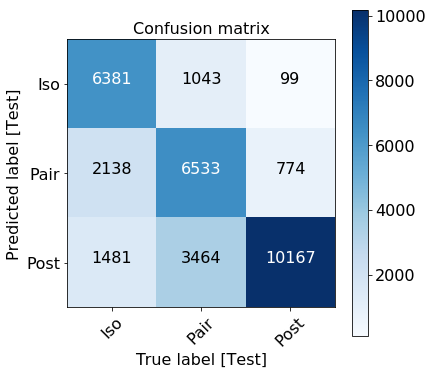

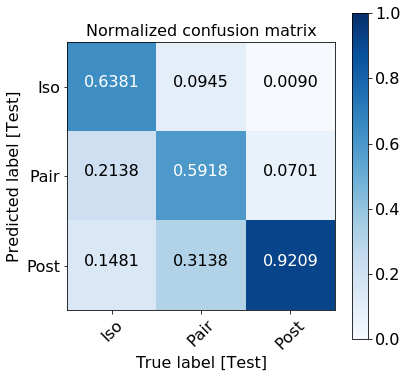

In [2]:
import keras,os,sys,json
from keras import backend as K
from sklearn.metrics import confusion_matrix
from sklearn import model_selection as md
from keras.models import load_model
import matplotlib.pyplot as plt
import itertools
import numpy as np

def mLoad(modelType,randomState,version,update):
    modelDir = '/home/bottrell/scratch/RealCNN/MultiClass/Models/'
    modelFile = '{}{}_MultiClass_RS-{}_v{}_{}.h5'
    modelFile = modelFile.format(modelDir,modelType,randomState,update,version)
    return load_model(modelFile)

def dLoad(dataType):
    dataDir = '/home/bottrell/scratch/RealCNN/MultiClass/Data/'
    labels = ['Iso','Pair','Post']
    dataFile = '{}{}-{}-InpAugNorm.npy'
    dataFiles = [dataFile.format(dataDir,label,dataType) for label in labels]
    for label,dataFile in enumerate(dataFiles):
        if dataFile is dataFiles[0]:
            inp = np.load(dataFile)
            tar = np.ones(inp.shape[0])*label
        else:
            data = np.load(dataFile)
            inp = np.concatenate((inp,data),axis=0)
            tar = np.concatenate((tar,np.ones(data.shape[0])*label))
    tar = tar.astype(int)
    return inp,tar

def cLoad(dataType):
    catDir = '/home/bottrell/scratch/RealCNN/MultiClass/Data/'
    labels = ['Iso','Pair','Post']
    catFile = '{}{}-{}_catAugTiming.npy'
    catFiles = [catFile.format(catDir,label,dataType) for label in labels]
    cat = np.concatenate([np.load(catFile) for catFile in catFiles],axis=0)
    return cat

def dSplit(inp,tar,randomState,train_valid_split,valid_test_split):
    # number of records
    nRecords = len(tar)
    # track indices of input array
    idx = np.arange(nRecords)
    # Split training and validation data
    inp_train, inp_valid, tar_train, tar_valid, idx_train, idx_valid = md.train_test_split(inp, tar, idx, test_size=train_valid_split, random_state=randomState)
    # Reserve some validation data as test data
    inp_valid, inp_test, tar_valid, tar_test, idx_valid, idx_test = md.train_test_split(inp_valid, tar_valid, idx_valid, test_size=valid_test_split, random_state=randomState)
    return inp_train,tar_train,idx_train,inp_valid,tar_valid,idx_valid,inp_test,tar_test,idx_test

def dcSplit(inp,tar,cat,randomState,train_valid_split,valid_test_split):
    '''Split both data and catalogs with a given random state.'''
    # number of records
    nRecords = len(tar)
    # track indices of input array
    idx = np.arange(nRecords)
    # Split training and validation data
    inp_train, inp_valid, tar_train, tar_valid, cat_train, cat_valid, idx_train, idx_valid = md.train_test_split(inp, tar, cat, idx, test_size=train_valid_split, random_state=randomState)
    # Reserve some validation data as test data
    inp_valid, inp_test, tar_valid, tar_test, cat_valid, cat_test, idx_valid, idx_test = md.train_test_split(inp_valid, tar_valid, cat_valid, idx_valid, test_size=valid_test_split, random_state=randomState)
    return inp_train,tar_train,cat_train,idx_train,inp_valid,tar_valid,cat_valid,idx_valid,inp_test,tar_test,cat_test,idx_test

def plotCM(ax, cm, classes, update, version,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=0)
        im1 = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    else :
        im1 = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title,fontsize=16)
    cb = plt.colorbar(im1)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('Predicted label [Test]')
    ax.set_xlabel('True label [Test]')

def printCM(out_test_class,tar_test,test_label,model_label,randomState,update,version,savefigs=True,cmap=plt.cm.Blues):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(tar_test, out_test_class).T
    np.set_printoptions(precision=3)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 16
    # Plot non-normalized confusion matrix
    fig,ax = plt.subplots(figsize=(6,6))
    plotCM(ax,cnf_matrix, classes=['Iso','Pair','Post'], update=update, version=version,title='Confusion matrix',cmap=cmap)
    if savefigs:
        fig.savefig('/home/bottrell/scratch/RealCNN/MultiClass/Models/{}_ConfMatrix_{}_RS-{}_v{}_{}.pdf'.format(test_label,model_label,randomState,update,version),bbox_inches='tight')
    ## Plot normalized confusion matrix
    fig,ax = plt.subplots(figsize=(6,6))
    plotCM(ax,cnf_matrix, classes=['Iso','Pair','Post'], update = update, version=version,normalize=True, title='Normalized confusion matrix',cmap=cmap)
    if savefigs:
        fig.savefig('/home/bottrell/scratch/RealCNN/MultiClass/Models/{}_ConfMatrixNorm_{}_RS-{}_v{}_{}.pdf'.format(test_label,model_label,randomState,update,version),bbox_inches='tight')

randomState = 8
version, update = 0, 0
train_valid_split = 0.3
valid_test_split = 0.5
dx=dy=139

modelType = 'Photometry_FullReal-NC1-r'
m = mLoad(modelType,randomState,version,update)

dataType = 'StellarMap_FullReal'
dataDir = '/home/bottrell/scratch/RealCNN/MultiClass/Data/'
inp,tar = dLoad(dataType)
cat = cLoad(dataType)
nChannels = (1 if (('StellarMap' in modelType) or ('NC1' in modelType)) else 3)
# use i-band of Photometry data when using StellarMap model
if 'StellarMap' in modelType and 'Photometry' in dataType:
    inp = inp[:,2]
inp = inp.reshape(-1,dx,dy,nChannels)

# if data has same type as input, 
if modelType == dataType:
    inp_train,tar_train,cat_train,idx_train,inp_valid,tar_valid,cat_valid,idx_valid,inp_test,tar_test,cat_test,idx_test=dcSplit(inp,tar,cat,randomState,train_valid_split,valid_test_split)
    out_train = np.array(m.predict([inp_train]))
    out_valid = np.array(m.predict([inp_valid]))  
    out_test = np.array(m.predict([inp_test]))
    out_train_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_train])
    out_valid_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_valid])
    out_test_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_test])
else: 
    inp_test = inp
    out_test = np.array(m.predict([inp]))
    out_test_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_test])
    tar_test = tar
    cat_test = cat
    idx_test = np.arange(len(tar))
    
printCM(out_test_class,tar_test,dataType,modelType,randomState,update,version,savefigs=False,cmap=plt.cm.Blues)


In [4]:
print(m.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 139, 139, 1)       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 139, 139, 32)      1184      
_________________________________________________________________
MP_C1 (MaxPooling2D)         (None, 69, 69, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 69, 69, 64)        51264     
_________________________________________________________________
MP_C2 (MaxPooling2D)         (None, 34, 34, 64)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 34, 34, 128)       32896     
_________________________________________________________________
MP_C3 (MaxPooling2D)         (None, 17, 17, 128)       0         
__________

## Produce Images for Confusion Element
A matrix of images is shown for a given target and predicted class (confusion matrix element). Each image is linked to its catalog information which is also indicated in the plots.

4812
134


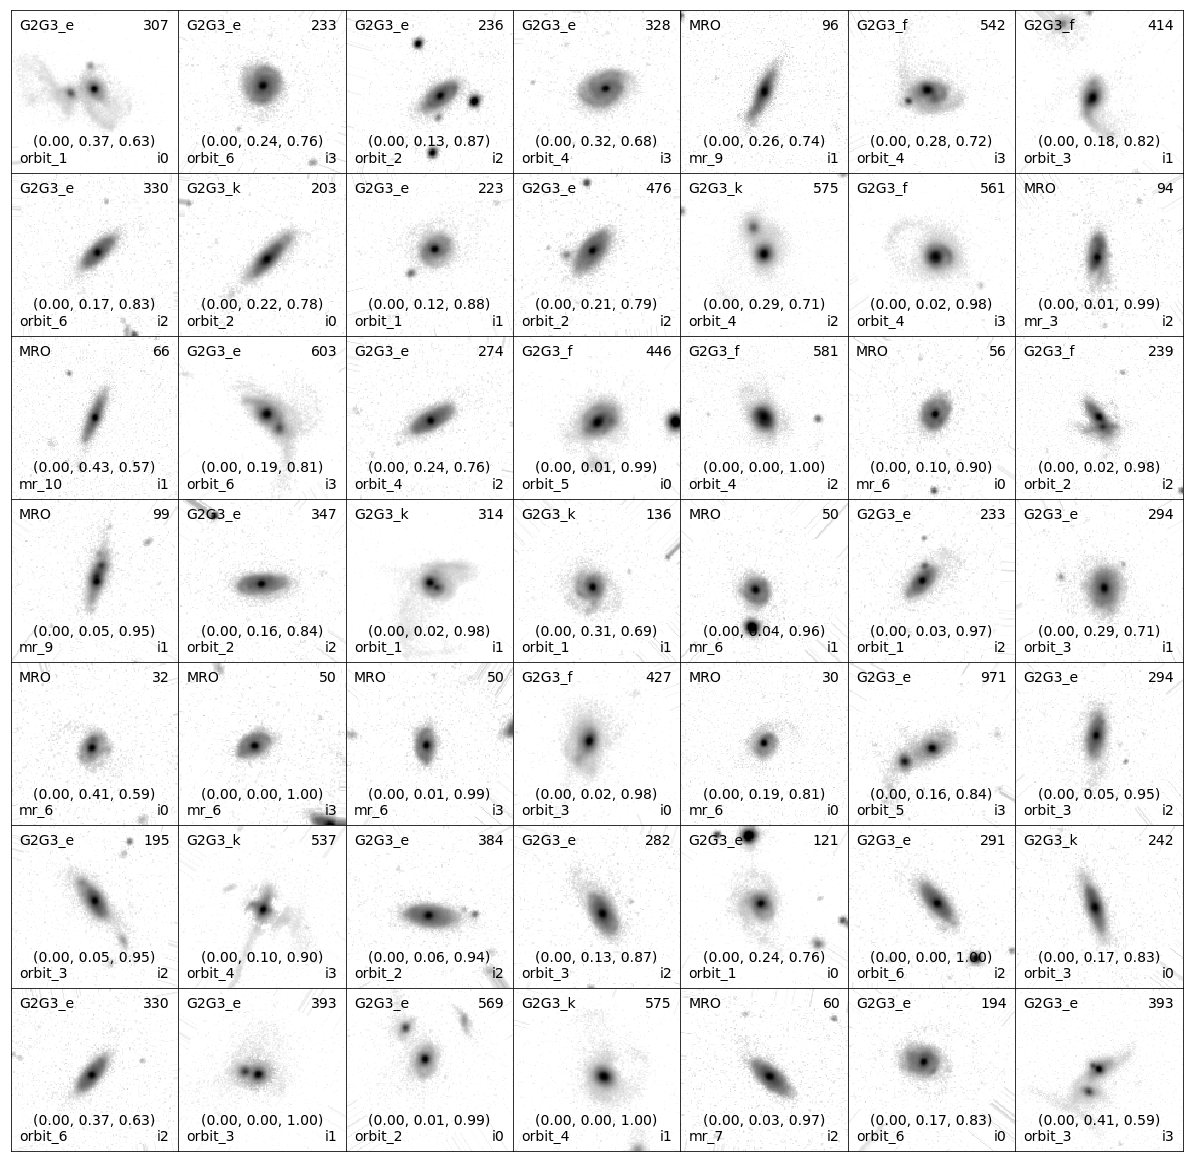

In [9]:
# target class
tar_class = 2
# predicted class
pre_class = 1
idxs = (tar_test==tar_class)*(out_test_class==pre_class)

print(len(idxs))
print(len(idxs[idxs==1]))

nrows = ncols = 7
figureSize=3
nsamples = nrows*ncols
imgs = inp_test[idxs].reshape(-1,nChannels,dx,dy)
infos = cat_test[idxs]
dists = out_test[idxs]
channel = 0

r = np.random.RandomState(seed=1213)
samples = r.choice(imgs.shape[0],size=nsamples,replace=False)
imgs = imgs[samples]
infos = infos[samples]
dists = dists[samples]

fig,axarr = plt.subplots(ncols,nrows,figsize=(ncols*figureSize,ncols*figureSize))
# adjust width and height between boxes
# fig.subplots_adjust(wspace=0,hspace=0)
# a little bit of spacing wrt figsize
fig.subplots_adjust(wspace=0.,hspace=0.)

# In this format, with imshow's aspect='auto', 
# the panels will reformat to rectangular shapes
# if you set wspace!=hspace. I recommend using
# aspect = 'auto' in imshow and keeping wspace
# the same as hspace if you want perfectly square
# panels and alignment.

# You can adjust the wspace and hspace parameters
# when imshow's aspect='equal' (which forces the 
# panel aspect to be equal) but it might require 
# more care in choosing wspace and hspace. 

# Connect indices with catalog numbers


# loop over axes and images
for ax,img,info,dist in zip(axarr.flatten(),imgs,infos,dists):
    # remove ticks and labels x
    ax.tick_params(axis='x',which='both',bottom=False,
                   top=False,labelbottom=False)
    # remove ticks and labels y
    ax.tick_params(axis='y',which='both',left=False,
                   right=False,labelleft=False)
    # plot
    ax.imshow(img[channel],cmap='Greys',vmin=0,vmax=1,aspect='auto')
    
    simTag,subTag,snapId,camera = [ii for ii in info[:4]]
    
    if 'MassRatioOrbits' in simTag:
        simTag = 'MRO'
    if 'mass_ratio' in subTag:
        subTag = subTag.replace('mass_ratio','mr')
        
    ax.text(0.05,0.95,simTag,transform=ax.transAxes,ha='left',va='top',fontsize=14)
    ax.text(0.05,0.05,subTag,transform=ax.transAxes,ha='left',va='bottom',fontsize=14)
    ax.text(0.95,0.95,snapId,transform=ax.transAxes,ha='right',va='top',fontsize=14)
    ax.text(0.95,0.05,camera,transform=ax.transAxes,ha='right',va='bottom',fontsize=14)
    
    ax.text(0.5,0.15,'('+', '.join(['%.2f'%xx for xx in dist])+')',
            transform=ax.transAxes,ha='center',va='bottom',fontsize=14)
    
    # can also force aspect to be 'equal' but you will have 
    # to play with wspace and hspace
    # ax.imshow(img,cmap='Greys',vmin=0,vmax=1,aspect='equal')

fig.savefig('Test-{}-Train-{}-tC-{}-pC-{}.pdf'.format(dataType,modelType,tar_class,pre_class),bbox_inches='tight')

## Show different image types

Example shown is a galaxy in the post-merger sample. The Photometry FullReal image makes it look like it could be a pair.

/home/bottrell/venv/tf36-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log10
/home/bottrell/venv/tf36-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in log10
/home/bottrell/venv/tf36-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in less


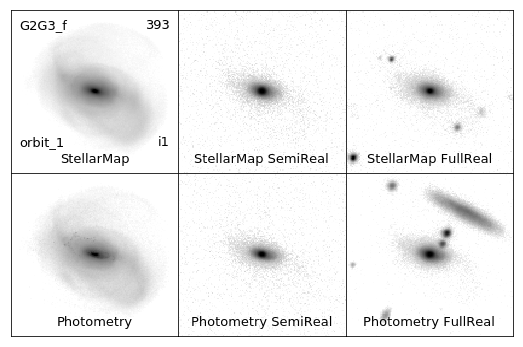

In [23]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 13

fig,axarr = plt.subplots(2,3,figsize=(9,6))
fig.subplots_adjust(hspace=0.,wspace=0.)

for ax in axarr.flatten():
    # remove ticks and labels x
    ax.tick_params(axis='x',which='both',bottom=False,
                   top=False,labelbottom=False)
    # remove ticks and labels y
    ax.tick_params(axis='y',which='both',left=False,
                   right=False,labelleft=False)

simTag = 'G2G3_f'
subTag = 'orbit_1'
snapId = '393'
camera = 'i1'

classID = 'post'
def addLabels(ax,simTag,subTag,snapId,camera):
    ax.text(0.05,0.95,simTag,transform=ax.transAxes,ha='left',va='top')
    ax.text(0.05,0.15,subTag,transform=ax.transAxes,ha='left',va='bottom')
    ax.text(0.95,0.95,snapId,transform=ax.transAxes,ha='right',va='top')
    ax.text(0.95,0.15,camera,transform=ax.transAxes,ha='right',va='bottom')
    
def NormY(x,window=20,is_sky=False):
    # if sky noise is present, subtract sky level
    if is_sky:
        x = x-np.nanmedian(x)
    # take log of skyless image
    x = np.log10(x)
    # get rid of pesky nan values
    x[x<-7]=np.nan
    xc = yc = int(x.shape[-1]/2)
    # compute median
    a_min = np.nanmedian(x)
    dwinx = dwiny = int(window/2)
    # compute upper limit in central window
    a_max = np.nanpercentile(x[xc-dwinx:xc+dwinx,yc-dwiny:yc+dwiny],99)
    # clip/normalize linear image
    x = np.clip(x,a_min=a_min,a_max=a_max)
    x[np.isnan(x)]=a_min
    x = (x - a_min)/(a_max-a_min)
    return x
    


axarr = axarr.flat
imgDir = '/home/bottrell/scratch/Fire/'
altDir = '/home/bottrell/scratch/RealCNN/Fire_Images_CNN/'
classID = 'Post'

ax = axarr[0]
label = 'StellarMap'
#fileName = '{}{}/{}/{}/starmap_i_CNN_{}-{}_{}_{}.fits'.format(imgDir,label,simTag,subTag,simTag,subTag,snapId,camera)
#data = fits.getdata(fileName)
#data = NormY(10**(-0.4*data+22.5))
fileName = '{}{}/{}/starmap_{}-{}_{}_{}.fits'.format(altDir,label,classID,simTag,subTag,snapId,camera)
data = fits.getdata(fileName)
data = NormY(data,is_sky=False)
ax.imshow(data,vmin=0,vmax=1,cmap=plt.cm.Greys,aspect='auto',interpolation='none')
ax.text(0.5,0.05,'StellarMap',transform=ax.transAxes,ha='center',va='bottom',)
            #bbox=dict(boxstyle="round",ec='black',fc='wheat'))
addLabels(ax,simTag,subTag,snapId,camera)


ax = axarr[1]
label = 'StellarMap_SemiReal'
fileName = '{}{}/{}/{}/starmap_i_CNN_{}-{}_{}_{}_sci.fits'.format(imgDir,label,simTag,subTag,simTag,subTag,snapId,camera)
data = fits.getdata(fileName)
data = NormY(data,is_sky=True)
ax.imshow(data,vmin=0,vmax=1,cmap=plt.cm.Greys,aspect='auto',interpolation='none')
ax.text(0.5,0.05,'StellarMap SemiReal',transform=ax.transAxes,ha='center',va='bottom',)
            #bbox=dict(boxstyle="round",ec='black',fc='wheat'))

ax = axarr[2]
label = 'StellarMap_FullReal'
fileName = '{}{}/{}/{}/starmap_i_CNN_{}-{}_{}_{}_sci.fits'.format(imgDir,label,simTag,subTag,simTag,subTag,snapId,camera)
data = fits.getdata(fileName)
data = NormY(data,is_sky=True)
ax.imshow(data,vmin=0,vmax=1,cmap=plt.cm.Greys,aspect='auto',interpolation='none')
ax.text(0.5,0.05,'StellarMap FullReal',transform=ax.transAxes,ha='center',va='bottom',)
           # bbox=dict(boxstyle="round",ec='black',fc='wheat'))



ax = axarr[3]
label = 'Photometry'
# fileName = '{}{}/{}/{}/photo_i_CNN_{}-{}_{}_{}_total.fits'.format(imgDir,label,simTag,subTag,simTag,subTag,snapId,camera)
# data = fits.getdata(fileName)
# data = NormY(10**(-0.4*data+22.5),is_sky=False)
fileName = '{}{}/{}/photo_i_CNN_{}-{}_{}_{}_total.fits'.format(altDir,label,classID,simTag,subTag,snapId,camera)
data = fits.getdata(fileName)
data = NormY(data,is_sky=False)
ax.imshow(data,vmin=0,vmax=1,cmap=plt.cm.Greys,aspect='auto',interpolation='none')
ax.text(0.5,0.05,'Photometry',transform=ax.transAxes,ha='center',va='bottom',)
            #bbox=dict(boxstyle="round",ec='black',fc='wheat'))



ax = axarr[4]
label = 'Photometry_SemiReal'
fileName = '{}{}/{}/{}/photo_i_CNN_{}-{}_{}_{}_sci.fits'.format(imgDir,label,simTag,subTag,simTag,subTag,snapId,camera)
data = fits.getdata(fileName)
data = NormY(data,is_sky=True)
ax.imshow(data,vmin=0,vmax=1,cmap=plt.cm.Greys,aspect='auto',interpolation='none')
ax.text(0.5,0.05,'Photometry SemiReal',transform=ax.transAxes,ha='center',va='bottom',)
            #bbox=dict(boxstyle="round",ec='black',fc='wheat'))


ax = axarr[5]
label = 'Photometry_FullReal'
fileName = '{}{}/{}/{}/photo_r_CNN_{}-{}_{}_{}_sci.fits'.format(imgDir,label,simTag,subTag,simTag,subTag,snapId,camera)
data = fits.getdata(fileName)
data = NormY(data,is_sky=True)
ax.imshow(data,vmin=0,vmax=1,cmap=plt.cm.Greys,aspect='auto',interpolation='none')
ax.text(0.5,0.05,'Photometry FullReal',transform=ax.transAxes,ha='center',va='bottom',)
        #bbox=dict(boxstyle="round",ec='black',fc='wheat'))


fig.savefig('/home/bottrell/scratch/RealCNN/MultiClass/Figures/Bad_Projection-iband_idealLow.pdf',bbox_inches='tight')
fig.savefig('/home/bottrell/scratch/RealCNN/MultiClass/Figures/Bad_Projection-iband_idealLow.png',dpi=1024,bbox_inches='tight')


## Produce timing PDF for confusion matrix element

Using the new file 'galSep_Timelines.npy' created on wolf, we can compute the time offsets from first pericentric passage, second pericentric passage and coalescence with respect to the timestamp for each snapshot in the GalSep files. In particular, this next cell will generate the PDF of time stamps for a given confusion matrix element. 

/home/bottrell/venv/tf36-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.


199


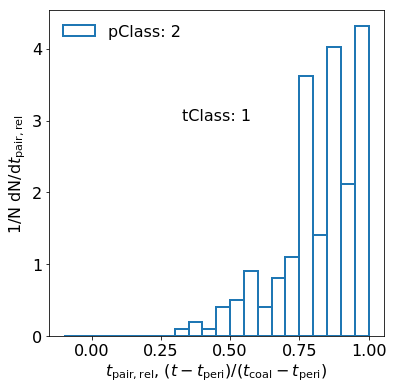

In [85]:
# target class
tar_class = 1
# predicted class
pre_class = 2

dx = dy = 139

fig,ax = plt.subplots(figsize=(6,6))
xedges = np.linspace(-0.1,1,23)
widths = np.median(xedges[1:]-xedges[:-1])
ax.set_ylabel(r'1/N dN/d$t_{\mathrm{pair,rel}}$')
ax.set_xlabel(r'$t_{\mathrm{pair,rel}}$, $(t-t_{\mathrm{peri}})/(t_{\mathrm{coal}}-t_{\mathrm{peri}})$')
ax.text(0.5,0.7,'tClass: {}'.format(tar_class),transform=ax.transAxes,ha='center',va='top')

for pre_class,colour in zip([pre_class,],['C0',]): #,1,2],['C0','black','C1']):
    
    idxs = (tar_test==tar_class)*(out_test_class==pre_class)
    imgs = inp_test[idxs].reshape(-1,nChannels,dx,dy)
    infos = cat_test[idxs]
    dists = out_test[idxs]
    channel = 0

    times = infos[:,4].astype(float)
    tPeris = infos[:,5].astype(float)
    tCoals = infos[:,7].astype(float)

    tRel = (times-tPeris)/(tCoals-tPeris)
    tRel[tRel<-0.1] = 0.1
    tRel[tRel>1] = 1

    H,xedges = np.histogram(tRel,bins=xedges,normed=False)
    ax.bar(x=xedges[:-1],height=H/np.sum(H)/widths,width=widths,align='edge',
           ec=colour,lw=2,color='None',label='pClass: {}'.format(pre_class))


#ax.text(0.5,0.85,'Pre Class: {}'.format(pre_class),transform=ax.transAxes,ha='center',va='top')


ax.legend(frameon=False)
print(np.sum(H))

/home/bottrell/venv/tf36-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
No handles with labels found to put in legend.


[0.782 0.196 0.489 ... 0.342 0.352 0.147]
1566


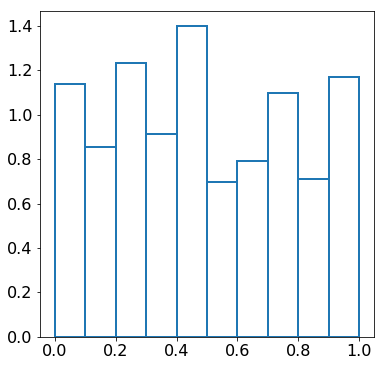

In [5]:
# target class
tar_class = 2
# predicted class
pre_class = 2

dx = dy = 139

fig,ax = plt.subplots(figsize=(6,6))
xedges = np.linspace(0,1,11)
widths = np.median(xedges[1:]-xedges[:-1])
#ax.set_ylabel(r'1/N dN/d$t_{\mathrm{pair,rel}}$')
#ax.set_xlabel(r'$t_{\mathrm{pair,rel}}$, $(t-t_{\mathrm{peri}})/(t_{\mathrm{coal}}-t_{\mathrm{peri}})$')
#ax.text(0.5,0.7,'tClass: {}'.format(tar_class),transform=ax.transAxes,ha='center',va='top')

for pre_class,colour in zip([pre_class,],['C0',]): #,1,2],['C0','black','C1']):
    
    idxs = (tar_test==tar_class)*(out_test_class==pre_class)
    infos = cat_test[idxs]
    dists = out_test[idxs]
    channel = 0

    times = infos[:,4].astype(float)
    
    tCoals = infos[:,7].astype(float)
    tLast = tCoals+0.5 

    tRel = (times-tCoals)/(tLast-tCoals)
    
    print(tRel)


    H,xedges = np.histogram(tRel,bins=xedges,normed=False)
    ax.bar(x=xedges[:-1],height=H/np.sum(H)/widths,width=widths,align='edge',
           ec=colour,lw=2,color='None')#label='pClass: {}'.format(pre_class))


#ax.text(0.5,0.85,'Pre Class: {}'.format(pre_class),transform=ax.transAxes,ha='center',va='top')


ax.legend(frameon=False)
print(np.sum(H))

/home/bottrell/venv/tf36-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/home/bottrell/venv/tf36-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


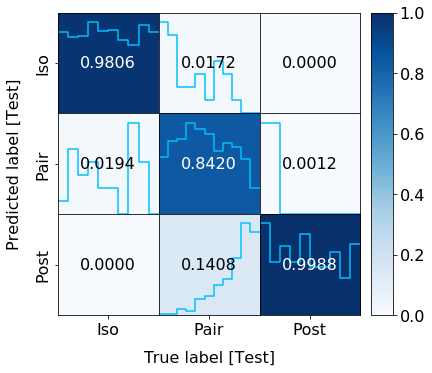

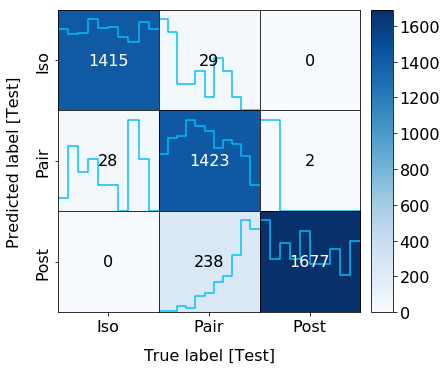

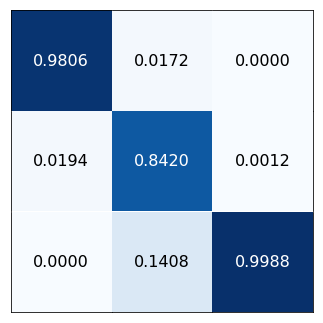

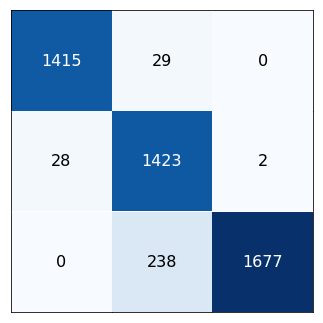

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def _InsetIsoPDF(tarClass,preClass,out_test_class,tar_test,cat_test,axis,xmin=0):
    idxs = (tar_test==tarClass)*(out_test_class==preClass)
    infos = cat_test[idxs]
    xedges = np.linspace(0,1,11)
    lefts =  np.linspace(-0.1,1,11)
    widths = xedges[1:]-xedges[:-1]
    # snapshot times
    times = infos[:,4].astype(float)
    subTags = infos[:,1].astype(str)
    endTimes = np.zeros(len(times))
    endTimes[subTags=='G1']=4.6
    endTimes[subTags=='G2']=4.6
    endTimes[subTags=='G3']=4.0
    endTimes[subTags=='G4']=1.5
    tRel = times / endTimes
    # clip outside edges
    tRel = np.clip(tRel,a_min=0,a_max=1.)
    H,xedges = np.histogram(tRel,bins=xedges,density=False)
    y = H/np.max(H)
    y = np.insert(y,-1,y[-1])
    axis.step(x=lefts,y=y-0.1,where='post',lw=1.5,color='deepskyblue',zorder=2)
    return xedges,H

def _InsetPairPDF(tarClass,preClass,out_test_class,tar_test,cat_test,axis,xmin=0):
    idxs = (tar_test==tarClass)*(out_test_class==preClass)
    infos = cat_test[idxs]
    xedges = np.linspace(-0.1,1,12)
    lefts = xedges
    widths = xedges[1:]-xedges[:-1]
    # snapshot times
    times = infos[:,4].astype(float)
    # pericenter times
    tPeris = infos[:,5].astype(float)
    # coalescence times
    tCoals = infos[:,7].astype(float)
    # relative pair stage
    tRel = (times-tPeris)/(tCoals-tPeris)
    # clip outside edges
    tRel = np.clip(tRel,a_min=-0.1,a_max=1.)
    H,xedges = np.histogram(tRel,bins=xedges,density=False)
    y = H/np.max(H)
    y = np.insert(y,-1,y[-1])
    axis.step(x=lefts,y=y-0.1,where='post',lw=1.5,color='deepskyblue',zorder=2)
    return xedges,H
    
def _InsetPostPDF(tarClass,preClass,out_test_class,tar_test,cat_test,axis,xmin=0):
    idxs = (tar_test==tarClass)*(out_test_class==preClass)
    infos = cat_test[idxs]
    xedges = np.linspace(0,1,11)
    lefts =  np.linspace(-0.1,1,11)
    widths = xedges[1:]-xedges[:-1]
    # snapshot times
    times = infos[:,4].astype(float)
    # coalescence times
    tCoals = infos[:,7].astype(float)
    # "end" of post merger phase 500 Myr
    tLast = tCoals+0.5
    # relative pair stage
    tRel = (times-tCoals)/(tLast-tCoals)
    # clip outside edges
    tRel = np.clip(tRel,a_min=0,a_max=1.)
    H,xedges = np.histogram(tRel,bins=xedges,density=False)
    y = H/np.max(H)
    y = np.insert(y,-1,y[-1])
    axis.step(x=lefts,y=y-0.1,where='post',lw=1.5,color='deepskyblue',zorder=2)
    return xedges,H


def Confusion(out_test_class,tar_test,classIDs,cat_test=None,normalize=True,
              colourbar=False,spines=True,ticklabels=False,cmap='Blues',
              labelbottom=True,labelleft=True,InsetIsoPDF=False,InsetPairPDF=False,InsetPostPDF=False):

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(tar_test, out_test_class).T
    cnf_shape = cnf_matrix.shape[0]
    
    # Normalize if necessary, define vmin vmax
    if normalize:
        vmin,vmax=0,1
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=0)
    else:
        vmin,vmax=0,np.max(cnf_matrix.sum(axis=0))
    
    # set up plot playground
    fig,axarr = plt.subplots(cnf_shape,cnf_shape,figsize=(6,6))
    fig.subplots_adjust(bottom=0.15,top=0.85,left=0.15,right=0.85,wspace=0.,hspace=0.)
    fmt = '.4f' if normalize else 'd'
    thresh = vmax / 2.
    np.set_printoptions(precision=3)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 16
    xmin,xmax = -0.1,1
    xmid = (xmax-xmin)/2+xmin

    # loop over axes and confusion elements
    for ax,cnf_el in zip(axarr.flatten(),cnf_matrix.flatten()):
        # remove ticks and labels x
        ax.tick_params(axis='x',which='both',bottom=False,
                       top=False,labelbottom=False)
        # remove ticks and labels y
        ax.tick_params(axis='y',which='both',left=False,
                       right=False,labelleft=False)
        im = ax.imshow([[cnf_el]],vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto',extent=[xmin,xmax,xmin,xmax])
        ax.text(0.5,0.5,format(cnf_el,fmt),transform=ax.transAxes,
                ha='center',va='center',color=('white' if cnf_el>thresh else 'black'))
        
        if not spines:
            # turn off all spines first
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
    
    # add spines to border elements
    for i in range(cnf_shape):
        for j in range(cnf_shape):
            if i==0:
                axarr[j,i].spines['left'].set_visible(True)
            if j==0:
                axarr[j,i].spines['top'].set_visible(True)
            if i==cnf_shape-1:
                axarr[j,i].spines['right'].set_visible(True)
            if j==cnf_shape-1:
                axarr[j,i].spines['bottom'].set_visible(True)
        
    if colourbar:
        # make/keep square
        cbar_ax = fig.add_axes([0.875, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)
          
    if ticklabels:
        for i,classID in enumerate(classIDs):

            axarr[-1,i].tick_params(axis='x',which='both',bottom=True,
                           top=False,labelbottom=True)
            axarr[i,0].tick_params(axis='y',which='both',left=True,
                           right=False,labelleft=True)
            
            axarr[-1,i].set_xticks([xmid])
            axarr[-1,i].set_xticklabels([classID],rotation=0)
            axarr[i,0].set_yticks([xmid])
            axarr[i,0].set_yticklabels([classID],rotation=90,ha='right',va='center')
            
    if labelbottom:
        fig.text(0.5, 0.05, 'True label [Test]', ha='center', va='center')
        
    if labelleft:
        fig.text(0.05, 0.5, 'Predicted label [Test]', ha='center', va='center', rotation='vertical')
        
    if InsetIsoPDF:
        xiso = np.empty((3,11))
        hiso = np.empty((3,10))
        for i in range(3):
            for j in range(3):
                if j==0:
                    axarr[i,j].autoscale(False)
                    xiso[i,:],hiso[i,:]=_InsetIsoPDF(j,i,out_test_class,tar_test,cat_test,axarr[i,j],xmin=xmin)
        
    if InsetPairPDF:
        xpair = np.empty((3,12))
        hpair = np.empty((3,11))
        for i in range(3):
            for j in range(3):
                if j==1:
                    axarr[i,j].autoscale(False)
                    xpair[i,:],hpair[i,:]=_InsetPairPDF(j,i,out_test_class,tar_test,cat_test,axarr[i,j],xmin=xmin)
        
    if InsetPostPDF:
        xpost = np.empty((3,11))
        hpost = np.empty((3,10))
        for i in range(3):
            for j in range(3):
                if j==2:
                    axarr[i,j].autoscale(False)
                    xpost[i,:],hpost[i,:]=_InsetPostPDF(j,i,out_test_class,tar_test,cat_test,axarr[i,j],xmin=xmin)
        
    if InsetIsoPDF and InsetPairPDF and InsetPostPDF:
        return fig,cnf_matrix,xiso,hiso,xpair,hpair,xpost,hpost
    elif InsetPairPDF and not (InsetPostPDF or InsetIsoPDF):
        return fig,cnf_matrix,xpair,hpair
    elif InsetPostPDF and not (InsetPairPDF or InsetIsoPDF):
        return fig,cnf_matrix,xpost,hpost
    elif InsetIsoPDF and not (InsetPairPDF or InsetPostPDF):
        return fig,cnf_matrix,xiso,hiso
    elif (InsetIsoPDF and InsetPairPDF) and not InsetPostPDF:
        return fig,cnf_matrix,xiso,hiso,xpair,hpair
    elif (InsetIsoPDF and InsetPostPDF) and not InsetPairPDF:
        return fig,cnf_matrix,xiso,hiso,xpost,hpost
    elif (InsetPairPDF and InsetPostPDF) and not InsetIsoPDF:
        return fig,cnf_matrix,xpair,hpair,xpost,hpost
    else:
        return fig,cnf_matrix
        

# needed for labels
classIDs = ['Iso','Pair','Post']

# save figures with axes handles
fig,cnfNorm,xiso,hiso,xpair,hpair,xpost,hpost = Confusion(out_test_class,tar_test,classIDs,cat_test=cat_test,
                                                   normalize=True,colourbar=True,spines=True,ticklabels=True,
                                                   cmap='Blues',labelbottom=True,labelleft=True,InsetIsoPDF=True,InsetPairPDF=True,
                                                   InsetPostPDF=True)
figName = 'MultiClass/Figures/ConfMatrixNormPDF_Test-{}-Train-{}-RS-{}-{}-v{}.pdf'.format(dataType,modelType,randomState,update,version)
fig.savefig(figName,bbox_inches='tight')

fig,cnf,xiso,hiso,xpair,hpair,xpost,hpost = Confusion(out_test_class,tar_test,classIDs,cat_test=cat_test,
                                                   normalize=False,colourbar=True,spines=True,ticklabels=True,
                                                   cmap='Blues',labelbottom=True,labelleft=True,InsetIsoPDF=True,InsetPairPDF=True,
                                                   InsetPostPDF=True)
figName = 'MultiClass/Figures/ConfMatrixPDF_Test-{}-Train-{}-RS-{}-{}-v{}.pdf'.format(dataType,modelType,randomState,update,version)
fig.savefig(figName,bbox_inches='tight')

# save all info from figures for statistics (including PDFs)
datName = 'MultiClass/Models/ConfMatrix-Test-{}-Train-{}-RS-{}-{}-v{}.npz'.format(dataType,modelType,randomState,update,version)
np.savez_compressed(datName,cnf=cnf,cnfNorm=cnfNorm,xiso=xiso,hiso=hiso,xpair=xpair,hpair=hpair,xpost=xpost,hpost=hpost)

# save figures without axes handles
fig,cnf = Confusion(out_test_class,tar_test,classIDs,cat_test=cat_test,
                                                   normalize=True,colourbar=False,spines=False,ticklabels=False,
                                                   cmap='Blues',labelbottom=False,labelleft=False,InsetIsoPDF=False,InsetPairPDF=False,
                                                   InsetPostPDF=False)
figName = 'MultiClass/Figures/ConfMatrixNorm_Test-{}-Train-{}-RS-{}-{}-v{}.pdf'.format(dataType,modelType,randomState,update,version)
fig.savefig(figName,bbox_inches='tight')

fig,cnf = Confusion(out_test_class,tar_test,classIDs,cat_test=cat_test,
                                                   normalize=False,colourbar=False,spines=False,ticklabels=False,
                                                   cmap='Blues',labelbottom=False,labelleft=False,InsetIsoPDF=False,InsetPairPDF=False,
                                                   InsetPostPDF=False)
figName = 'MultiClass/Figures/ConfMatrix_Test-{}-Train-{}-RS-{}-{}-v{}.pdf'.format(dataType,modelType,randomState,update,version)
fig.savefig(figName,bbox_inches='tight')



## Generate confusion matrix plots and datafiles

Generate confusion matrix figures and compressed data files for all mergers. The compressed data can then be used to generate confidence intervals for the confusion matrix elements based on the 10 bootstraps for each test. Now in the TestAllModelsAndPlot.py file.

/home/bottrell/venv/tf36-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in true_divide
/home/bottrell/venv/tf36-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in true_divide


InternalError: Dst tensor is not initialized.
	 [[{{node _arg_Placeholder_2104_0_4}}]]
	 [[node Assign_2100 (defined at /home/bottrell/venv/tf36-gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2465) ]]

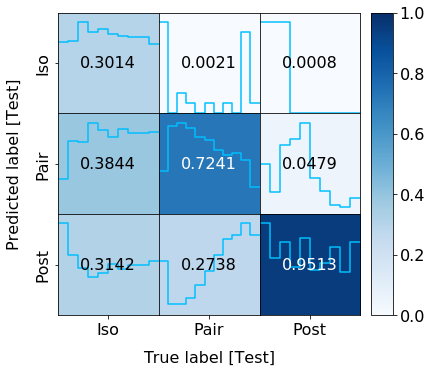

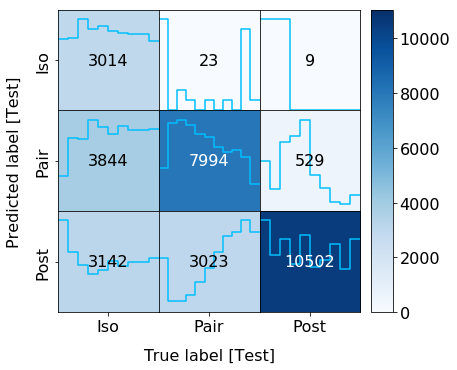

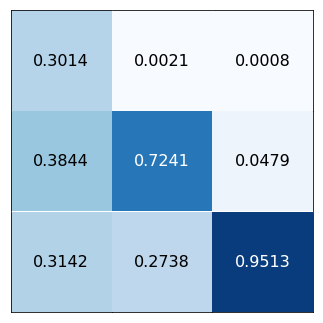

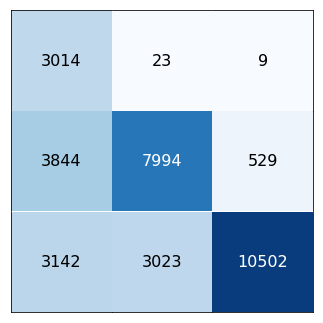

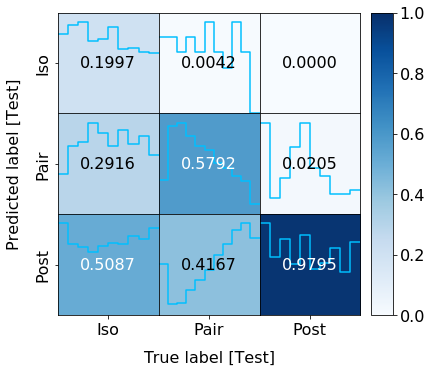

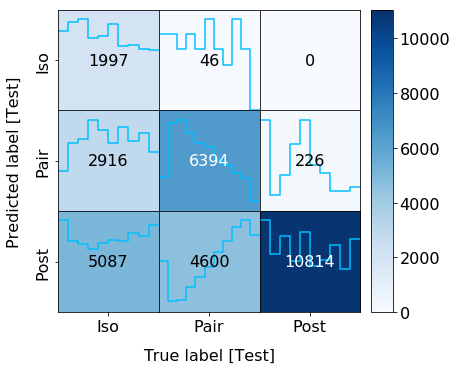

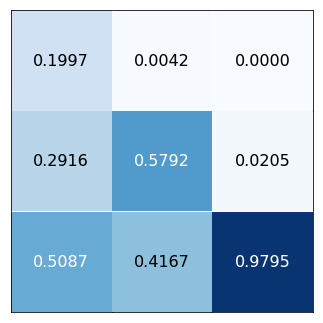

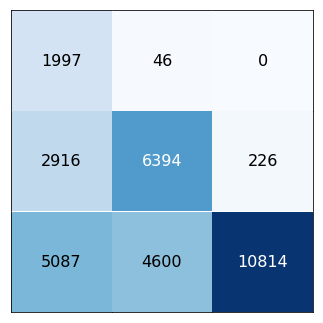

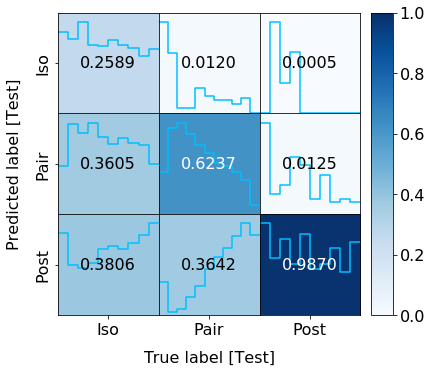

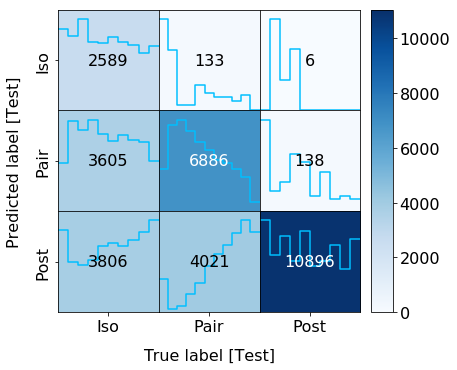

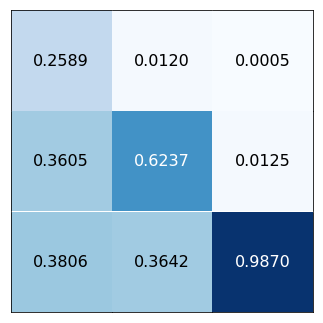

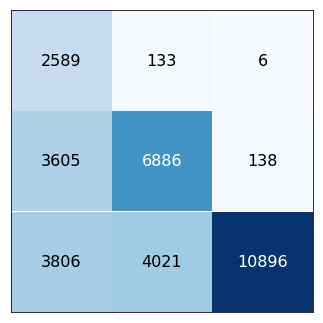

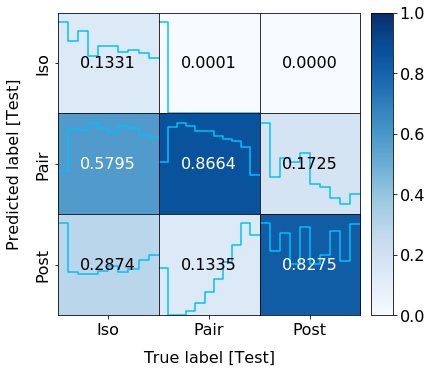

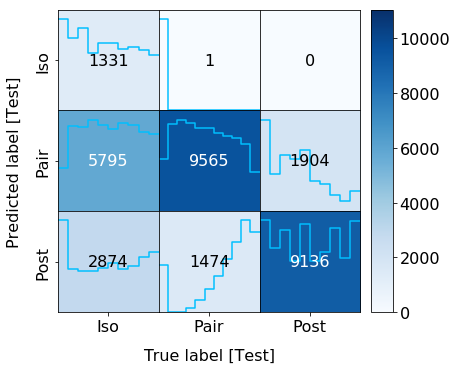

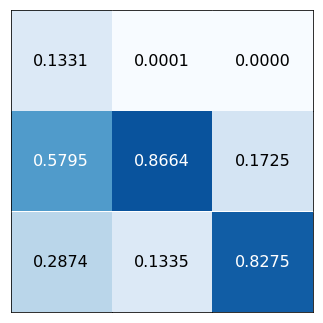

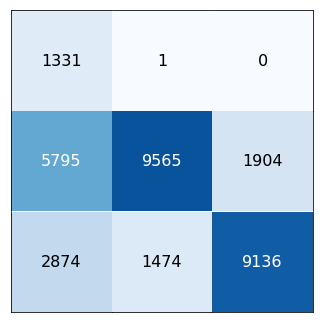

In [14]:
#!/usr/bin/env python

import keras,os,sys,json
from keras import backend as K
from sklearn.metrics import confusion_matrix
from sklearn import model_selection as md
from keras.models import load_model
import matplotlib.pyplot as plt
import itertools
import numpy as np

def mLoad(modelType,randomState,version,update):
    modelDir = '/home/bottrell/scratch/RealCNN/MultiClass/Models/'
    modelFile = '{}{}_MultiClass_RS-{}_v{}_{}.h5'
    modelFile = modelFile.format(modelDir,modelType,randomState,update,version)
    return load_model(modelFile)

def dLoad(dataType):
    dataDir = '/home/bottrell/scratch/RealCNN/MultiClass/Data/'
    labels = ['Iso','Pair','Post']
    dataFile = '{}{}-{}-InpAugNorm.npy'
    dataFiles = [dataFile.format(dataDir,label,dataType) for label in labels]
    for label,dataFile in enumerate(dataFiles):
        if dataFile is dataFiles[0]:
            inp = np.load(dataFile)
            tar = np.ones(inp.shape[0])*label
        else:
            data = np.load(dataFile)
            inp = np.concatenate((inp,data),axis=0)
            tar = np.concatenate((tar,np.ones(data.shape[0])*label))
    tar = tar.astype(int)
    return inp,tar

def cLoad(dataType):
    catDir = '/home/bottrell/scratch/RealCNN/MultiClass/Data/'
    labels = ['Iso','Pair','Post']
    catFile = '{}{}-{}_catAugTiming.npy'
    catFiles = [catFile.format(catDir,label,dataType) for label in labels]
    cat = np.concatenate([np.load(catFile) for catFile in catFiles],axis=0)
    return cat

def dSplit(inp,tar,randomState,train_valid_split,valid_test_split):
    # number of records
    nRecords = len(tar)
    # track indices of input array
    idx = np.arange(nRecords)
    # Split training and validation data
    inp_train, inp_valid, tar_train, tar_valid, idx_train, idx_valid = md.train_test_split(inp, tar, idx, test_size=train_valid_split, random_state=randomState)
    # Reserve some validation data as test data
    inp_valid, inp_test, tar_valid, tar_test, idx_valid, idx_test = md.train_test_split(inp_valid, tar_valid, idx_valid, test_size=valid_test_split, random_state=randomState)
    return inp_train,tar_train,idx_train,inp_valid,tar_valid,idx_valid,inp_test,tar_test,idx_test

def dcSplit(inp,tar,cat,randomState,train_valid_split,valid_test_split):
    '''Split both data and catalogs with a given random state.'''
    # number of records
    nRecords = len(tar)
    # track indices of input array
    idx = np.arange(nRecords)
    # Split training and validation data
    inp_train, inp_valid, tar_train, tar_valid, cat_train, cat_valid, idx_train, idx_valid = md.train_test_split(inp, tar, cat, idx, test_size=train_valid_split, random_state=randomState)
    # Reserve some validation data as test data
    inp_valid, inp_test, tar_valid, tar_test, cat_valid, cat_test, idx_valid, idx_test = md.train_test_split(inp_valid, tar_valid, cat_valid, idx_valid, test_size=valid_test_split, random_state=randomState)
    return inp_train,tar_train,cat_train,idx_train,inp_valid,tar_valid,cat_valid,idx_valid,inp_test,tar_test,cat_test,idx_test

def plotCM(ax, cm, classes, update, version,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=0)
        im1 = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    else :
        im1 = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title,fontsize=16)
    cb = plt.colorbar(im1)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('Predicted label [Test]')
    ax.set_xlabel('True label [Test]')

def printCM(out_test_class,tar_test,test_label,model_label,randomState,update,version,savefigs=True,cmap=plt.cm.Blues):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(tar_test, out_test_class).T
    np.set_printoptions(precision=3)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 16
    # Plot non-normalized confusion matrix
    fig,ax = plt.subplots(figsize=(6,6))
    plotCM(ax,cnf_matrix, classes=['Iso','Pair','Post'], update=update, version=version,title='Confusion matrix',cmap=cmap)
    if savefigs:
        fig.savefig('/home/bottrell/scratch/RealCNN/MultiClass/Models/{}_ConfMatrix_{}_RS-{}_v{}_{}.pdf'.format(test_label,model_label,randomState,update,version),bbox_inches='tight')
    ## Plot normalized confusion matrix
    fig,ax = plt.subplots(figsize=(6,6))
    plotCM(ax,cnf_matrix, classes=['Iso','Pair','Post'], update = update, version=version,normalize=True, title='Normalized confusion matrix',cmap=cmap)
    if savefigs:
        fig.savefig('/home/bottrell/scratch/RealCNN/MultiClass/Models/{}_ConfMatrixNorm_{}_RS-{}_v{}_{}.pdf'.format(test_label,model_label,randomState,update,version),bbox_inches='tight')

def _InsetIsoPDF(tarClass,preClass,out_test_class,tar_test,cat_test,axis,xmin=0):
    idxs = (tar_test==tarClass)*(out_test_class==preClass)
    infos = cat_test[idxs]
    xedges = np.linspace(0,1,11)
    lefts =  np.linspace(-0.1,1,11)
    widths = xedges[1:]-xedges[:-1]
    # snapshot times
    times = infos[:,4].astype(float)
    subTags = infos[:,1].astype(str)
    endTimes = np.zeros(len(times))
    endTimes[subTags=='G1']=4.6
    endTimes[subTags=='G2']=4.6
    endTimes[subTags=='G3']=4.0
    endTimes[subTags=='G4']=1.5
    tRel = times / endTimes
    # clip outside edges
    tRel = np.clip(tRel,a_min=0,a_max=1.)
    H,xedges = np.histogram(tRel,bins=xedges,density=False)
    y = H/np.max(H)
    y = np.insert(y,-1,y[-1])
    axis.step(x=lefts,y=y-0.1,where='post',lw=1.5,color='deepskyblue',zorder=2)
    return xedges,H

def _InsetPairPDF(tarClass,preClass,out_test_class,tar_test,cat_test,axis,xmin=0):
    idxs = (tar_test==tarClass)*(out_test_class==preClass)
    infos = cat_test[idxs]
    xedges = np.linspace(-0.1,1,12)
    lefts = xedges
    widths = xedges[1:]-xedges[:-1]
    # snapshot times
    times = infos[:,4].astype(float)
    # pericenter times
    tPeris = infos[:,5].astype(float)
    # coalescence times
    tCoals = infos[:,7].astype(float)
    # relative pair stage
    tRel = (times-tPeris)/(tCoals-tPeris)
    # clip outside edges
    tRel = np.clip(tRel,a_min=-0.1,a_max=1.)
    H,xedges = np.histogram(tRel,bins=xedges,density=False)
    y = H/np.max(H)
    y = np.insert(y,-1,y[-1])
    axis.step(x=lefts,y=y-0.1,where='post',lw=1.5,color='deepskyblue',zorder=2)
    return xedges,H
    
def _InsetPostPDF(tarClass,preClass,out_test_class,tar_test,cat_test,axis,xmin=0):
    idxs = (tar_test==tarClass)*(out_test_class==preClass)
    infos = cat_test[idxs]
    xedges = np.linspace(0,1,11)
    lefts =  np.linspace(-0.1,1,11)
    widths = xedges[1:]-xedges[:-1]
    # snapshot times
    times = infos[:,4].astype(float)
    # coalescence times
    tCoals = infos[:,7].astype(float)
    # "end" of post merger phase 500 Myr
    tLast = tCoals+0.5
    # relative pair stage
    tRel = (times-tCoals)/(tLast-tCoals)
    # clip outside edges
    tRel = np.clip(tRel,a_min=0,a_max=1.)
    H,xedges = np.histogram(tRel,bins=xedges,density=False)
    y = H/np.max(H)
    y = np.insert(y,-1,y[-1])
    axis.step(x=lefts,y=y-0.1,where='post',lw=1.5,color='deepskyblue',zorder=2)
    return xedges,H


def Confusion(out_test_class,tar_test,classIDs,cat_test=None,normalize=True,
              colourbar=False,spines=True,ticklabels=False,cmap='Blues',
              labelbottom=True,labelleft=True,InsetIsoPDF=False,InsetPairPDF=False,InsetPostPDF=False):

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(tar_test, out_test_class).T
    cnf_shape = cnf_matrix.shape[0]
    
    # Normalize if necessary, define vmin vmax
    if normalize:
        vmin,vmax=0,1
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=0)
    else:
        vmin,vmax=0,np.max(cnf_matrix.sum(axis=0))
    
    # set up plot playground
    fig,axarr = plt.subplots(cnf_shape,cnf_shape,figsize=(6,6))
    fig.subplots_adjust(bottom=0.15,top=0.85,left=0.15,right=0.85,wspace=0.,hspace=0.)
    fmt = '.4f' if normalize else 'd'
    thresh = vmax / 2.
    np.set_printoptions(precision=3)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 16
    xmin,xmax = -0.1,1
    xmid = (xmax-xmin)/2+xmin

    # loop over axes and confusion elements
    for ax,cnf_el in zip(axarr.flatten(),cnf_matrix.flatten()):
        # remove ticks and labels x
        ax.tick_params(axis='x',which='both',bottom=False,
                       top=False,labelbottom=False)
        # remove ticks and labels y
        ax.tick_params(axis='y',which='both',left=False,
                       right=False,labelleft=False)
        im = ax.imshow([[cnf_el]],vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto',extent=[xmin,xmax,xmin,xmax])
        ax.text(0.5,0.5,format(cnf_el,fmt),transform=ax.transAxes,
                ha='center',va='center',color=('white' if cnf_el>thresh else 'black'))
        
        if not spines:
            # turn off all spines first
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
    
    # add spines to border elements
    for i in range(cnf_shape):
        for j in range(cnf_shape):
            if i==0:
                axarr[j,i].spines['left'].set_visible(True)
            if j==0:
                axarr[j,i].spines['top'].set_visible(True)
            if i==cnf_shape-1:
                axarr[j,i].spines['right'].set_visible(True)
            if j==cnf_shape-1:
                axarr[j,i].spines['bottom'].set_visible(True)
        
    if colourbar:
        # make/keep square
        cbar_ax = fig.add_axes([0.875, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)
          
    if ticklabels:
        for i,classID in enumerate(classIDs):

            axarr[-1,i].tick_params(axis='x',which='both',bottom=True,
                           top=False,labelbottom=True)
            axarr[i,0].tick_params(axis='y',which='both',left=True,
                           right=False,labelleft=True)
            
            axarr[-1,i].set_xticks([xmid])
            axarr[-1,i].set_xticklabels([classID],rotation=0)
            axarr[i,0].set_yticks([xmid])
            axarr[i,0].set_yticklabels([classID],rotation=90,ha='right',va='center')
            
    if labelbottom:
        fig.text(0.5, 0.05, 'True label [Test]', ha='center', va='center')
        
    if labelleft:
        fig.text(0.05, 0.5, 'Predicted label [Test]', ha='center', va='center', rotation='vertical')
        
    if InsetIsoPDF:
        xiso = np.empty((3,11))
        hiso = np.empty((3,10))
        for i in range(3):
            for j in range(3):
                if j==0:
                    axarr[i,j].autoscale(False)
                    xiso[i,:],hiso[i,:]=_InsetIsoPDF(j,i,out_test_class,tar_test,cat_test,axarr[i,j],xmin=xmin)
        
    if InsetPairPDF:
        xpair = np.empty((3,12))
        hpair = np.empty((3,11))
        for i in range(3):
            for j in range(3):
                if j==1:
                    axarr[i,j].autoscale(False)
                    xpair[i,:],hpair[i,:]=_InsetPairPDF(j,i,out_test_class,tar_test,cat_test,axarr[i,j],xmin=xmin)
        
    if InsetPostPDF:
        xpost = np.empty((3,11))
        hpost = np.empty((3,10))
        for i in range(3):
            for j in range(3):
                if j==2:
                    axarr[i,j].autoscale(False)
                    xpost[i,:],hpost[i,:]=_InsetPostPDF(j,i,out_test_class,tar_test,cat_test,axarr[i,j],xmin=xmin)
        
    if InsetIsoPDF and InsetPairPDF and InsetPostPDF:
        return fig,cnf_matrix,xiso,hiso,xpair,hpair,xpost,hpost
    elif InsetPairPDF and not (InsetPostPDF or InsetIsoPDF):
        return fig,cnf_matrix,xpair,hpair
    elif InsetPostPDF and not (InsetPairPDF or InsetIsoPDF):
        return fig,cnf_matrix,xpost,hpost
    elif InsetIsoPDF and not (InsetPairPDF or InsetPostPDF):
        return fig,cnf_matrix,xiso,hiso
    elif (InsetIsoPDF and InsetPairPDF) and not InsetPostPDF:
        return fig,cnf_matrix,xiso,hiso,xpair,hpair
    elif (InsetIsoPDF and InsetPostPDF) and not InsetPairPDF:
        return fig,cnf_matrix,xiso,hiso,xpost,hpost
    elif (InsetPairPDF and InsetPostPDF) and not InsetIsoPDF:
        return fig,cnf_matrix,xpair,hpair,xpost,hpost
    else:
        return fig,cnf_matrix
    
    
# version and update numbers
version, update = 0, 0
# training/validation split
train_valid_split = 0.3
# validation/test split (for valid data from train/valid split)
valid_test_split = 0.5
# image sizes
dx=dy=139
# data directory
dataDir = '/home/bottrell/scratch/RealCNN/MultiClass/Data/'
# needed for labels
classIDs = ['Iso','Pair','Post']
modelTypes = ['StellarMap','StellarMap_SemiReal','StellarMap_FullReal',
              'Photometry','Photometry_SemiReal','Photometry_FullReal']
dataTypes = ['StellarMap','StellarMap_SemiReal','StellarMap_FullReal',
              'Photometry','Photometry_SemiReal','Photometry_FullReal']
randomStates = [1,2,3,4,5,6,7,8,9,42]

for dataType in dataTypes:
    
    for modelType in modelTypes:
        
        # in case the modelType is Photometry_{} and the data is single channel
        if 'Photometry' in modelType and 'StellarMap' in dataType: modelType+='-NC1-i'
        # load data on which the model is tested
        inp,tar = dLoad(dataType)
        # load corresponding catalog
        cat = cLoad(dataType)
        # use i-band of Photometry data when using StellarMap model
        if 'StellarMap' in modelType and 'Photometry' in dataType:
            inp = inp[:,2]
        # number of channels allowable by model
        nChannels = (1 if (('StellarMap' in modelType) or ('NC1' in modelType)) else 3)
        # reshape input with channels last
        inp = inp.reshape(-1,dx,dy,nChannels)
        
        for randomState in randomStates: 
            
            figName = 'MultiClass/Figures/ConfMatrix_Test-{}-Train-{}-RS-{}-{}-v{}.pdf'.format(dataType,modelType,randomState,update,version)
            if os.access(figName,0): continue
                
            # load model for particular version/update/randomState
            m = mLoad(modelType,randomState,version,update)

            # if data has same type as input, 
            if modelType == dataType:
                inp_train,tar_train,cat_train,idx_train,inp_valid,tar_valid,cat_valid,idx_valid,inp_test,tar_test,cat_test,idx_test=dcSplit(inp,tar,cat,randomState,train_valid_split,valid_test_split)
                out_train = np.array(m.predict([inp_train]))
                out_valid = np.array(m.predict([inp_valid]))  
                out_test = np.array(m.predict([inp_test]))
                out_train_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_train])
                out_valid_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_valid])
                out_test_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_test])
            else: 
                inp_test = inp
                out_test = np.array(m.predict([inp]))
                out_test_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_test])
                tar_test = tar
                cat_test = cat
                idx_test = np.arange(len(tar))
        
            # save figures with axes handles
            fig,cnfNorm,xiso,hiso,xpair,hpair,xpost,hpost = Confusion(out_test_class,tar_test,classIDs,cat_test=cat_test,
                                                                      normalize=True,colourbar=True,spines=True,ticklabels=True,
                                                                      cmap='Blues',labelbottom=True,labelleft=True,InsetIsoPDF=True,InsetPairPDF=True,
                                                                      InsetPostPDF=True)
            figName = 'MultiClass/Figures/ConfMatrixNormPDF_Test-{}-Train-{}-RS-{}-{}-v{}.pdf'.format(dataType,modelType,randomState,update,version)
            fig.savefig(figName,bbox_inches='tight')

            fig,cnf,xiso,hiso,xpair,hpair,xpost,hpost = Confusion(out_test_class,tar_test,classIDs,cat_test=cat_test,
                                                                  normalize=False,colourbar=True,spines=True,ticklabels=True,
                                                                  cmap='Blues',labelbottom=True,labelleft=True,InsetIsoPDF=True,InsetPairPDF=True,
                                                                  InsetPostPDF=True)
            figName = 'MultiClass/Figures/ConfMatrixPDF_Test-{}-Train-{}-RS-{}-{}-v{}.pdf'.format(dataType,modelType,randomState,update,version)
            fig.savefig(figName,bbox_inches='tight')

            # save all info from figures for statistics (including PDFs)
            datName = 'MultiClass/Models/ConfMatrix-Test-{}-Train-{}-RS-{}-{}-v{}.npz'.format(dataType,modelType,randomState,update,version)
            np.savez_compressed(datName,cnf=cnf,cnfNorm=cnfNorm,xiso=xiso,hiso=hiso,xpair=xpair,hpair=hpair,xpost=xpost,hpost=hpost)

            # save figures without axes handles
            fig,cnf = Confusion(out_test_class,tar_test,classIDs,cat_test=cat_test,
                                normalize=True,colourbar=False,spines=False,ticklabels=False,
                                cmap='Blues',labelbottom=False,labelleft=False,InsetIsoPDF=False,InsetPairPDF=False,
                                InsetPostPDF=False)
            figName = 'MultiClass/Figures/ConfMatrixNorm_Test-{}-Train-{}-RS-{}-{}-v{}.pdf'.format(dataType,modelType,randomState,update,version)
            fig.savefig(figName,bbox_inches='tight')

            fig,cnf = Confusion(out_test_class,tar_test,classIDs,cat_test=cat_test,
                                normalize=False,colourbar=False,spines=False,ticklabels=False,
                                cmap='Blues',labelbottom=False,labelleft=False,InsetIsoPDF=False,InsetPairPDF=False,
                                InsetPostPDF=False)
            figName = 'MultiClass/Figures/ConfMatrix_Test-{}-Train-{}-RS-{}-{}-v{}.pdf'.format(dataType,modelType,randomState,update,version)
            fig.savefig(figName,bbox_inches='tight')

            del m,inp_train,inp_valid,inp_test,cat_train,cat_valid,cat_test
        
        plt.close('all')
        del inp,tar,cat



## Single Channel Photometry Tests

Same as script above but where the single channel photometry models are applied to other photometric data. This makes a 3x3 matrix of tests where models based on various photometry data are each applied to one another.

In [1]:
#!/usr/bin/env python

import keras,os,sys,json
from keras import backend as K
from sklearn.metrics import confusion_matrix
from sklearn import model_selection as md
from keras.models import load_model
import matplotlib.pyplot as plt
import itertools
import numpy as np

def mLoad(modelType,randomState,version,update):
    modelDir = '/home/bottrell/scratch/RealCNN/MultiClass/Models/'
    modelFile = '{}{}_MultiClass_RS-{}_v{}_{}.h5'
    modelFile = modelFile.format(modelDir,modelType,randomState,update,version)
    return load_model(modelFile)

def dLoad(dataType):
    dataDir = '/home/bottrell/scratch/RealCNN/MultiClass/Data/'
    labels = ['Iso','Pair','Post']
    dataFile = '{}{}-{}-InpAugNorm.npy'
    dataFiles = [dataFile.format(dataDir,label,dataType) for label in labels]
    for label,dataFile in enumerate(dataFiles):
        if dataFile is dataFiles[0]:
            inp = np.load(dataFile)
            tar = np.ones(inp.shape[0])*label
        else:
            data = np.load(dataFile)
            inp = np.concatenate((inp,data),axis=0)
            tar = np.concatenate((tar,np.ones(data.shape[0])*label))
    tar = tar.astype(int)
    return inp,tar

def cLoad(dataType):
    catDir = '/home/bottrell/scratch/RealCNN/MultiClass/Data/'
    labels = ['Iso','Pair','Post']
    catFile = '{}{}-{}_catAugTiming.npy'
    catFiles = [catFile.format(catDir,label,dataType) for label in labels]
    cat = np.concatenate([np.load(catFile) for catFile in catFiles],axis=0)
    return cat

def dSplit(inp,tar,randomState,train_valid_split,valid_test_split):
    # number of records
    nRecords = len(tar)
    # track indices of input array
    idx = np.arange(nRecords)
    # Split training and validation data
    inp_train, inp_valid, tar_train, tar_valid, idx_train, idx_valid = md.train_test_split(inp, tar, idx, test_size=train_valid_split, random_state=randomState)
    # Reserve some validation data as test data
    inp_valid, inp_test, tar_valid, tar_test, idx_valid, idx_test = md.train_test_split(inp_valid, tar_valid, idx_valid, test_size=valid_test_split, random_state=randomState)
    return inp_train,tar_train,idx_train,inp_valid,tar_valid,idx_valid,inp_test,tar_test,idx_test

def dcSplit(inp,tar,cat,randomState,train_valid_split,valid_test_split):
    '''Split both data and catalogs with a given random state.'''
    # number of records
    nRecords = len(tar)
    # track indices of input array
    idx = np.arange(nRecords)
    # Split training and validation data
    inp_train, inp_valid, tar_train, tar_valid, cat_train, cat_valid, idx_train, idx_valid = md.train_test_split(inp, tar, cat, idx, test_size=train_valid_split, random_state=randomState)
    # Reserve some validation data as test data
    inp_valid, inp_test, tar_valid, tar_test, cat_valid, cat_test, idx_valid, idx_test = md.train_test_split(inp_valid, tar_valid, cat_valid, idx_valid, test_size=valid_test_split, random_state=randomState)
    return inp_train,tar_train,cat_train,idx_train,inp_valid,tar_valid,cat_valid,idx_valid,inp_test,tar_test,cat_test,idx_test

def plotCM(ax, cm, classes, update, version,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=0)
        im1 = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    else :
        im1 = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title,fontsize=16)
    cb = plt.colorbar(im1)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('Predicted label [Test]')
    ax.set_xlabel('True label [Test]')

def printCM(out_test_class,tar_test,test_label,model_label,randomState,update,version,savefigs=True,cmap=plt.cm.Blues):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(tar_test, out_test_class).T
    np.set_printoptions(precision=3)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 16
    # Plot non-normalized confusion matrix
    fig,ax = plt.subplots(figsize=(6,6))
    plotCM(ax,cnf_matrix, classes=['Iso','Pair','Post'], update=update, version=version,title='Confusion matrix',cmap=cmap)
    if savefigs:
        fig.savefig('/home/bottrell/scratch/RealCNN/MultiClass/Models/{}_ConfMatrix_{}_RS-{}_v{}_{}.pdf'.format(test_label,model_label,randomState,update,version),bbox_inches='tight')
    ## Plot normalized confusion matrix
    fig,ax = plt.subplots(figsize=(6,6))
    plotCM(ax,cnf_matrix, classes=['Iso','Pair','Post'], update = update, version=version,normalize=True, title='Normalized confusion matrix',cmap=cmap)
    if savefigs:
        fig.savefig('/home/bottrell/scratch/RealCNN/MultiClass/Models/{}_ConfMatrixNorm_{}_RS-{}_v{}_{}.pdf'.format(test_label,model_label,randomState,update,version),bbox_inches='tight')

def _InsetIsoPDF(tarClass,preClass,out_test_class,tar_test,cat_test,axis,xmin=0):
    idxs = (tar_test==tarClass)*(out_test_class==preClass)
    infos = cat_test[idxs]
    xedges = np.linspace(0,1,11)
    lefts =  np.linspace(-0.1,1,11)
    widths = xedges[1:]-xedges[:-1]
    # snapshot times
    times = infos[:,4].astype(float)
    subTags = infos[:,1].astype(str)
    endTimes = np.zeros(len(times))
    endTimes[subTags=='G1']=4.6
    endTimes[subTags=='G2']=4.6
    endTimes[subTags=='G3']=4.0
    endTimes[subTags=='G4']=1.5
    tRel = times / endTimes
    # clip outside edges
    tRel = np.clip(tRel,a_min=0,a_max=1.)
    H,xedges = np.histogram(tRel,bins=xedges,density=False)
    y = H/np.max(H)
    y = np.insert(y,-1,y[-1])
    axis.step(x=lefts,y=y-0.1,where='post',lw=1.5,color='deepskyblue',zorder=2)
    return xedges,H

def _InsetPairPDF(tarClass,preClass,out_test_class,tar_test,cat_test,axis,xmin=0):
    idxs = (tar_test==tarClass)*(out_test_class==preClass)
    infos = cat_test[idxs]
    xedges = np.linspace(-0.1,1,12)
    lefts = xedges
    widths = xedges[1:]-xedges[:-1]
    # snapshot times
    times = infos[:,4].astype(float)
    # pericenter times
    tPeris = infos[:,5].astype(float)
    # coalescence times
    tCoals = infos[:,7].astype(float)
    # relative pair stage
    tRel = (times-tPeris)/(tCoals-tPeris)
    # clip outside edges
    tRel = np.clip(tRel,a_min=-0.1,a_max=1.)
    H,xedges = np.histogram(tRel,bins=xedges,density=False)
    y = H/np.max(H)
    y = np.insert(y,-1,y[-1])
    axis.step(x=lefts,y=y-0.1,where='post',lw=1.5,color='deepskyblue',zorder=2)
    return xedges,H
    
def _InsetPostPDF(tarClass,preClass,out_test_class,tar_test,cat_test,axis,xmin=0):
    idxs = (tar_test==tarClass)*(out_test_class==preClass)
    infos = cat_test[idxs]
    xedges = np.linspace(0,1,11)
    lefts =  np.linspace(-0.1,1,11)
    widths = xedges[1:]-xedges[:-1]
    # snapshot times
    times = infos[:,4].astype(float)
    # coalescence times
    tCoals = infos[:,7].astype(float)
    # "end" of post merger phase 500 Myr
    tLast = tCoals+0.5
    # relative pair stage
    tRel = (times-tCoals)/(tLast-tCoals)
    # clip outside edges
    tRel = np.clip(tRel,a_min=0,a_max=1.)
    H,xedges = np.histogram(tRel,bins=xedges,density=False)
    y = H/np.max(H)
    y = np.insert(y,-1,y[-1])
    axis.step(x=lefts,y=y-0.1,where='post',lw=1.5,color='deepskyblue',zorder=2)
    return xedges,H


def Confusion(out_test_class,tar_test,classIDs,cat_test=None,normalize=True,
              colourbar=False,spines=True,ticklabels=False,cmap='Blues',
              labelbottom=True,labelleft=True,InsetIsoPDF=False,InsetPairPDF=False,InsetPostPDF=False):

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(tar_test, out_test_class).T
    cnf_shape = cnf_matrix.shape[0]
    
    # Normalize if necessary, define vmin vmax
    if normalize:
        vmin,vmax=0,1
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=0)
    else:
        vmin,vmax=0,np.max(cnf_matrix.sum(axis=0))
    
    # set up plot playground
    fig,axarr = plt.subplots(cnf_shape,cnf_shape,figsize=(6,6))
    fig.subplots_adjust(bottom=0.15,top=0.85,left=0.15,right=0.85,wspace=0.,hspace=0.)
    fmt = '.4f' if normalize else 'd'
    thresh = vmax / 2.
    np.set_printoptions(precision=3)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 16
    xmin,xmax = -0.1,1
    xmid = (xmax-xmin)/2+xmin

    # loop over axes and confusion elements
    for ax,cnf_el in zip(axarr.flatten(),cnf_matrix.flatten()):
        # remove ticks and labels x
        ax.tick_params(axis='x',which='both',bottom=False,
                       top=False,labelbottom=False)
        # remove ticks and labels y
        ax.tick_params(axis='y',which='both',left=False,
                       right=False,labelleft=False)
        im = ax.imshow([[cnf_el]],vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto',extent=[xmin,xmax,xmin,xmax])
        ax.text(0.5,0.5,format(cnf_el,fmt),transform=ax.transAxes,
                ha='center',va='center',color=('white' if cnf_el>thresh else 'black'))
        
        if not spines:
            # turn off all spines first
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
    
    # add spines to border elements
    for i in range(cnf_shape):
        for j in range(cnf_shape):
            if i==0:
                axarr[j,i].spines['left'].set_visible(True)
            if j==0:
                axarr[j,i].spines['top'].set_visible(True)
            if i==cnf_shape-1:
                axarr[j,i].spines['right'].set_visible(True)
            if j==cnf_shape-1:
                axarr[j,i].spines['bottom'].set_visible(True)
        
    if colourbar:
        # make/keep square
        cbar_ax = fig.add_axes([0.875, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)
          
    if ticklabels:
        for i,classID in enumerate(classIDs):

            axarr[-1,i].tick_params(axis='x',which='both',bottom=True,
                           top=False,labelbottom=True)
            axarr[i,0].tick_params(axis='y',which='both',left=True,
                           right=False,labelleft=True)
            
            axarr[-1,i].set_xticks([xmid])
            axarr[-1,i].set_xticklabels([classID],rotation=0)
            axarr[i,0].set_yticks([xmid])
            axarr[i,0].set_yticklabels([classID],rotation=90,ha='right',va='center')
            
    if labelbottom:
        fig.text(0.5, 0.05, 'True label [Test]', ha='center', va='center')
        
    if labelleft:
        fig.text(0.05, 0.5, 'Predicted label [Test]', ha='center', va='center', rotation='vertical')
        
    if InsetIsoPDF:
        xiso = np.empty((3,11))
        hiso = np.empty((3,10))
        for i in range(3):
            for j in range(3):
                if j==0:
                    axarr[i,j].autoscale(False)
                    xiso[i,:],hiso[i,:]=_InsetIsoPDF(j,i,out_test_class,tar_test,cat_test,axarr[i,j],xmin=xmin)
        
    if InsetPairPDF:
        xpair = np.empty((3,12))
        hpair = np.empty((3,11))
        for i in range(3):
            for j in range(3):
                if j==1:
                    axarr[i,j].autoscale(False)
                    xpair[i,:],hpair[i,:]=_InsetPairPDF(j,i,out_test_class,tar_test,cat_test,axarr[i,j],xmin=xmin)
        
    if InsetPostPDF:
        xpost = np.empty((3,11))
        hpost = np.empty((3,10))
        for i in range(3):
            for j in range(3):
                if j==2:
                    axarr[i,j].autoscale(False)
                    xpost[i,:],hpost[i,:]=_InsetPostPDF(j,i,out_test_class,tar_test,cat_test,axarr[i,j],xmin=xmin)
        
    if InsetIsoPDF and InsetPairPDF and InsetPostPDF:
        return fig,cnf_matrix,xiso,hiso,xpair,hpair,xpost,hpost
    elif InsetPairPDF and not (InsetPostPDF or InsetIsoPDF):
        return fig,cnf_matrix,xpair,hpair
    elif InsetPostPDF and not (InsetPairPDF or InsetIsoPDF):
        return fig,cnf_matrix,xpost,hpost
    elif InsetIsoPDF and not (InsetPairPDF or InsetPostPDF):
        return fig,cnf_matrix,xiso,hiso
    elif (InsetIsoPDF and InsetPairPDF) and not InsetPostPDF:
        return fig,cnf_matrix,xiso,hiso,xpair,hpair
    elif (InsetIsoPDF and InsetPostPDF) and not InsetPairPDF:
        return fig,cnf_matrix,xiso,hiso,xpost,hpost
    elif (InsetPairPDF and InsetPostPDF) and not InsetIsoPDF:
        return fig,cnf_matrix,xpair,hpair,xpost,hpost
    else:
        return fig,cnf_matrix
    
    
# version and update numbers
version, update = 0, 0
# training/validation split
train_valid_split = 0.3
# validation/test split (for valid data from train/valid split)
valid_test_split = 0.5
# image sizes
dx=dy=139
# data directory
dataDir = '/home/bottrell/scratch/RealCNN/MultiClass/Data/'
# needed for labels
classIDs = ['Iso','Pair','Post']
modelBand = 'i'
dataBand = 'i'
modelTypes = ['Photometry-NC1-{}','Photometry_SemiReal-NC1-{}','Photometry_FullReal-NC1-{}']
modelTypes = [modelType.format(modelBand) for modelType in modelTypes]
dataTypes = ['Photometry','Photometry_SemiReal','Photometry_FullReal']
randomStates = [1,2,3,4,5,6,7,8,9,42]



for _dataType in dataTypes:
    
    for modelType in modelTypes:

        # load data on which the model is tested
        inp,tar = dLoad(_dataType)
        # load corresponding catalog
        cat = cLoad(_dataType)
        # use specific channel from Photometry data 
        if dataBand == 'g':
            inp = inp[:,0]
        if dataBand == 'r':
            inp = inp[:,1]
        if dataBand == 'i':
            inp = inp[:,2]

        dataType=_dataType+'-NC1-{}'.format(dataBand)
        
        
        # number of channels allowable by model
        nChannels = 1
        # reshape input with channels last
        inp = inp.reshape(-1,dx,dy,nChannels)
        
        for randomState in randomStates: 
            
            figName = 'MultiClass/Figures/ConfMatrix_Test-{}-Train-{}-RS-{}-{}-v{}.pdf'.format(dataType,modelType,randomState,update,version)
            if os.access(figName,0): continue
                
            # load model for particular version/update/randomState
            m = mLoad(modelType,randomState,version,update)

            # if data has same type as input, 
            if modelType == dataType:
                inp_train,tar_train,cat_train,idx_train,inp_valid,tar_valid,cat_valid,idx_valid,inp_test,tar_test,cat_test,idx_test=dcSplit(inp,tar,cat,randomState,train_valid_split,valid_test_split)
                out_train = np.array(m.predict([inp_train]))
                out_valid = np.array(m.predict([inp_valid]))  
                out_test = np.array(m.predict([inp_test]))
                out_train_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_train])
                out_valid_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_valid])
                out_test_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_test])
            else: 
                inp_test = inp
                out_test = np.array(m.predict([inp]))
                out_test_class = np.asarray([np.argmax(y, axis=None, out=None) for y in out_test])
                tar_test = tar
                cat_test = cat
                idx_test = np.arange(len(tar))
        
            # save figures with axes handles
            fig,cnfNorm,xiso,hiso,xpair,hpair,xpost,hpost = Confusion(out_test_class,tar_test,classIDs,cat_test=cat_test,
                                                                      normalize=True,colourbar=True,spines=True,ticklabels=True,
                                                                      cmap='Blues',labelbottom=True,labelleft=True,InsetIsoPDF=True,InsetPairPDF=True,
                                                                      InsetPostPDF=True)
            figName = 'MultiClass/Figures/ConfMatrixNormPDF_Test-{}-Train-{}-RS-{}-{}-v{}.pdf'.format(dataType,modelType,randomState,update,version)
            fig.savefig(figName,bbox_inches='tight')

            fig,cnf,xiso,hiso,xpair,hpair,xpost,hpost = Confusion(out_test_class,tar_test,classIDs,cat_test=cat_test,
                                                                  normalize=False,colourbar=True,spines=True,ticklabels=True,
                                                                  cmap='Blues',labelbottom=True,labelleft=True,InsetIsoPDF=True,InsetPairPDF=True,
                                                                  InsetPostPDF=True)
            figName = 'MultiClass/Figures/ConfMatrixPDF_Test-{}-Train-{}-RS-{}-{}-v{}.pdf'.format(dataType,modelType,randomState,update,version)
            fig.savefig(figName,bbox_inches='tight')

            # save all info from figures for statistics (including PDFs)
            datName = 'MultiClass/Models/ConfMatrix-Test-{}-Train-{}-RS-{}-{}-v{}.npz'.format(dataType,modelType,randomState,update,version)
            np.savez_compressed(datName,cnf=cnf,cnfNorm=cnfNorm,xiso=xiso,hiso=hiso,xpair=xpair,hpair=hpair,xpost=xpost,hpost=hpost)

            # save figures without axes handles
            fig,cnf = Confusion(out_test_class,tar_test,classIDs,cat_test=cat_test,
                                normalize=True,colourbar=False,spines=False,ticklabels=False,
                                cmap='Blues',labelbottom=False,labelleft=False,InsetIsoPDF=False,InsetPairPDF=False,
                                InsetPostPDF=False)
            figName = 'MultiClass/Figures/ConfMatrixNorm_Test-{}-Train-{}-RS-{}-{}-v{}.pdf'.format(dataType,modelType,randomState,update,version)
            fig.savefig(figName,bbox_inches='tight')

            fig,cnf = Confusion(out_test_class,tar_test,classIDs,cat_test=cat_test,
                                normalize=False,colourbar=False,spines=False,ticklabels=False,
                                cmap='Blues',labelbottom=False,labelleft=False,InsetIsoPDF=False,InsetPairPDF=False,
                                InsetPostPDF=False)
            figName = 'MultiClass/Figures/ConfMatrix_Test-{}-Train-{}-RS-{}-{}-v{}.pdf'.format(dataType,modelType,randomState,update,version)
            fig.savefig(figName,bbox_inches='tight')


            if modelType==dataType:
                del inp_train,inp_valid,inp_test,cat_train,cat_valid,cat_test
            del m
        plt.close('all')
        del inp,tar,cat

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


/home/bottrell/venv/tf36-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in true_divide
/home/bottrell/venv/tf36-gpu/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/bottrell/venv/tf36-gpu/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/bottrell/venv/tf36-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in true_divide
/home/bottrell/venv/tf36-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:142: RuntimeWa

## DeepExplain activation maps

In [2]:
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from deepexplain.tensorflow import DeepExplain

print(m.layers[-2].output)

with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = m.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = m.layers[-1].output)
    target_tensor = fModel(input_tensor)
    
    print(inp_test.shape)
    samples = np.random.choice(len(inp_test),10)
    xs = inp_test[samples]
    ys = keras.utils.to_categorical(tar_test)[samples]
    
    print(input_tensor.shape)
    print(target_tensor.shape)
    print(xs.shape)
    print(ys.shape)
    
    attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys)
    #attributions_sal   = de.explain('saliency', target_tensor, input_tensor, xs, ys=ys)
    #attributions_ig    = de.explain('intgrad', target_tensor, input_tensor, xs, ys=ys)
    #attributions_dl    = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys)
    #attributions_elrp  = de.explain('elrp', target_tensor, input_tensor, xs, ys=ys)
    #attributions_occ   = de.explain('occlusion', target_tensor, input_tensor, xs, ys=ys)
    
    # Compare Gradient * Input with approximate Shapley Values
    # Note1: Shapley Value sampling with 100 samples per feature (78400 runs) takes a couple of minutes on a GPU.
    # Note2: 100 samples are not enough for convergence, the result might be affected by sampling variance
    #attributions_sv     = de.explain('shapley_sampling', target_tensor, input_tensor, xs, ys=ys, samples=100)

Tensor("DropFCL_2/cond/Merge:0", shape=(?, 128), dtype=float32)
(4812, 139, 139, 1)
(?, 139, 139, 1)
(?, 3)
(10, 139, 139, 1)
(10, 3)


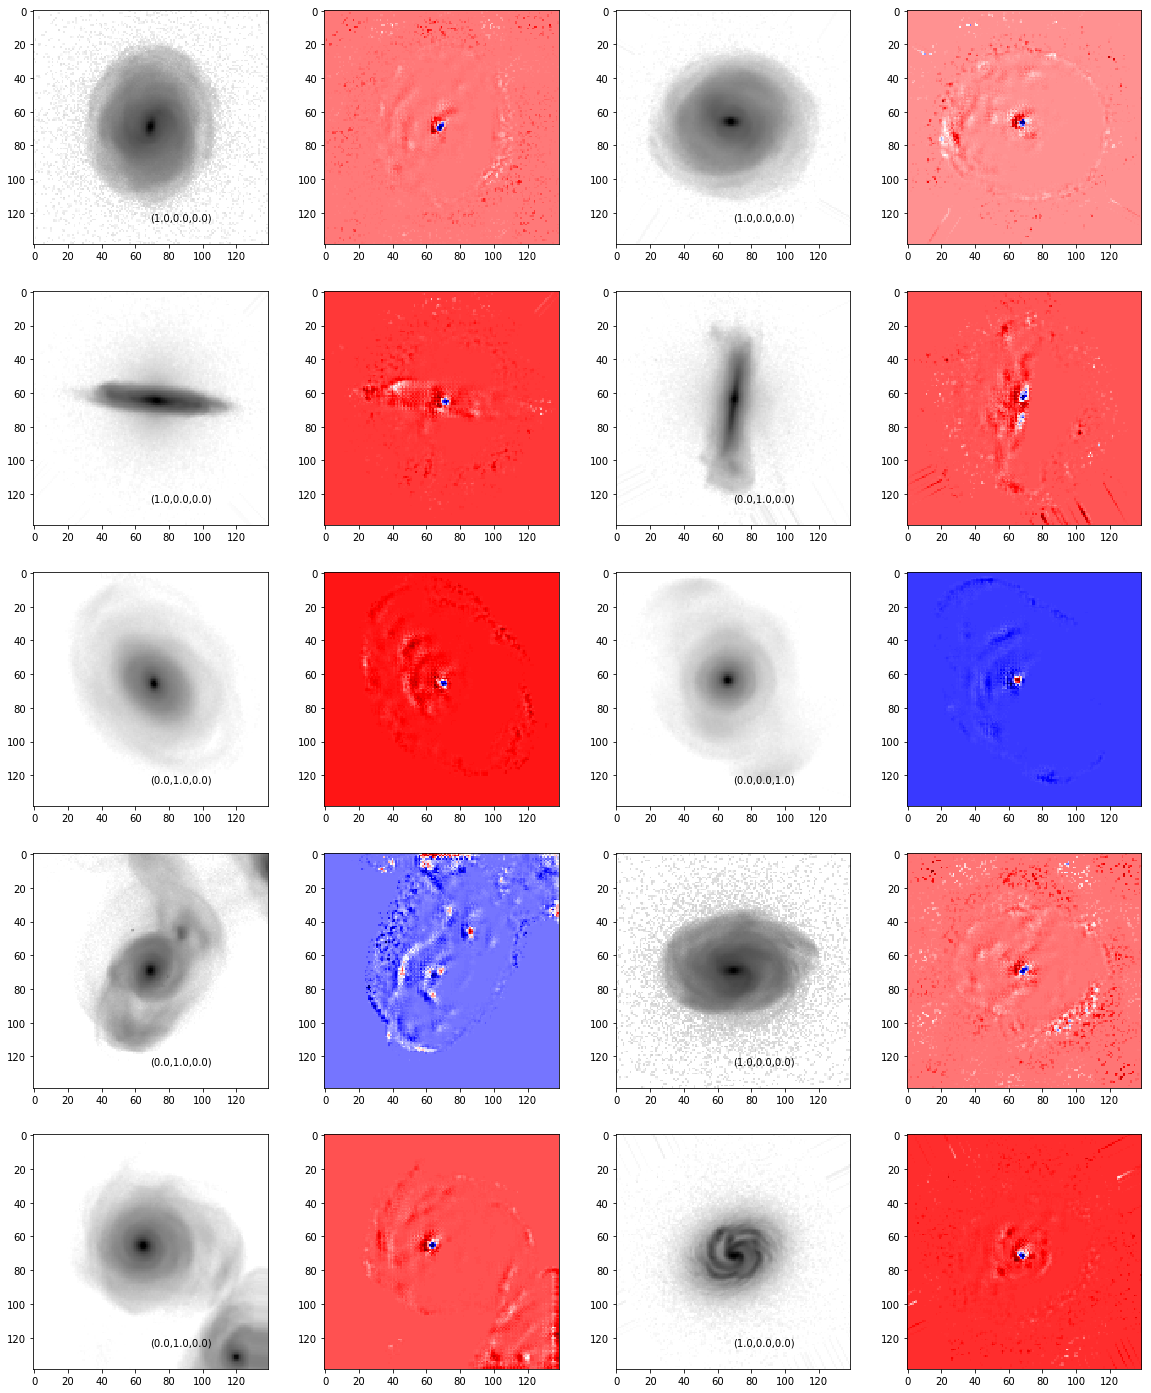

In [6]:
#from utils import plot, plt

# n_cols = 6
# n_rows = int(len(attributions_gradin) / 2)
# fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

# for i, (a1, a2) in enumerate(zip(attributions_gradin, attributions_sv)):
#     row, col = divmod(i, 2)
#     plot(xs[i].reshape(28, 28), cmap='Greys', axis=axes[row, col*3]).set_title('Original')
#     plot(a1.reshape(28,28), xi = xs[i], axis=axes[row,col*3+1]).set_title('Grad*Input')
#     plot(a2.reshape(28,28), xi = xs[i], axis=axes[row,col*3+2]).set_title('Shapley Values')
    
fig,axarr = plt.subplots(5,4,figsize=(20,25))

imgs = xs.reshape(-1,nChannels,139,139)
tars = ys

for i,a1 in enumerate(attributions_gradin):
    row,col = divmod(i, 2)
    axarr[row,col*2].imshow(imgs[i,0],cmap='Greys',vmin=0,vmax=1)
    
    
    axarr[row,col*2+1].imshow(a1.reshape(139,139),cmap='seismic')

    axarr[row,col*2].text(0.5,0.1,'('+','.join([str(tar) for tar in tars[i]])+')',transform=axarr[row,col*2].transAxes)
    
    

## Add timing information to catalogs

Attach the information from galSep_Timescales.npy to the catalog files.

The new files contain the following info:

0 simTag 

1 subTag 

2 snapID

3 camera

4 t_snap # snapshot time

5 tPeri1 # first pericentric passage time

6 tPeri2 # second pericentric passage time

7 tCoal  # coalescence time

Only the Pair and Post catalogs are updated in this way because they are the only files for which the timeline file is relevant (i.e. Iso runs do not have passage times or coalescence times). The Iso catalogs are updated with nonsensical values so that there is shape continuity between catalogs for different labels.

In [1]:
#!/usr/bin/env python

import os,sys
import numpy as np

# load timing file
galsepDir = '/home/bottrell/scratch/RealCNN/Fire_Images_CNN/GalSep/'
# timescale data file
timeScale_data = np.load(galsepDir+'galSep_Timescales.npy')
# data filename convention
dataDir = '/home/bottrell/scratch/RealCNN/MultiClass/Data/'
# input data filename holder
_inFile = dataDir+'{}-{}_catAug.npy'
# output data filename holder
_outFile = dataDir+'{}-{}_catAugTiming.npy'

# list of image types
imgTypes = ['StellarMap','StellarMap_SemiReal','StellarMap_FullReal',
            'Photometry','Photometry_SemiReal','Photometry_FullReal']
# list of classes (Only pair and post here)
labels = ['Pair','Post','Iso']

for imgType in imgTypes:
    for label in labels:
        inFile = _inFile.format(label,imgType)
        inData = np.load(inFile)
        outFile = _outFile.format(label,imgType)
        outData = np.empty((inData.shape[0],8)).astype(str)

        if os.access(outFile,0): continue

        # first 4 columns are the same
        outData[:,:4] = inData

        # galsep filename convention
        for i,line in enumerate(outData):

            simTag,subTag,snapID = line[[0,1,2]]
            snapID = int(snapID)

            if label is 'Post':
                galsepFile = '{}galsep_{}_{}_PMSnapIDs.npz'.format(galsepDir,simTag,subTag)
            if label is 'Pair':
                galsepFile = '{}galsep_{}_{}_PairSnapIDs.npz'.format(galsepDir,simTag,subTag)
            if label is 'Iso':
                galsepFile = '{}{}_IsoSnapIDs.npz'.format(galsepDir,subTag)
            
            if (label is 'Post') or (label is 'Pair'):
                with np.load(galsepFile) as f:
                    # add snapshot time
                    outData[i,4] = f['t'][f['snapID']==snapID][0]

                ts = timeScale_data.item().get('{}_{}'.format(simTag,subTag))
                outData[i,5:8] = np.array(list(ts.values()))
                
            else:
                with np.load(galsepFile) as f:
                    # add snapshot time
                    outData[i,4] = f['t'][f['snapID']==snapID][0]
                # the rest are nonsensical numbers
                outData[i,5:8] = np.array([-99.99,-99.99,-99.99])
                
        np.save(outFile,outData)
        print(outFile)

/home/bottrell/scratch/RealCNN/MultiClass/Data/Iso-StellarMap_catAugTiming.npy
/home/bottrell/scratch/RealCNN/MultiClass/Data/Iso-StellarMap_SemiReal_catAugTiming.npy
/home/bottrell/scratch/RealCNN/MultiClass/Data/Iso-StellarMap_FullReal_catAugTiming.npy
/home/bottrell/scratch/RealCNN/MultiClass/Data/Iso-Photometry_catAugTiming.npy
/home/bottrell/scratch/RealCNN/MultiClass/Data/Iso-Photometry_SemiReal_catAugTiming.npy
/home/bottrell/scratch/RealCNN/MultiClass/Data/Iso-Photometry_FullReal_catAugTiming.npy


## Statistical combination of test set confusion matrices
Confusion matrices for each test case are combined statistically. Inset PDFs are also combined. 

PhSR-i crimson
PhFR-i darkorchid
Median Overall Performance: 0.8698721945137158
/home/bottrell/scratch/RealCNN/MultiClass/Figures/Bootstrap/CMBoot_SingleChannel-Test-Photometry_SemiReal-NC1-i-Train-Photometry_FullReal-NC1-i-0-v0.pdf


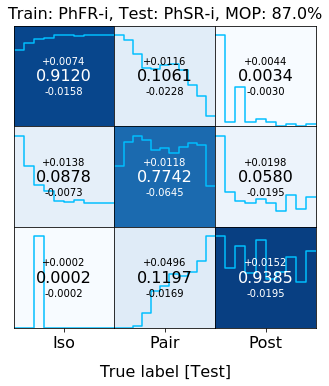

In [17]:
from glob import glob
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
import numpy as np

def Confusion(cnf_matrix,normalize=False,
              colourbar=False,spines=True,tickbottom=False,tickleft=False,cmap='Blues',
              labelbottom=True,labelleft=True,insetPDF=False,title=False,xiso=None,hiso=None,xpair=None,
              hpair=None,xpost=None,hpost=None,classIDs=None,trainLabel=None,testLabel=None,
                trainColour=None,testColour=None,fudgeSum=False):

    cnf_shape = cnf_matrix.shape[1]
    
    # Normalize if necessary, define vmin vmax
    if normalize:
        vmin,vmax=0,1
        diag = np.diag_indices(cnf_matrix.shape[1])
        perf = np.zeros(cnf_matrix.shape[0])
        for i,m in enumerate(cnf_matrix):
            perf[i] = float(np.sum(m.astype(int)[diag]))/float(np.sum(m))
        print('Median Overall Performance: '+str(np.median(perf)))
        #labelSums = np.dstack([cnf_matrix.sum(axis=1)]*cnf_matrix.shape[-1]) # Wrong axis!!!
        labelSums = np.stack([cnf_matrix.sum(axis=1)]*cnf_matrix.shape[-1],axis=1)
        cnf_matrix = cnf_matrix.astype('float')/labelSums.astype('float')
        cnf_med = np.nanpercentile(cnf_matrix,q=50,axis=0)
        cnf_errm = np.nanpercentile(cnf_matrix,q=16,axis=0)
        cnf_errp = np.nanpercentile(cnf_matrix,q=84,axis=0)
        cnf_errp = np.abs(cnf_errp-cnf_med)
        cnf_errm = np.abs(cnf_errm-cnf_med)
        if fudgeSum:
            fudgeFactor = 1./np.sum(cnf_med,axis=0)
            cnf_med*=fudgeFactor
            cnf_errp*=fudgeFactor
            cnf_errm*=fudgeFactor
        
    else:
        cnf_med = np.nanpercentile(cnf_matrix,q=50,axis=0).astype('int')
        cnf_errm = np.nanpercentile(cnf_matrix,q=16,axis=0).astype('int')
        cnf_errp = np.nanpercentile(cnf_matrix,q=84,axis=0).astype('int')
        cnf_errp = np.abs(cnf_errp-cnf_med).astype('int')
        cnf_errm = np.abs(cnf_errm-cnf_med).astype('int')
        vmin,vmax=0,np.max(np.nanmedian(cnf_matrix.sum(axis=1)))
    
    # set up plot playground
    fig,axarr = plt.subplots(cnf_shape,cnf_shape,figsize=(6,6))
    fig.subplots_adjust(bottom=0.15,top=0.85,left=0.15,right=0.85,wspace=0.,hspace=0.)
    fmt = '.4f' if normalize else 'd'
    thresh = vmax / 2.
    np.set_printoptions(precision=3)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 16
    xmin,xmax = -0.1,1
    xmid = (xmax-xmin)/2+xmin

    # loop over axes and confusion elements
    for ax,cnf_el,cnf_elp,cnf_elm in zip(axarr.flatten(),cnf_med.flatten(),cnf_errp.flatten(),cnf_errm.flatten()):
        # remove ticks and labels x
        ax.tick_params(axis='x',which='both',bottom=False,
                       top=False,labelbottom=False)
        # remove ticks and labels y
        ax.tick_params(axis='y',which='both',left=False,
                       right=False,labelleft=False)
        im = ax.imshow([[cnf_el]],vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto',extent=[xmin,xmax,xmin,xmax])
        ax.text(0.5,0.5,format(cnf_el,fmt),transform=ax.transAxes,
                ha='center',va='center',color=('white' if cnf_el>thresh else 'black'))
        ax.text(0.5,0.4,'-'+format(cnf_elm,fmt),transform=ax.transAxes,
                ha='center',va='top',color=('white' if cnf_el>thresh else 'black'),fontsize=10)
        ax.text(0.5,0.6,'+'+format(cnf_elp,fmt),transform=ax.transAxes,
                ha='center',va='bottom',color=('white' if cnf_el>thresh else 'black'),fontsize=10)
        
        if not spines:
            # turn off all spines first
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
    
    # add spines to border elements
    for i in range(cnf_shape):
        for j in range(cnf_shape):
            if i==0:
                axarr[j,i].spines['left'].set_visible(True)
            if j==0:
                axarr[j,i].spines['top'].set_visible(True)
            if i==cnf_shape-1:
                axarr[j,i].spines['right'].set_visible(True)
            if j==cnf_shape-1:
                axarr[j,i].spines['bottom'].set_visible(True)
        
    if colourbar:
        # make/keep square
        cbar_ax = fig.add_axes([0.875, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)
          
    if tickbottom or tickleft:
        for i,classID in enumerate(classIDs):
            if tickbottom:
                axarr[-1,i].tick_params(axis='x',which='both',bottom=True,
                                        top=False,labelbottom=True)
                axarr[-1,i].set_xticks([xmid])
                axarr[-1,i].set_xticklabels([classID],rotation=0)
            if tickleft:
                axarr[i,0].tick_params(axis='y',which='both',left=True,
                                       right=False,labelleft=True)
                axarr[i,0].set_yticks([xmid])
                axarr[i,0].set_yticklabels([classID],rotation=90,ha='right',va='center')

    if labelbottom:
        fig.text(0.5, 0.05, 'True label [Test]', ha='center', va='center')
        
    if labelleft:
        fig.text(0.05, 0.5, 'Predicted label [Test]', ha='center', va='center', rotation='vertical')
        
    if insetPDF:
        for i in range(3):
            for j in range(3):
                if j==0: # iso
                    axarr[i,j].autoscale(False)
                    y = hiso[i]/np.max(hiso[i])
                    y = np.insert(y,-1,y[-1])
                    axarr[i,j].step(x=xiso,y=y-0.1,where='post',lw=1.5,color='deepskyblue',zorder=2)
                if j==1: # pair
                    axarr[i,j].autoscale(False)
                    y = hpair[i]/np.max(hpair[i])
                    y = np.insert(y,-1,y[-1])
                    axarr[i,j].step(x=xpair,y=y-0.1,where='post',lw=1.5,color='deepskyblue',zorder=2)
                if j==2: # pair
                    axarr[i,j].autoscale(False)
                    y = hpost[i]/np.max(hpost[i])
                    y = np.insert(y,-1,y[-1])
                    axarr[i,j].step(x=xpost,y=y-0.1,where='post',lw=1.5,color='deepskyblue',zorder=2)
                    
    if title and normalize:
        #fig.text(0.15,0.875,'Train, Test = ',ha='left',va='bottom',fontsize=16)
        fig.text(0.5,0.86,'Train: {}, Test: {}, MOP: {:.1f}%'.format(trainShort,testShort,np.median(perf)*100),
                 ha='center',va='bottom',fontsize=16,color='black')


        
#         fig.text(0.16,0.875,'Train: '+trainShort,ha='left',va='bottom',fontsize=16,color='black',
#                  bbox=dict(facecolor='none',edgecolor=trainColour,boxstyle='round',linewidth=3))
#         fig.text(0.84,0.875,'Test: '+testShort,ha='right',va='bottom',fontsize=16,color='black',
#                  bbox=dict(facecolor='none',edgecolor=testColour,boxstyle='round',linewidth=3))
        

     
                    
    return fig
    
dataDir = '/home/bottrell/scratch/RealCNN/MultiClass/Models/'
figDir = '/home/bottrell/scratch/RealCNN/MultiClass/Figures/Bootstrap/'
update = 0 
version = 0
classIDs = ['Iso','Pair','Post']


trainLabel = 'Photometry_FullReal-NC1-i'
testLabel = 'Photometry_FulReal-NC1-i'

shortLabels = ['SM','SMSR','SMFR','Ph','PhSR','PhFR']
colours = ['C0','C2','gold','C1','crimson','darkorchid']

if 'Photometry_FullReal' in testLabel:
    testShort = shortLabels[5]
    testColour = colours[5]
elif 'Photometry_SemiReal' in testLabel:
    testShort = shortLabels[4]
    testColour = colours[4]
elif 'Photometry' in testLabel:
    testShort = shortLabels[3]
    testColour = colours[3]
elif 'StellarMap_FullReal' in testLabel:
    testShort = shortLabels[2]
    testColour = colours[2]
elif 'StellarMap_SemiReal' in testLabel:
    testShort = shortLabels[1]
    testColour = colours[1]
elif 'StellarMap' in testLabel:
    testShort = shortLabels[0]
    testColour = colours[0]
    
if 'Photometry_FullReal' in trainLabel:
    trainShort = shortLabels[5]
    trainColour = colours[5]
elif 'Photometry_SemiReal' in trainLabel:
    trainShort = shortLabels[4]
    trainColour = colours[4]
elif 'Photometry' in trainLabel:
    trainShort = shortLabels[3]
    trainColour = colours[3]
elif 'StellarMap_FullReal' in trainLabel:
    trainShort = shortLabels[2]
    trainColour = colours[2]
elif 'StellarMap_SemiReal' in trainLabel:
    trainShort = shortLabels[1]
    trainColour = colours[1]
elif 'StellarMap' in trainLabel:
    trainShort = shortLabels[0]
    trainColour = colours[0]
    
if 'NC1-i' in trainLabel and 'NC1-i' in testLabel:
    trainShort+='-i'
    testShort+='-i'
if 'NC1-r' in trainLabel and 'NC1-r' in testLabel:
    trainShort+='-r'
    testShort+='-r'
print(testShort,testColour)
print(trainShort,trainColour)

fileNames = glob(dataDir+'ConfMatrix-Test-{}-Train-{}-RS-*-{}-v{}.npz'.format(testLabel,trainLabel,update,version))
nBoot = len(fileNames)

with np.load(fileNames[0]) as f:
    cnf = np.zeros((nBoot,*f['cnf'].shape))
    cnfNorm = np.zeros((nBoot,*f['cnfNorm'].shape))
    xiso = f['xiso'][0,:]
    hiso = np.zeros((nBoot,*f['hiso'].shape))
    xpair = f['xpair'][0,:]
    hpair = np.zeros((nBoot,*f['hpair'].shape))
    xpost = f['xpost'][0,:]
    hpost = np.zeros((nBoot,*f['hpost'].shape))
    
for i,fileName in enumerate(fileNames):
    with np.load(fileName) as f:
        cnf[i] = f['cnf']
        cnfNorm[i] = f['cnfNorm']
        hiso[i] = f['hiso']
        hpair[i] = f['hpair']
        hpost[i] = f['hpost']
        
        
hisoMed = np.percentile(hiso,q=50,axis=0)
hisoL = np.percentile(hiso,q=16,axis=0)
hisoU = np.percentile(hiso,q=84,axis=0)

hpairMed = np.percentile(hpair,q=50,axis=0)
hpairL = np.percentile(hpair,q=16,axis=0)
hpairU = np.percentile(hpair,q=84,axis=0)

hpostMed = np.percentile(hpost,q=50,axis=0)
hpostL = np.percentile(hpost,q=16,axis=0)
hpostU = np.percentile(hpost,q=84,axis=0)

xiso = np.linspace(-0.1,1,len(xiso))
xpair = np.linspace(-0.1,1,len(xpair))
xpost = np.linspace(-0.1,1,len(xpost))


# fig = Confusion(cnf,classIDs=classIDs,normalize=True,
#               colourbar=True,spines=True,tickbottom=True,tickleft=True,cmap='Blues',
#               labelbottom=True,labelleft=True,insetPDF=True,title=True,xiso=xiso,hiso=hisoMed,xpair=xpair,
#               hpair=hpairMed,xpost=xpost,hpost=hpostMed,trainLabel=trainShort,testLabel=testShort,
#                 trainColour=trainColour,testColour=testColour,fudgeSum=True)

# fig.savefig(figDir+'CMBootLabels-Test-{}-Train-{}-{}-v{}.pdf'.format(testLabel,trainLabel,update,version),bbox_inches='tight')

fig = Confusion(cnf,classIDs=classIDs,normalize=True,
              colourbar=False,spines=True,tickbottom=True,tickleft=False,cmap='Blues',
              labelbottom=True,labelleft=False,insetPDF=True,title=True,xiso=xiso,hiso=hisoMed,xpair=xpair,
              hpair=hpairMed,xpost=xpost,hpost=hpostMed,trainLabel=trainShort,testLabel=testShort,
                trainColour=trainColour,testColour=testColour,fudgeSum=True)

figname = 'CMBoot_SingleChannel-Test-{}-Train-{}-{}-v{}.pdf'.format(testLabel,trainLabel,update,version)
fig.savefig(figDir+figname,bbox_inches='tight')
print(figDir+figname)



## Generate confusion matrices for all tests in main handshake

In [35]:
from glob import glob
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
import numpy as np

def Confusion(cnf_matrix,normalize=False,
              colourbar=False,spines=True,tickbottom=False,tickleft=False,cmap='Blues',
              labelbottom=True,labelleft=True,insetPDF=False,title=False,xiso=None,hiso=None,xpair=None,
              hpair=None,xpost=None,hpost=None,classIDs=None,trainLabel=None,testLabel=None,
                trainColour=None,testColour=None,fudgeSum=False):

    cnf_shape = cnf_matrix.shape[1]
    
    # Normalize if necessary, define vmin vmax
    if normalize:
        vmin,vmax=0,1
        diag = np.diag_indices(cnf_matrix.shape[1])
        perf = np.zeros(cnf_matrix.shape[0])
        for i,m in enumerate(cnf_matrix):
            perf[i] = float(np.sum(m.astype(int)[diag]))/float(np.sum(m))
        print('Median Overall Performance: '+str(np.median(perf)))
        #labelSums = np.dstack([cnf_matrix.sum(axis=1)]*cnf_matrix.shape[-1]) # Wrong axis!!!
        labelSums = np.stack([cnf_matrix.sum(axis=1)]*cnf_matrix.shape[-1],axis=1)
        cnf_matrix = cnf_matrix.astype('float')/labelSums.astype('float')
        cnf_med = np.nanpercentile(cnf_matrix,q=50,axis=0)
        cnf_errm = np.nanpercentile(cnf_matrix,q=16,axis=0)
        cnf_errp = np.nanpercentile(cnf_matrix,q=84,axis=0)
        cnf_errp = np.abs(cnf_errp-cnf_med)
        cnf_errm = np.abs(cnf_errm-cnf_med)
        if fudgeSum:
            fudgeFactor = 1./np.sum(cnf_med,axis=0)
            cnf_med*=fudgeFactor
            cnf_errp*=fudgeFactor
            cnf_errm*=fudgeFactor
        
    else:
        cnf_med = np.nanpercentile(cnf_matrix,q=50,axis=0).astype('int')
        cnf_errm = np.nanpercentile(cnf_matrix,q=16,axis=0).astype('int')
        cnf_errp = np.nanpercentile(cnf_matrix,q=84,axis=0).astype('int')
        cnf_errp = np.abs(cnf_errp-cnf_med).astype('int')
        cnf_errm = np.abs(cnf_errm-cnf_med).astype('int')
        vmin,vmax=0,np.max(np.nanmedian(cnf_matrix.sum(axis=1)))
    
    # set up plot playground
    fig,axarr = plt.subplots(cnf_shape,cnf_shape,figsize=(6,6))
    fig.subplots_adjust(bottom=0.15,top=0.85,left=0.15,right=0.85,wspace=0.,hspace=0.)
    fmt = '.4f' if normalize else 'd'
    thresh = vmax / 2.
    np.set_printoptions(precision=3)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 16
    xmin,xmax = -0.1,1
    xmid = (xmax-xmin)/2+xmin

    # loop over axes and confusion elements
    for ax,cnf_el,cnf_elp,cnf_elm in zip(axarr.flatten(),cnf_med.flatten(),cnf_errp.flatten(),cnf_errm.flatten()):
        # remove ticks and labels x
        ax.tick_params(axis='x',which='both',bottom=False,
                       top=False,labelbottom=False)
        # remove ticks and labels y
        ax.tick_params(axis='y',which='both',left=False,
                       right=False,labelleft=False)
        im = ax.imshow([[cnf_el]],vmin=vmin,vmax=vmax,cmap=cmap,aspect='auto',extent=[xmin,xmax,xmin,xmax])
        ax.text(0.5,0.5,format(cnf_el,fmt),transform=ax.transAxes,
                ha='center',va='center',color=('white' if cnf_el>thresh else 'black'))
        ax.text(0.5,0.4,'-'+format(cnf_elm,fmt),transform=ax.transAxes,
                ha='center',va='top',color=('white' if cnf_el>thresh else 'black'),fontsize=10)
        ax.text(0.5,0.6,'+'+format(cnf_elp,fmt),transform=ax.transAxes,
                ha='center',va='bottom',color=('white' if cnf_el>thresh else 'black'),fontsize=10)
        
        if not spines:
            # turn off all spines first
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
    
    # add spines to border elements
    for i in range(cnf_shape):
        for j in range(cnf_shape):
            if i==0:
                axarr[j,i].spines['left'].set_visible(True)
            if j==0:
                axarr[j,i].spines['top'].set_visible(True)
            if i==cnf_shape-1:
                axarr[j,i].spines['right'].set_visible(True)
            if j==cnf_shape-1:
                axarr[j,i].spines['bottom'].set_visible(True)
        
    if colourbar:
        # make/keep square
        cbar_ax = fig.add_axes([0.875, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)
          
    if tickbottom or tickleft:
        for i,classID in enumerate(classIDs):
            if tickbottom:
                axarr[-1,i].tick_params(axis='x',which='both',bottom=True,
                                        top=False,labelbottom=True)
                axarr[-1,i].set_xticks([xmid])
                axarr[-1,i].set_xticklabels([classID],rotation=0)
            if tickleft:
                axarr[i,0].tick_params(axis='y',which='both',left=True,
                                       right=False,labelleft=True)
                axarr[i,0].set_yticks([xmid])
                axarr[i,0].set_yticklabels([classID],rotation=90,ha='right',va='center')

    if labelbottom:
        fig.text(0.5, 0.05, 'True label [Test]', ha='center', va='center')
        
    if labelleft:
        fig.text(0.05, 0.5, 'Predicted label [Test]', ha='center', va='center', rotation='vertical')
        
    if insetPDF:
        for i in range(3):
            for j in range(3):
                if j==0: # iso
                    axarr[i,j].autoscale(False)
                    y = hiso[i]/np.max(hiso[i])
                    y = np.insert(y,-1,y[-1])
                    axarr[i,j].step(x=xiso,y=y-0.1,where='post',lw=1.5,color='deepskyblue',zorder=2)
                if j==1: # pair
                    axarr[i,j].autoscale(False)
                    y = hpair[i]/np.max(hpair[i])
                    y = np.insert(y,-1,y[-1])
                    axarr[i,j].step(x=xpair,y=y-0.1,where='post',lw=1.5,color='deepskyblue',zorder=2)
                if j==2: # pair
                    axarr[i,j].autoscale(False)
                    y = hpost[i]/np.max(hpost[i])
                    y = np.insert(y,-1,y[-1])
                    axarr[i,j].step(x=xpost,y=y-0.1,where='post',lw=1.5,color='deepskyblue',zorder=2)
                    
    if title and normalize:
        fig.text(0.5,0.86,'Train: {}, Test: {}, MOP: {:.1f}%'.format(trainShort,testShort,np.median(perf)*100),
                 ha='center',va='bottom',fontsize=16,color='black')
    
    return fig
    
dataDir = '/home/bottrell/scratch/RealCNN/MultiClass/Models/'
figDir = '/home/bottrell/scratch/RealCNN/MultiClass/Figures/Bootstrap/'
update = 0 
version = 0
classIDs = ['Iso','Pair','Post']


trainLabels = ['StellarMap','StellarMap_SemiReal','StellarMap_FullReal',
              'Photometry','Photometry_SemiReal','Photometry_FullReal']
testLabels = ['StellarMap','StellarMap_SemiReal','StellarMap_FullReal',
             'Photometry','Photometry_SemiReal','Photometry_FullReal']

for _trainLabel in trainLabels:
    for testLabel in testLabels:
        if 'Photometry' in _trainLabel and 'StellarMap' in testLabel:
            trainLabel = _trainLabel+'-NC1-i'
        else:
            trainLabel = _trainLabel
            
        shortLabels = ['SM','SMSR','SMFR','Ph','PhSR','PhFR']
        colours = ['C0','C2','gold','C1','crimson','darkorchid']

        if 'Photometry_FullReal' in testLabel:
            testShort = shortLabels[5]
            testColour = colours[5]
        elif 'Photometry_SemiReal' in testLabel:
            testShort = shortLabels[4]
            testColour = colours[4]
        elif 'Photometry' in testLabel:
            testShort = shortLabels[3]
            testColour = colours[3]
        elif 'StellarMap_FullReal' in testLabel:
            testShort = shortLabels[2]
            testColour = colours[2]
        elif 'StellarMap_SemiReal' in testLabel:
            testShort = shortLabels[1]
            testColour = colours[1]
        elif 'StellarMap' in testLabel:
            testShort = shortLabels[0]
            testColour = colours[0]

        if 'Photometry_FullReal' in trainLabel:
            trainShort = shortLabels[5]
            trainColour = colours[5]
        elif 'Photometry_SemiReal' in trainLabel:
            trainShort = shortLabels[4]
            trainColour = colours[4]
        elif 'Photometry' in trainLabel:
            trainShort = shortLabels[3]
            trainColour = colours[3]
        elif 'StellarMap_FullReal' in trainLabel:
            trainShort = shortLabels[2]
            trainColour = colours[2]
        elif 'StellarMap_SemiReal' in trainLabel:
            trainShort = shortLabels[1]
            trainColour = colours[1]
        elif 'StellarMap' in trainLabel:
            trainShort = shortLabels[0]
            trainColour = colours[0]

        if 'NC1-i' in trainLabel and 'NC1-i' in testLabel:
            trainShort+='-i'
            testShort+='-i'
        if 'NC1-r' in trainLabel and 'NC1-r' in testLabel:
            trainShort+='-r'
            testShort+='-r'

        print(trainLabel,testLabel)
        fileNames = glob(dataDir+'ConfMatrix-Test-{}-Train-{}-RS-*-{}-v{}.npz'.format(testLabel,trainLabel,update,version))
        nBoot = len(fileNames)

        with np.load(fileNames[0]) as f:
            cnf = np.zeros((nBoot,*f['cnf'].shape))
            cnfNorm = np.zeros((nBoot,*f['cnfNorm'].shape))
            xiso = f['xiso'][0,:]
            hiso = np.zeros((nBoot,*f['hiso'].shape))
            xpair = f['xpair'][0,:]
            hpair = np.zeros((nBoot,*f['hpair'].shape))
            xpost = f['xpost'][0,:]
            hpost = np.zeros((nBoot,*f['hpost'].shape))

        for i,fileName in enumerate(fileNames):
            with np.load(fileName) as f:
                cnf[i] = f['cnf']
                cnfNorm[i] = f['cnfNorm']
                hiso[i] = f['hiso']
                hpair[i] = f['hpair']
                hpost[i] = f['hpost']


        hisoMed = np.percentile(hiso,q=50,axis=0)
        hisoL = np.percentile(hiso,q=16,axis=0)
        hisoU = np.percentile(hiso,q=84,axis=0)

        hpairMed = np.percentile(hpair,q=50,axis=0)
        hpairL = np.percentile(hpair,q=16,axis=0)
        hpairU = np.percentile(hpair,q=84,axis=0)

        hpostMed = np.percentile(hpost,q=50,axis=0)
        hpostL = np.percentile(hpost,q=16,axis=0)
        hpostU = np.percentile(hpost,q=84,axis=0)

        xiso = np.linspace(-0.1,1,len(xiso))
        xpair = np.linspace(-0.1,1,len(xpair))
        xpost = np.linspace(-0.1,1,len(xpost))


#         fig = Confusion(cnf,classIDs=classIDs,normalize=True,
#                       colourbar=True,spines=True,tickbottom=True,tickleft=True,cmap='Blues',
#                       labelbottom=True,labelleft=True,insetPDF=True,title=True,xiso=xiso,hiso=hisoMed,xpair=xpair,
#                       hpair=hpairMed,xpost=xpost,hpost=hpostMed,trainLabel=trainShort,testLabel=testShort,
#                         trainColour=trainColour,testColour=testColour,fudgeSum=True)

#         fig.savefig(figDir+'CMBootLabels-Test-{}-Train-{}-{}-v{}.pdf'.format(testLabel,trainLabel,update,version),bbox_inches='tight')

        fig = Confusion(cnf,classIDs=classIDs,normalize=True,
                      colourbar=False,spines=True,tickbottom=False,tickleft=False,cmap='Blues',
                      labelbottom=False,labelleft=False,insetPDF=True,title=False,xiso=xiso,hiso=hisoMed,xpair=xpair,
                      hpair=hpairMed,xpost=xpost,hpost=hpostMed,trainLabel=trainShort,testLabel=testShort,
                        trainColour=trainColour,testColour=testColour,fudgeSum=True)

        fig.savefig(figDir+'CMBoot_MegaMatrix-Test-{}-Train-{}-{}-v{}.pdf'.format(testLabel,trainLabel,update,version),bbox_inches='tight')

        fig.clf()

StellarMap StellarMap
Median Overall Performance: 0.9578137988362427


/home/bottrell/venv/tf36-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
/home/bottrell/venv/tf36-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in true_divide


StellarMap StellarMap_SemiReal
Median Overall Performance: 0.3758260598503741
StellarMap StellarMap_FullReal
Median Overall Performance: 0.40375623441396513
StellarMap Photometry
Median Overall Performance: 0.9024470074812967
StellarMap Photometry_SemiReal
Median Overall Performance: 0.3582917705735661
StellarMap Photometry_FullReal
Median Overall Performance: 0.3956982543640898
StellarMap_SemiReal StellarMap
Median Overall Performance: 0.6172225685785536
StellarMap_SemiReal StellarMap_SemiReal
Median Overall Performance: 0.8543225270157939
StellarMap_SemiReal StellarMap_FullReal
Median Overall Performance: 0.4487998753117207
StellarMap_SemiReal Photometry
Median Overall Performance: 0.5720230673316709
StellarMap_SemiReal Photometry_SemiReal
Median Overall Performance: 0.8387936408977557
StellarMap_SemiReal Photometry_FullReal
Median Overall Performance: 0.44928304239401495
StellarMap_FullReal StellarMap
Median Overall Performance: 0.51875
StellarMap_FullReal StellarMap_SemiReal
Median

/home/bottrell/venv/tf36-cpu/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Photometry Photometry
Median Overall Performance: 0.9595802161263508
Photometry Photometry_SemiReal
Median Overall Performance: 0.5714931421446383
Photometry Photometry_FullReal
Median Overall Performance: 0.48924563591022446
Photometry_SemiReal-NC1-i StellarMap
Median Overall Performance: 0.6899158354114714
Photometry_SemiReal-NC1-i StellarMap_SemiReal
Median Overall Performance: 0.8050187032418953
Photometry_SemiReal-NC1-i StellarMap_FullReal
Median Overall Performance: 0.4593204488778055
Photometry_SemiReal Photometry
Median Overall Performance: 0.7176278054862844
Photometry_SemiReal Photometry_SemiReal
Median Overall Performance: 0.9089775561097257
Photometry_SemiReal Photometry_FullReal
Median Overall Performance: 0.5623597256857855
Photometry_FullReal-NC1-i StellarMap
Median Overall Performance: 0.5390430174563591
Photometry_FullReal-NC1-i StellarMap_SemiReal
Median Overall Performance: 0.7711034912718204
Photometry_FullReal-NC1-i StellarMap_FullReal
Median Overall Performance: 0

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

## Bar Plot of network performances
Performance of each model on each other model are plotted more concisely as a bar plot.


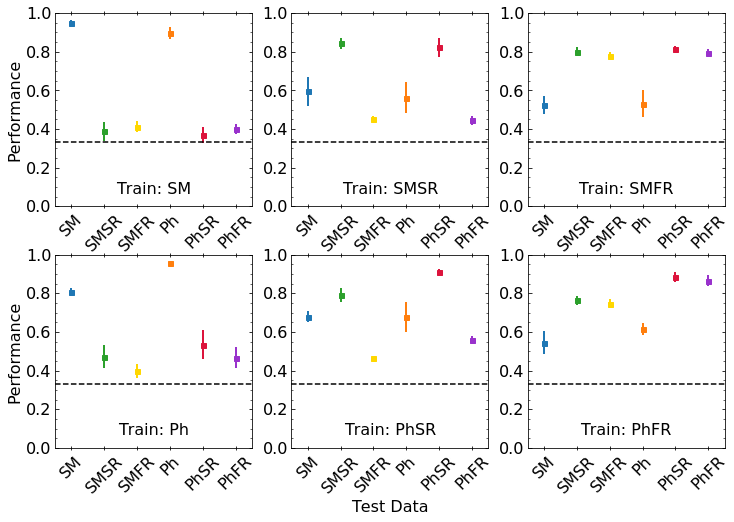

In [24]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16

trainLabels = ['StellarMap','StellarMap_SemiReal','StellarMap_FullReal',
               'Photometry','Photometry_SemiReal','Photometry_FullReal']
testLabels = ['StellarMap','StellarMap_SemiReal','StellarMap_FullReal',
               'Photometry','Photometry_SemiReal','Photometry_FullReal']
shortLabels = ['SM','SMSR','SMFR','Ph','PhSR','PhFR']
colours = ['C0','C2','gold','C1','crimson','darkorchid']

    
dataDir = '/home/bottrell/scratch/RealCNN/MultiClass/Models/'
figDir = '/home/bottrell/scratch/RealCNN/MultiClass/Figures/Bootstrap/'
update = 0 
version = 0

fig,axarr = plt.subplots(2,3,figsize=(12,8))
fig.subplots_adjust(hspace=0.25)

for xx,trainLabel,shortLabel in zip(range(len(trainLabels)),trainLabels,shortLabels):
    ax = axarr.flat[xx]
    for yy,colour,testLabel in zip(range(6),colours,testLabels):
        if 'StellarMap' in testLabel and 'Photometry' in trainLabel:
            trainLabel+='-NC1-i'
        fileNames = glob(dataDir+'ConfMatrix-Test-{}-Train-{}-RS-*-{}-v{}.npz'.format(testLabel,trainLabel,update,version))
        nBoot = len(fileNames)
        perf = np.zeros(nBoot)
        errU = np.zeros(nBoot)
        errL = np.zeros(nBoot)
        
        with np.load(fileNames[0]) as f:
            cnf = np.zeros((nBoot,*f['cnf'].shape))
        diag = np.diag_indices(cnf.shape[1])
   
        for i,fileName in enumerate(fileNames):
            with np.load(fileName) as f:
                perf[i] = np.nansum(f['cnf'][diag])/np.nansum(f['cnf'])
                
        med = np.nanmean(perf)
        err = np.nanstd(perf)
        ax.errorbar(yy,med,yerr=err,elinewidth=2,marker='s',markersize=5,color=colour,ecolor=colour)
        
                
        if 'StellarMap' in testLabel and 'Photometry' in trainLabel:
            trainLabel=trainLabel[:-6]
    
    # remove ticks and labels x
    ax.tick_params(axis='both',which='both',bottom=True,left=True,right=True,labelleft=True,
                   top=True,labelbottom=True,direction='in')
    ax.minorticks_on()
    ax.tick_params(axis='x',which='minor',bottom=False,top=False)
    ax.tick_params(axis='x',which='major',direction='inout')

    ax.set_xticks(range(6))
    ax.set_xticklabels(shortLabels,rotation=45)
    ax.set_xlim(-0.5,5.5)
    ax.set_ylim(0.,1)
    ax.axhline(0.333,color='black',linestyle='dashed')
    ax.text(0.5,0.05,'Train: {}'.format(shortLabel),transform=ax.transAxes,ha='center',va='bottom')
            

for ax in axarr.flat[::3]:
    ax.set_ylabel('Performance')
    
axarr.flat[4].set_xlabel('Test Data')
fig.savefig(figDir+'TrainTest_Performance.pdf',bbox_inches='tight')        

        

StellarMap StellarMap 0.9578137988362427
StellarMap StellarMap_SemiReal 0.3758260598503741
StellarMap StellarMap_FullReal 0.40375623441396513
StellarMap Photometry 0.9024470074812967
StellarMap Photometry_SemiReal 0.3582917705735661
StellarMap Photometry_FullReal 0.3956982543640898
StellarMap_SemiReal StellarMap 0.6172225685785536
StellarMap_SemiReal StellarMap_SemiReal 0.8543225270157939
StellarMap_SemiReal StellarMap_FullReal 0.4487998753117207
StellarMap_SemiReal Photometry 0.5720230673316709
StellarMap_SemiReal Photometry_SemiReal 0.8387936408977557
StellarMap_SemiReal Photometry_FullReal 0.44928304239401495
StellarMap_FullReal StellarMap 0.51875
StellarMap_FullReal StellarMap_SemiReal 0.8002961346633416
StellarMap_FullReal StellarMap_FullReal 0.777431421446384
StellarMap_FullReal Photometry 0.5322319201995013
StellarMap_FullReal Photometry_SemiReal 0.8132481296758105
StellarMap_FullReal Photometry_FullReal 0.7955423940149626
Photometry-NC1-i StellarMap 0.8019482543640897
Photometr

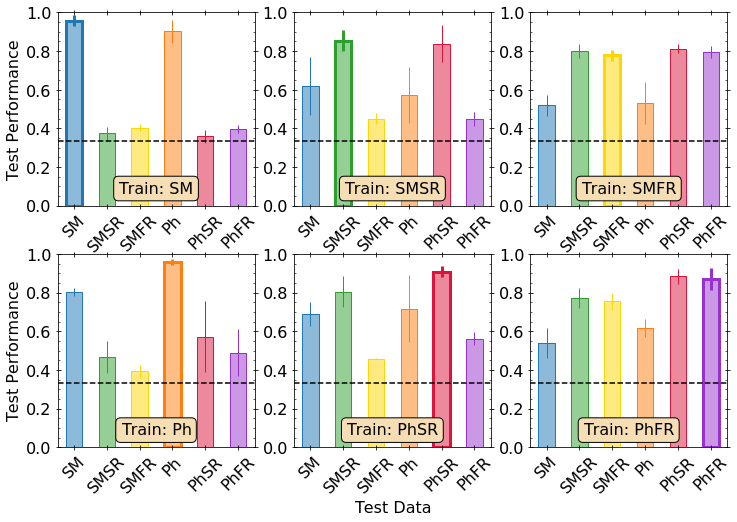

In [87]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16

trainLabels = ['StellarMap','StellarMap_SemiReal','StellarMap_FullReal',
               'Photometry','Photometry_SemiReal','Photometry_FullReal']
testLabels = ['StellarMap','StellarMap_SemiReal','StellarMap_FullReal',
               'Photometry','Photometry_SemiReal','Photometry_FullReal']
shortLabels = ['SM','SMSR','SMFR','Ph','PhSR','PhFR']
colours = ['C0','C2','gold','C1','crimson','darkorchid']

    
dataDir = '/home/bottrell/scratch/RealCNN/MultiClass/Models/'
figDir = '/home/bottrell/scratch/RealCNN/MultiClass/Figures/Bootstrap/'
update = 0 
version = 0

fig,axarr = plt.subplots(2,3,figsize=(12,8))
fig.subplots_adjust(hspace=0.25)

for xx,_trainLabel,shortLabel in zip(range(len(trainLabels)),trainLabels,shortLabels):
    ax = axarr.flat[xx]
    for yy,colour,testLabel in zip(range(6),colours,testLabels):
        if 'StellarMap' in testLabel and 'Photometry' in _trainLabel:
            trainLabel=_trainLabel+'-NC1-i'
        else:
            trainLabel=_trainLabel
        fileNames = glob(dataDir+'ConfMatrix-Test-{}-Train-{}-RS-*-{}-v{}.npz'.format(testLabel,trainLabel,update,version))
        nBoot = len(fileNames)
        perf = np.zeros(nBoot)
        errU = np.zeros(nBoot)
        errL = np.zeros(nBoot)
        
        if _trainLabel==testLabel:
            linewidth=3
        else:
            linewidth=1
        
        with np.load(fileNames[0]) as f:
            cnf = np.zeros((nBoot,*f['cnf'].shape))
        diag = np.diag_indices(cnf.shape[1])
   
        for i,fileName in enumerate(fileNames):
            with np.load(fileName) as f:
                perf[i] = np.nansum(f['cnf'][diag])/np.nansum(f['cnf'])
                
        med = np.nanmedian(perf)
        print(trainLabel,testLabel,med)
        err = [med-np.nanpercentile(perf,q=5),np.nanpercentile(perf,q=95)-med]
        #print(err)
        
        ax.bar(yy,med,width=0.5,color=colour,edgecolor=colour,linewidth=0,alpha=0.5,zorder=-1)
        ax.bar(yy,med,width=0.5,color='None',edgecolor=colour,linewidth=linewidth,alpha=1)
        ax.errorbar(yy,med,yerr=[err],color=colour,ecolor=colour,linewidth=linewidth,alpha=1)
    
                
        if 'StellarMap' in testLabel and 'Photometry' in trainLabel:
            trainLabel=trainLabel[:-6]
        #print(perf)
    
    # remove ticks and labels x
    ax.tick_params(axis='both',which='both',bottom=True,left=True,right=True,labelleft=True,
                   top=True,labelbottom=True,direction='in')
    ax.minorticks_on()
    ax.tick_params(axis='x',which='minor',bottom=False,top=False)
    ax.tick_params(axis='both',which='major',direction='inout',size=5)

    ax.set_xticks(range(6))
    ax.set_xticklabels(shortLabels,rotation=45)
    ax.set_xlim(-0.5,5.5)
    ax.set_ylim(0.,1)
    ax.axhline(0.333,color='black',linestyle='dashed')
    ax.text(0.5,0.05,'Train: {}'.format(shortLabel),transform=ax.transAxes,ha='center',va='bottom',
            bbox=dict(boxstyle="round",ec='black',fc='wheat'))
            

for ax in axarr.flat[::3]:
    ax.set_ylabel('Test Performance')
    
axarr.flat[4].set_xlabel('Test Data')
fig.savefig(figDir+'TrainTest_Performance.pdf',bbox_inches='tight')        


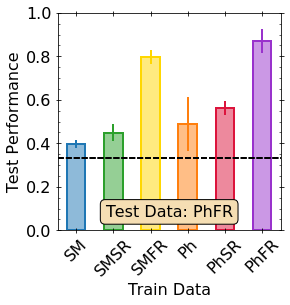

In [89]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16

trainLabels = ['StellarMap','StellarMap_SemiReal','StellarMap_FullReal',
               'Photometry','Photometry_SemiReal','Photometry_FullReal']
testLabel = 'Photometry_FullReal'
shortLabels = ['SM','SMSR','SMFR','Ph','PhSR','PhFR']
colours = ['C0','C2','gold','C1','crimson','darkorchid']

    
dataDir = '/home/bottrell/scratch/RealCNN/MultiClass/Models/'
figDir = '/home/bottrell/scratch/RealCNN/MultiClass/Figures/Bootstrap/'
update = 0 
version = 0

fig,ax = plt.subplots(figsize=(4,4))
#fig.subplots_adjust(hspace=0.25)

for yy,_trainLabel,shortLabel,colour in zip(range(len(trainLabels)),trainLabels,shortLabels,colours):
    
    if 'StellarMap' in testLabel and 'Photometry' in _trainLabel:
        trainLabel=_trainLabel+'-NC1-i'
    else:
        trainLabel=_trainLabel
    fileNames = glob(dataDir+'ConfMatrix-Test-{}-Train-{}-RS-*-{}-v{}.npz'.format(testLabel,trainLabel,update,version))
    nBoot = len(fileNames)
    perf = np.zeros(nBoot)
    errU = np.zeros(nBoot)
    errL = np.zeros(nBoot)

    if _trainLabel==testLabel:
        linewidth=2
    else:
        linewidth=2

    with np.load(fileNames[0]) as f:
        cnf = np.zeros((nBoot,*f['cnf'].shape))
    diag = np.diag_indices(cnf.shape[1])

    for i,fileName in enumerate(fileNames):
        with np.load(fileName) as f:
            perf[i] = np.nansum(f['cnf'][diag])/np.nansum(f['cnf'])

    med = np.nanmedian(perf)
    err = [med-np.nanpercentile(perf,q=5),np.nanpercentile(perf,q=95)-med]
    #print(err)

    ax.bar(yy,med,width=0.5,color=colour,edgecolor=colour,linewidth=0,alpha=0.5,zorder=-1)
    ax.bar(yy,med,width=0.5,color='None',edgecolor=colour,linewidth=linewidth,alpha=1)
    ax.errorbar(yy,med,yerr=[err],color=colour,ecolor=colour,linewidth=linewidth,alpha=1)
    
    # remove ticks and labels x
    ax.tick_params(axis='both',which='both',bottom=True,left=True,right=True,labelleft=True,
                   top=True,labelbottom=True,direction='in')
    ax.minorticks_on()
    ax.tick_params(axis='x',which='minor',bottom=False,top=False)
    ax.tick_params(axis='both',which='major',direction='inout',size=5)

    ax.set_xticks(range(6))
    ax.set_xticklabels(shortLabels,rotation=45)
    ax.set_xlim(-0.5,5.5)
    ax.set_ylim(0.,1)
    ax.axhline(0.333,color='black',linestyle='dashed')
    
ax.text(0.5,0.05,'Test Data: PhFR',transform=ax.transAxes,ha='center',va='bottom',
        bbox=dict(boxstyle="round",ec='black',fc='wheat'))
            


ax.set_ylabel('Test Performance')
    
ax.set_xlabel('Train Data')
fig.savefig(figDir+'TrainTest_Performance_PhFRonly.pdf',bbox_inches='tight')     

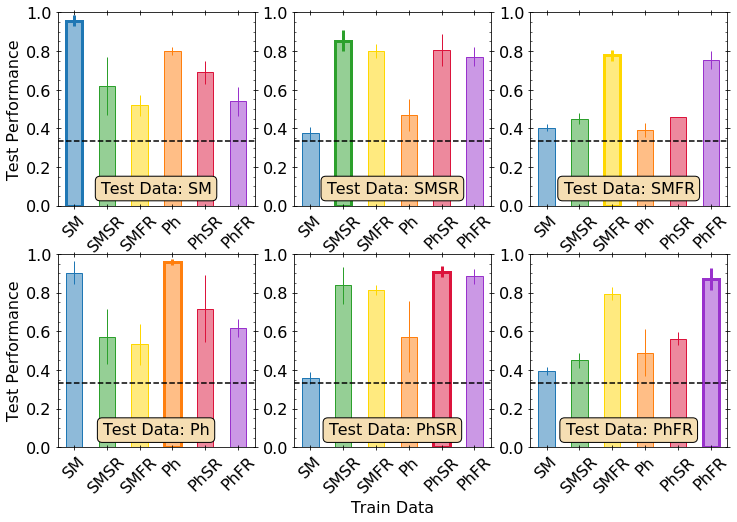

In [88]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16

trainLabels = ['StellarMap','StellarMap_SemiReal','StellarMap_FullReal',
               'Photometry','Photometry_SemiReal','Photometry_FullReal']
testLabels = ['StellarMap','StellarMap_SemiReal','StellarMap_FullReal',
               'Photometry','Photometry_SemiReal','Photometry_FullReal']
shortLabels = ['SM','SMSR','SMFR','Ph','PhSR','PhFR']
colours = ['C0','C2','gold','C1','crimson','darkorchid']

    
dataDir = '/home/bottrell/scratch/RealCNN/MultiClass/Models/'
figDir = '/home/bottrell/scratch/RealCNN/MultiClass/Figures/Bootstrap/'
update = 0 
version = 0

fig,axarr = plt.subplots(2,3,figsize=(12,8))
fig.subplots_adjust(hspace=0.25)

for yy,testLabel,shortLabel in zip(range(6),testLabels,shortLabels):
    ax = axarr.flat[yy]
    for xx,_trainLabel,colour in zip(range(len(trainLabels)),trainLabels,colours):
    
        if 'StellarMap' in testLabel and 'Photometry' in _trainLabel:
            trainLabel=_trainLabel+'-NC1-i'
        else:
            trainLabel=_trainLabel
        fileNames = glob(dataDir+'ConfMatrix-Test-{}-Train-{}-RS-*-{}-v{}.npz'.format(testLabel,trainLabel,update,version))
        nBoot = len(fileNames)
        perf = np.zeros(nBoot)
        errU = np.zeros(nBoot)
        errL = np.zeros(nBoot)
        
        if _trainLabel==testLabel:
            linewidth=3
        else:
            linewidth=1
        
        with np.load(fileNames[0]) as f:
            cnf = np.zeros((nBoot,*f['cnf'].shape))
        diag = np.diag_indices(cnf.shape[1])
   
        for i,fileName in enumerate(fileNames):
            with np.load(fileName) as f:
                perf[i] = np.nansum(f['cnf'][diag])/np.nansum(f['cnf'])
                
        med = np.nanmedian(perf)
        err = [med-np.nanpercentile(perf,q=5),np.nanpercentile(perf,q=95)-med]
        #print(err)
        
        ax.bar(xx,med,width=0.5,color=colour,edgecolor=colour,linewidth=0,alpha=0.5,zorder=-1)
        ax.bar(xx,med,width=0.5,color='None',edgecolor=colour,linewidth=linewidth,alpha=1)
        ax.errorbar(xx,med,yerr=[err],color=colour,ecolor=colour,linewidth=linewidth,alpha=1)
    
                
        if 'StellarMap' in testLabel and 'Photometry' in trainLabel:
            trainLabel=trainLabel[:-6]
        #print(perf)
    
    # remove ticks and labels x
    ax.tick_params(axis='both',which='both',bottom=True,left=True,right=True,labelleft=True,
                   top=True,labelbottom=True,direction='in')
    ax.minorticks_on()
    ax.tick_params(axis='x',which='minor',bottom=False,top=False)
    ax.tick_params(axis='both',which='major',direction='inout',size=5)

    ax.set_xticks(range(6))
    ax.set_xticklabels(shortLabels,rotation=45)
    ax.set_xlim(-0.5,5.5)
    ax.set_ylim(0.,1)
    ax.axhline(0.333,color='black',linestyle='dashed')
    ax.text(0.5,0.05,'Test Data: {}'.format(shortLabel),transform=ax.transAxes,ha='center',va='bottom',
            bbox=dict(boxstyle="round",ec='black',fc='wheat'))
            

for ax in axarr.flat[::3]:
    ax.set_ylabel('Test Performance')
    
axarr.flat[4].set_xlabel('Train Data')
fig.savefig(figDir+'TestTrain_Performance.pdf',bbox_inches='tight')        


IndexError: index 3 is out of bounds for axis 0 with size 3

ValueError: Image size of 694491x26618 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1600x500 with 1 Axes>